## Aqueous Solubility Predictor

## Moleculenet-ESOL data set

### Import Libraries

In [1]:
# Base Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# rdkit libraries
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit import rdBase
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit import DataStructs

from rdkit.Chem import Descriptors as des
from rdkit.Chem.Descriptors import qed
from rdkit.Chem import QED
from rdkit.ML.Descriptors import MoleculeDescriptors

# PADElpy
from padelpy import padeldescriptor

# MolVS
from molvs import standardize_smiles

# Data processing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import power_transform

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor 
from sklearn.metrics import r2_score, accuracy_score, mean_squared_error, mean_absolute_error

### Read data

In [2]:
x = pd.read_csv('delaney-processed.csv')
x.head()

,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.77,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.30,Cc1occc1C(=O)Nc2ccccc2
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.06,CC(C)=CCCC(C)=CC(=O)
3,Picene,-6.618,2,278.354,0,5,0,0.00,-7.87,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43
4,Thiophene,-2.232,2,84.143,0,1,0,0.00,-1.33,c1ccsc1


### Statistics

In [3]:
x.describe()

,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre
count,1128.000000,1128.000000,1128.000000,1128.000000,1128.000000,1128.000000,1128.000000,1128.000000
mean,-2.988192,1.058511,203.937074,0.701241,1.390957,2.177305,34.872881,-3.050102
std,1.683220,0.238560,102.738077,1.089727,1.318286,2.640974,35.383593,2.096441
min,-9.702000,0.000000,16.043000,0.000000,0.000000,0.000000,0.000000,-11.600000
25%,-3.948250,1.000000,121.183000,0.000000,0.000000,0.000000,0.000000,-4.317500
50%,-2.870000,1.000000,182.179000,0.000000,1.000000,1.000000,26.300000,-2.860000
75%,-1.843750,1.000000,270.372000,1.000000,2.000000,3.000000,55.440000,-1.600000
max,1.091000,2.000000,780.949000,11.000000,8.000000,23.000000,268.680000,1.580000


In [4]:
print(x.shape)
print(x.columns)

(1128, 10)
Index(['Compound ID', 'ESOL predicted log solubility in mols per litre',
       'Minimum Degree', 'Molecular Weight', 'Number of H-Bond Donors',
       'Number of Rings', 'Number of Rotatable Bonds', 'Polar Surface Area',
       'measured log solubility in mols per litre', 'smiles'],
      dtype='object')


### Check for missing values and duplictes  

In [5]:
x.isnull().apply(pd.value_counts)

,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles
False,1128,1128,1128,1128,1128,1128,1128,1128,1128,1128


In [6]:
x.duplicated().any()

False

In [7]:
x1=x[['Compound ID', 'smiles', 'measured log solubility in mols per litre','ESOL predicted log solubility in mols per litre',]]
x1=x1.rename(columns={'measured log solubility in mols per litre': 'Measured Sol','ESOL predicted log solubility in mols per litre':'Predicted Sol'})
x1.head()

,Compound ID,smiles,Measured Sol,Predicted Sol
0,Amigdalin,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...,-0.77,-0.974
1,Fenfuram,Cc1occc1C(=O)Nc2ccccc2,-3.30,-2.885
2,citral,CC(C)=CCCC(C)=CC(=O),-2.06,-2.579
3,Picene,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43,-7.87,-6.618
4,Thiophene,c1ccsc1,-1.33,-2.232


### Standardize Smiles

In [8]:
stdsmi=[standardize_smiles(smi) for smi in x1['smiles']]
stdsmi=pd.DataFrame(stdsmi, columns=['SMILES'])
stdsmi.head()

,SMILES
0,N#CC(OC1OC(COC2OC(CO)C(O)C(O)C2O)C(O)C(O)C1O)c...
1,Cc1occc1C(=O)Nc1ccccc1
2,CC(C)=CCCC(C)=CC=O
3,c1ccc2c(c1)ccc1c2ccc2c3ccccc3ccc21
4,c1ccsc1


In [9]:
x1=pd.concat([x1[['Compound ID','Measured Sol', 'Predicted Sol']], stdsmi], axis=1)
x1.head()

,Compound ID,Measured Sol,Predicted Sol,SMILES
0,Amigdalin,-0.77,-0.974,N#CC(OC1OC(COC2OC(CO)C(O)C(O)C2O)C(O)C(O)C1O)c...
1,Fenfuram,-3.30,-2.885,Cc1occc1C(=O)Nc1ccccc1
2,citral,-2.06,-2.579,CC(C)=CCCC(C)=CC=O
3,Picene,-7.87,-6.618,c1ccc2c(c1)ccc1c2ccc2c3ccccc3ccc21
4,Thiophene,-1.33,-2.232,c1ccsc1


### Get PADEL descriptors

In [10]:
x1[['SMILES','Measured Sol']].to_csv('esol.smi', sep='\t', header=None, index=None)

In [11]:
padeldescriptor(mol_dir='esol.smi', d_file='esol-desc.csv', d_2d=True, d_3d=True, maxruntime=10000, waitingjobs=10)

RuntimeError: PaDEL-Descriptor encountered an error: Exception in thread "Thread-220" Exception in thread "Thread-221" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-214" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-365" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-364" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-358" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-150" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-149" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-143" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-292" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-286" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-293" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-502" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-436" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-437" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-430" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-509" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-508" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-581" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-580" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-574" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-653" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-652" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-646" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-725" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-724" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-718" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-797" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-796" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-790" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-869" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-868" Exception in thread "Thread-862" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-941" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-940" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-934" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-1013" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-1012" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-1006" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-1085" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-1084" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-1078" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-1157" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-1156" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-1150" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-1229" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-1228" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-1222" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-1300" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-1301" Exception in thread "Thread-1294" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-1373" Exception in thread "Thread-1372" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-1366" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-1445" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-1444" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-1438" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-1589" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-1588" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-1582" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-1517" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-1516" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-1510" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-1660" Exception in thread "Thread-1661" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-1654" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-1804" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-1805" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-1798" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-1733" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-1732" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-1726" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-1877" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-1876" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-1870" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-2164" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-1942" Exception in thread "Thread-1948" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-1949" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-2158" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-2165" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-2014" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-2020" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-2021" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-2086" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-2092" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-2093" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-2237" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-2236" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-2230" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-2309" Exception in thread "Thread-2314" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-2381" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-2380" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-2374" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-2303" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-2452" Exception in thread "Thread-2453" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-2446" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-2525" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-2524" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-2518" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-2668" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-2662" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-2597" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-2596" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-2590" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-2669" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-2813" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-2812" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-2806" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-2741" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-2740" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-2734" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-2957" Exception in thread "Thread-2956" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-2950" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-2886" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-2885" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-2879" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-3094" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-3029" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-3028" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-3022" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-3101" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-3100" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-3245" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-3244" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-3238" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-3173" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-3172" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-3166" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-3533" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-3532" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-3526" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-3461" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-3460" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-3454" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-3389" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-3388" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-3382" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-3317" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-3316" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-3310" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-3821" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-3814" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-3749" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-3748" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-3742" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-3677" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-3676" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-3670" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-3605" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-3604" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-3598" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-3820" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-4109" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-4108" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-4102" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-4037" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-4036" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-4030" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-3965" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-3964" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-3958" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-3893" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-3892" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-3886" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-4396" Exception in thread "Thread-4397" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-4390" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-4325" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-4324" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-4318" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-4253" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-4252" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-4246" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-4180" Exception in thread "Thread-4181" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-4174" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-4685" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-4684" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-4678" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-4613" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-4612" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-4606" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-4541" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-4540" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-4534" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-4469" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-4468" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-4462" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-4757" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-4756" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-4750" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-4973" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-4972" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-4966" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-4901" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-4900" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-4894" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-4829" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-4828" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-4822" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-5260" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-5254" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-5189" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-5188" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-5182" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-5117" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-5116" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-5110" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-5045" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-5044" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-5038" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-5261" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-5549" Exception in thread "Thread-5548" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-5542" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-5476" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-5477" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-5405" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-5404" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-5398" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-5333" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-5332" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-5326" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-5470" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-5837" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-5836" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-5830" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-5765" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-5764" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-5758" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-5711" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-5710" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-5704" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-5621" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-5620" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-5614" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-6125" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-6124" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-6118" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-6053" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-6052" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-6046" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-5981" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-5980" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-5974" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-5908" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-5902" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-5909" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-6341" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-6340" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-6334" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-6413" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-6412" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-6406" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-6269" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-6268" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-6262" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-6197" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-6196" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-6190" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-6629" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-6628" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-6622" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-6557" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-6556" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-6550" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-6485" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-6484" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-6478" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-6694" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-6700" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-6701" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-6917" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-6916" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-6910" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-6845" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-6844" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-6773" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-6772" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-6766" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-6838" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-7204" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-7205" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-7198" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-6989" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-6988" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-6982" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-7133" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-7132" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-7126" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-7061" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-7060" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-7054" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-7493" Exception in thread "Thread-7492" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-7486" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-7421" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-7420" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-7414" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-7364" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-7358" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-7277" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-7276" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-7270" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-7365" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-7781" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-7780" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-7774" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-7709" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-7708" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-7702" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-7639" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-7638" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-7632" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-7565" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-7564" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-7558" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-8069" Exception in thread "Thread-8068" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-8062" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-7997" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-7996" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-7990" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-7909" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-7899" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-7883" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-7925" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-7924" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-7918" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-8356" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-8357" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-8350" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-8285" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-8284" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-8278" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-8213" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-8212" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-8206" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-8200" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-8199" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-8193" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-8573" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-8570" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-8559" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-8645" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-8644" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-8638" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-8429" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-8428" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-8572" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-8571" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-8422" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-8558" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-8933" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-8932" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-8926" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-8861" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-8860" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-8854" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-8789" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-8788" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-8782" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-8717" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-8716" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-8710" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-9221" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-9220" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-9214" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-9149" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-9148" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-9142" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-9077" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-9076" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-9070" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-9005" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-9004" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-8998" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-9509" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-9508" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-9502" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-9437" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-9436" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-9430" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-9293" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-9292" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-9286" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-9365" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-9364" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-9358" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-9797" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-9796" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-9790" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-9725" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-9724" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-9718" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-9653" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-9652" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-9646" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-9581" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-9580" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-9574" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-9927" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-9939" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-9940" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-10006" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-10157" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-10156" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-10150" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-10085" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-10084" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-10078" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-9941" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-9938" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-9926" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-10013" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-10012" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-10229" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-10228" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-10222" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-10329" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-10335" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-10336" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-10517" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-10516" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-10510" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-10445" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-10444" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-10438" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-10373" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-10372" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-10366" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-10798" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-10750" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-10748" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-10737" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-10751" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-10749" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-10736" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-10625" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-10624" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-10618" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-10805" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-10804" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-10948" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-10949" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-10942" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-11082" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-11075" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-11063" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-11093" Exception in thread "Thread-11092" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-11086" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-10876" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-10870" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-10877" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-11236" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-11231" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-11221" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-11237" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-11235" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-11223" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-11302" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-11308" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-11309" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-11597" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-11596" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-11590" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-11525" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-11524" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-11518" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-11452" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-11450" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-11438" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-11453" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-11451" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-11439" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-11885" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-11884" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-11878" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-11813" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-11812" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-11806" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-11741" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-11740" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-11734" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-11669" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-11668" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-11662" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-12172" Exception in thread "Thread-12173" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-12166" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-12101" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-12100" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-12094" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-12029" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-12028" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-12022" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-11957" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-11956" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-11950" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-12238" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-12244" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-12245" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-12532" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-12533" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-12526" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-12461" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-12454" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-12389" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-12388" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-12382" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-12317" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-12316" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-12310" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-12460" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-12821" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-12814" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-12749" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-12748" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-12742" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-12677" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-12676" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-12670" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-12605" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-12604" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-12598" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-12820" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-13109" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-13108" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-13102" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-13037" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-13036" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-13030" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-12965" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-12964" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-12958" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-12893" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-12892" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-12886" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-13397" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-13396" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-13390" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-13325" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-13324" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-13318" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-13253" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-13252" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-13246" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-13181" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-13180" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-13174" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-13469" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-13468" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-13462" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-13534" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-13540" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-13541" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-13829" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-13828" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-13822" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-13757" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-13756" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-13750" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-13684" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-13685" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-13678" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-13613" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-13612" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-13606" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-14045" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-14044" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-14038" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-13973" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-13972" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-13966" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-13923" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-13922" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-13916" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-14261" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-14260" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-14254" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-14189" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-14188" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-14182" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-14116" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-14117" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-14110" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-14477" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-14476" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-14470" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-14405" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-14404" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-14398" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-14333" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-14332" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-14326" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-14693" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-14692" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-14686" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-14621" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-14620" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-14614" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-14549" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-14548" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-14542" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-14981" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-14980" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-14974" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-14908" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-14909" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-14902" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-14830" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-14829" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-14837" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-14836" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-14758" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-14823" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-15046" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-15052" Exception in thread "Thread-15053" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-15340" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-15341" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-15334" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-15269" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-15268" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-15262" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-15197" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-15196" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-15190" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-15125" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-15124" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-15118" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-15629" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-15628" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-15622" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-15557" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-15556" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-15550" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-15485" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-15484" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-15478" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-15413" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-15412" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-15406" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-15917" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-15916" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-15910" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-15845" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-15844" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-15838" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-15773" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-15772" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-15766" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-15700" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-15701" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-15694" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-16133" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-16132" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-16126" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-16061" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-16060" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-16054" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-15989" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-15988" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-15982" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-16277" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-16276" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-16270" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-16205" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-16204" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-16198" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-16493" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-16492" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-16421" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-16420" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-16414" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-16349" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-16348" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-16342" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-16486" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-16709" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-16708" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-16702" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-16637" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-16636" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-16630" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-16564" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-16565" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-16558" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-16996" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-16997" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-16990" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-16928" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-16925" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-16919" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-16853" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-16852" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-16846" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-16781" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-16780" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-16774" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-17212" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-17213" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-17206" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-17141" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-17140" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-17134" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-17069" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-17068" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-17062" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-17501" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-17500" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-17494" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-17429" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-17428" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-17422" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-17285" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-17284" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-17278" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-17357" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-17356" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-17350" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-17789" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-17788" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-17782" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-17716" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-17717" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-17710" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-17645" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-17644" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-17638" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-17573" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-17572" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-17566" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-18077" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-18076" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-18070" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-18005" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-18004" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-17998" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-17932" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-17933" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-17926" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-17861" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-17860" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-17854" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-18293" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-18292" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-18286" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-18221" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-18220" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-18214" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-18148" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-18149" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-18142" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-18437" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-18436" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-18430" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-18365" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-18364" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-18358" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-18725" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-18724" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-18718" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-18653" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-18652" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-18646" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-18581" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-18580" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-18574" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-18509" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-18508" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-18502" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-18869" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-18868" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-18862" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-18941" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-18940" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-18934" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-18797" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-18796" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-18790" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-19013" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-19012" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-19006" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-19301" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-19300" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-19294" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-19229" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-19228" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-19222" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-19157" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-19156" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-19150" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-19085" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-19084" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-19078" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-19373" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-19372" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-19366" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-19438" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-19444" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-19445" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-19510" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-19516" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-19517" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-19582" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-19588" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-19589" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-19733" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-19732" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-19726" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-19661" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-19660" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-19654" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-19798" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-19804" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-19805" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-19870" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-19876" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-19877" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-20165" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-20164" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-20158" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-20093" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-20092" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-20086" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-20021" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-20020" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-20014" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-19949" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-19948" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-19942" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-20230" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-20237" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-20236" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-20381" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-20380" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-20374" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-20453" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-20452" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-20446" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-20308" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-20309" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-20302" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-20518" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-20524" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-20525" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-20741" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-20740" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-20734" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-20669" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-20668" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-20662" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-20597" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-20596" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-20590" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-20806" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-20812" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-20813" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-21101" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-21100" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-21094" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-21029" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-21028" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-21022" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-21013" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-21002" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-20986" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-20885" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-20884" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-20878" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-21388" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-21382" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-21317" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-21316" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-21310" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-21245" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-21244" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-21238" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-21173" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-21172" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-21166" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-21389" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-21454" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-21460" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-21461" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-21749" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-21748" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-21742" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-21676" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-21677" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-21670" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-21605" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-21604" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-21598" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-21533" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-21532" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-21526" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-21965" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-21964" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-21958" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-21893" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-21892" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-21886" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-21821" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-21820" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-21814" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-22030" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-22036" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-22037" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-22253" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-22252" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-22246" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-22181" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-22180" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-22174" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-22108" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-22109" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-22102" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-22541" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-22540" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-22534" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-22469" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-22468" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-22462" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-22397" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-22396" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-22390" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-22325" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-22324" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-22318" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-22828" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-22829" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-22822" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-22757" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-22756" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-22750" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-22685" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-22684" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-22678" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-22613" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-22612" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-22606" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-22894" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-22900" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-22901" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-23057" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-23066" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-23067" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-23260" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-23261" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-23254" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-23189" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-23188" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-23182" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-23117" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-23116" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-23110" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-23065" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-23059" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-23046" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-23326" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-23332" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-23333" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-23405" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-23470" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-23477" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-23476" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-23404" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-23398" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-23621" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-23620" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-23614" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-23549" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-23548" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-23542" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-23686" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-23692" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-23693" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-23758" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-23764" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-23765" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-23909" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-23908" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-23902" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-23837" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-23836" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-23830" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-23974" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-23980" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-23981" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-24046" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-24052" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-24053" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-24268" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-24269" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-24262" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-24197" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-24196" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-24190" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-24125" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-24124" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-24118" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-24334" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-24340" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-24341" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-24557" Exception in thread "Thread-24556" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-24550" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-24485" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-24484" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-24478" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-24413" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-24412" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-24406" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-24845" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-24844" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-24838" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-24773" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-24772" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-24766" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-24701" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-24700" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-24694" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-24629" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-24628" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-24622" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-24910" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-24916" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-24917" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-25133" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-25132" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-25126" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-25061" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-25060" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-25054" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-24989" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-24988" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-24982" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-25198" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-25421" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-25420" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-25414" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-25205" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-25204" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-25349" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-25348" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-25342" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-25277" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-25276" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-25270" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-25486" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-25492" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-25493" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-25709" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-25708" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-25702" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-25637" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-25636" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-25630" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-25565" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-25564" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-25558" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-25997" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-25996" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-25990" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-25925" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-25924" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-25918" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-25846" Exception in thread "Thread-25852" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-25853" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-25774" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-25780" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-25781" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-26062" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-26068" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-26069" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-26206" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-26212" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-26213" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-26357" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-26356" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-26350" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-26141" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-26140" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-26134" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-26285" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-26284" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-26278" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-26572" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-26573" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-26566" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-26501" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-26500" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-26494" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-26429" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-26428" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-26422" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-26645" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-26644" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-26638" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-26710" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-26716" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-26717" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-26855" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-26867" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-26873" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-26933" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-26932" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-26816" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-26815" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-26809" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-26926" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-26998" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-27004" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-27005" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-27220" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-27221" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-27214" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-27195" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-27194" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-27188" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-27077" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-27076" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-27070" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-27286" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-27292" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-27293" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-27509" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-27508" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-27502" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-27437" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-27436" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-27430" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-27365" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-27364" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-27358" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-27797" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-27796" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-27790" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-27725" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-27724" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-27718" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-27653" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-27652" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-27646" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-27581" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-27580" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-27574" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-27862" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-27868" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-27869" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-27934" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-27940" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-27941" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-28006" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-28012" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-28013" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-28157" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-28085" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-28084" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-28078" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-28156" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-28150" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-28438" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-28373" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-28372" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-28360" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-28368" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-28367" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-28358" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-28229" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-28228" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-28222" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-28445" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-28444" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-28528" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-28534" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-28535" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-28733" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-28732" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-28726" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-28661" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-28660" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-28654" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-28607" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-28606" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-28600" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-29021" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-29020" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-29014" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-28949" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-28948" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-28942" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-28877" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-28876" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-28870" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-28805" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-28804" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-28798" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-29086" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-29092" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-29093" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-29381" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-29380" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-29374" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-29309" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-29308" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-29302" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-29236" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-29234" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-29223" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-29237" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-29235" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-29222" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-29669" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-29668" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-29662" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-29597" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-29596" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-29590" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-29525" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-29524" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-29518" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-29453" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-29452" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-29446" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-29813" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-29812" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-29806" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-29740" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-29741" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-29734" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-29878" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-29884" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-29885" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-30101" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-30100" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-30094" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-30029" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-30028" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-30022" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-29957" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-29956" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-29950" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-30316" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-30317" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-30310" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-30245" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-30244" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-30238" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-30173" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-30172" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-30166" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-30382" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-30389" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-30388" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-30454" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-30460" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-30677" Exception in thread "Thread-30676" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-30461" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-30670" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-30605" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-30604" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-30598" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-30533" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-30532" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-30526" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-30965" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-30964" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-30958" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-30899" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-30898" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-30892" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-30821" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-30820" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-30814" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-30749" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-30748" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-30742" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-31037" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-31036" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-31030" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-31253" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-31252" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-31246" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-31181" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-31180" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-31174" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-31109" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-31108" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-31102" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-31469" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-31468" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-31462" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-31397" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-31396" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-31390" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-31325" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-31324" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-31318" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-31685" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-31678" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-31613" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-31612" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-31606" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-31541" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-31540" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-31534" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-31684" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-31901" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-31900" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-31858" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-31857" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-31851" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-31757" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-31756" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-31750" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-31894" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-32117" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-32116" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-32110" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-32051" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-32050" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-32044" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-31973" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-31972" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-31966" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-32182" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-32188" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-32189" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-32405" Exception in thread "Thread-32404" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-32333" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-32332" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-32326" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-32261" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-32260" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-32254" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-32398" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-32693" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-32692" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-32686" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-32621" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-32620" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-32614" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-32549" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-32548" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-32542" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-32477" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-32476" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-32470" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-32758" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-32764" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-32765" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-32830" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-32836" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-32837" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-32902" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-32908" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-32909" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-33125" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-33124" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-33118" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-33053" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-33052" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-33046" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-32981" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-32980" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-32974" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-33412" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-33413" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-33406" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-33341" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-33338" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-33326" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-33340" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-33339" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-33327" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-33197" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-33196" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-33190" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-33478" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-33484" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-33485" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-33701" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-33700" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-33694" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-33556" Exception in thread "Thread-33557" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-33550" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-33629" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-33628" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-33622" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-33766" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-33772" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-33773" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-33989" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-33988" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-33982" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-33917" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-33916" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-33910" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-33845" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-33844" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-33838" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-34054" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-34060" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-34061" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-34277" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-34276" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-34270" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-34205" Exception in thread "Thread-34204" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-34198" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-34133" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-34132" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-34126" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-34342" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-34348" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-34565" Exception in thread "Thread-34564" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-34478" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-34491" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-34492" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-34349" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-34479" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-34490" Exception in thread "Thread-34493" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-34558" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-34702" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-34708" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-34709" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-34925" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-34924" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-34918" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-34846" Exception in thread "Thread-34844" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-34833" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-34637" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-34636" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-34630" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-34853" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-34852" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-34845" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-34990" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-34996" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-34997" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-35062" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-35068" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-35069" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-35134" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-35141" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-35140" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-35357" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-35356" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-35350" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-35284" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-35285" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-35278" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-35213" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-35212" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-35206" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-35645" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-35644" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-35638" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-35573" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-35572" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-35566" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-35501" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-35500" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-35461" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-35458" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-35494" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-35444" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-35933" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-35932" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-35926" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-35861" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-35860" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-35854" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-35788" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-35787" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-35775" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-35789" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-35786" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-35774" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-35998" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-36004" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-36005" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-36070" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-36076" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-36077" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-36365" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-36364" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-36358" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-36293" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-36292" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-36286" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-36221" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-36220" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-36214" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-36149" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-36148" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-36142" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-36430" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-36436" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-36653" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-36652" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-36646" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-36437" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-36541" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-36540" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-36525" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-36581" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-36580" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-36574" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-36718" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-36941" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-36938" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-36927" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-36940" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-36939" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-36926" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-36797" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-36796" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-36790" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-36725" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-36724" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-37229" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-37228" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-37222" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-37157" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-37156" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-37150" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-37085" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-37084" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-37078" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-37013" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-37012" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-37006" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-37294" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-37300" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-37301" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-37588" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-37589" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-37582" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-37517" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-37516" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-37510" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-37391" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-37390" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-37445" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-37438" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-37444" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-37384" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-37877" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-37870" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-37805" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-37804" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-37798" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-37733" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-37732" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-37726" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-37661" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-37660" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-37654" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-37876" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-37942" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-37948" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-37949" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-38014" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-38020" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-38021" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-38237" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-38230" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-38165" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-38164" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-38158" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-38093" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-38092" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-38086" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-38236" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-38302" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-38308" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-38309" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-38446" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-38452" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-38453" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-38525" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-38524" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-38518" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-38381" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-38380" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-38374" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-38590" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-38596" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-38597" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-38813" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-38812" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-38805" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-38802" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-38789" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-38669" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-38668" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-38662" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-38806" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-39098" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-39087" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-39099" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-39101" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-39086" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-38957" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-38956" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-38950" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-38885" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-38884" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-38878" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-39100" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-39317" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-39315" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-39302" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-39316" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-39314" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-39303" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-39173" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-39172" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-39166" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-39533" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-39532" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-39526" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-39461" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-39460" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-39454" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-39389" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-39388" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-39382" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-39821" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-39748" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-39746" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-39734" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-39749" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-39747" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-39735" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-39605" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-39604" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-39598" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-39820" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-39814" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-40109" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-40108" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-40102" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-40037" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-40036" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-40030" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-39965" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-39964" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-39958" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-39893" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-39892" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-39886" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-40253" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-40252" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-40246" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-40181" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-40180" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-40174" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-40469" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-40468" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-40462" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-40397" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-40396" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-40390" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-40325" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-40324" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-40318" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-40685" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-40684" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-40678" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-40541" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-40540" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-40534" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-40613" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-40612" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-40606" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-40901" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-40900" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-40894" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-40829" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-40828" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-40822" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-40757" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-40756" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-40750" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-41117" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-41116" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-41110" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-41045" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-41044" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-41038" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-40973" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-40972" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-40966" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-41189" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-41188" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-41182" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-41254" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-41260" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-41261" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-41477" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-41476" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-41470" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-41405" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-41404" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-41398" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-41333" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-41332" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-41326" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-41542" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-41548" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-41549" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-41837" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-41830" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-41765" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-41764" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-41758" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-41693" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-41692" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-41686" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-41621" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-41622" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-41615" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-41836" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-41902" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-41908" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-41909" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-41974" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-41980" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-41981" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-42197" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-42196" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-42190" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-42125" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-42124" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-42118" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-42053" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-42052" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-42046" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-42294" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-42300" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-42301" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-42485" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-42484" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-42478" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-42413" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-42412" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-42406" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-42341" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-42340" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-42334" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-42550" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-42556" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-42557" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-42844" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-42845" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-42838" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-42773" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-42772" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-42766" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-42701" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-42700" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-42694" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-42622" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-42629" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-42628" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-42910" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-42916" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-42917" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-42982" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-42988" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-42989" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-43054" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-43060" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-43061" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-43205" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-43198" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-43133" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-43132" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-43126" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-43204" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-43270" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-43276" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-43277" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-43342" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-43348" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-43349" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-43414" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-43420" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-43421" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-43636" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-43637" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-43630" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-43565" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-43564" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-43558" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-43493" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-43492" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-43486" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-43765" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-43778" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-43780" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-43925" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-43924" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-43918" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-43853" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-43852" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-43846" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-43781" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-43779" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-43767" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-44212" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-44206" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-44213" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-43990" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-43996" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-43997" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-44062" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-44068" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-44069" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-44134" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-44140" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-44141" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-44490" Exception in thread "Thread-44486" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-44466" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-44501" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-44500" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-44494" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-44489" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-44485" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-44465" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-44285" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-44284" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-44278" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-44717" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-44716" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-44710" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-44632" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-44628" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-44612" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-44645" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-44644" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-44638" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-44933" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-44932" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-44926" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-44861" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-44860" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-44854" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-44789" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-44788" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-44782" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-45166" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-45160" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-45221" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-45220" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-45214" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-45077" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-45076" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-45070" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-45005" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-45004" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-44998" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-45169" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-45509" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-45508" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-45502" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-45437" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-45436" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-45430" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-45365" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-45364" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-45358" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-45293" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-45292" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-45286" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-45574" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-45580" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-45581" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-45646" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-45652" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-45653" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-45718" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-45724" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-45725" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-45797" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-45796" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-45790" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-45862" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-45868" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-45869" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-45934" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-45940" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-45941" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-46229" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-46228" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-46222" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-46157" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-46156" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-46150" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-46085" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-46084" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-46078" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-46013" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-46012" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-46006" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-46445" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-46444" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-46438" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-46373" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-46372" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-46366" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-46301" java.lang.NullPointerException
Exception in thread "Thread-46300" java.lang.NullPointerException
Exception in thread "Thread-46294" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-46661" java.lang.NullPointerException
Exception in thread "Thread-46660" java.lang.NullPointerException
Exception in thread "Thread-46654" java.lang.NullPointerException
Exception in thread "Thread-46589" java.lang.NullPointerException
Exception in thread "Thread-46588" java.lang.NullPointerException
Exception in thread "Thread-46582" java.lang.NullPointerException
Exception in thread "Thread-46517" java.lang.NullPointerException
Exception in thread "Thread-46516" java.lang.NullPointerException
Exception in thread "Thread-46510" java.lang.NullPointerException
Exception in thread "Thread-46870" java.lang.NullPointerException
Exception in thread "Thread-46805" java.lang.NullPointerException
Exception in thread "Thread-46804" Exception in thread "Thread-46877" java.lang.NullPointerException
Exception in thread "Thread-46876" java.lang.NullPointerException
Exception in thread "Thread-46726" java.lang.NullPointerException
Exception in thread "Thread-46732" java.lang.NullPointerException
Exception in thread "Thread-46733" java.lang.NullPointerException
java.lang.NullPointerException
Exception in thread "Thread-46798" java.lang.NullPointerException
Exception in thread "Thread-47093" java.lang.NullPointerException
Exception in thread "Thread-47092" java.lang.NullPointerException
Exception in thread "Thread-47086" java.lang.NullPointerException
Exception in thread "Thread-47021" java.lang.NullPointerException
Exception in thread "Thread-47020" java.lang.NullPointerException
Exception in thread "Thread-47014" java.lang.NullPointerException
Exception in thread "Thread-46949" java.lang.NullPointerException
Exception in thread "Thread-46948" java.lang.NullPointerException
Exception in thread "Thread-46942" java.lang.NullPointerException
Exception in thread "Thread-47309" java.lang.NullPointerException
Exception in thread "Thread-47308" java.lang.NullPointerException
Exception in thread "Thread-47302" java.lang.NullPointerException
Exception in thread "Thread-47237" java.lang.NullPointerException
Exception in thread "Thread-47236" java.lang.NullPointerException
Exception in thread "Thread-47230" java.lang.NullPointerException
Exception in thread "Thread-47165" java.lang.NullPointerException
Exception in thread "Thread-47164" java.lang.NullPointerException
Exception in thread "Thread-47158" java.lang.NullPointerException
Exception in thread "Thread-47439" java.lang.NullPointerException
Exception in thread "Thread-47451" java.lang.NullPointerException
Exception in thread "Thread-47453" java.lang.NullPointerException
Exception in thread "Thread-47668" Exception in thread "Thread-47669" java.lang.NullPointerException
java.lang.NullPointerException
Exception in thread "Thread-47662" java.lang.NullPointerException
Exception in thread "Thread-47597" java.lang.NullPointerException
Exception in thread "Thread-47596" java.lang.NullPointerException
Exception in thread "Thread-47590" java.lang.NullPointerException
Exception in thread "Thread-47525" java.lang.NullPointerException
Exception in thread "Thread-47524" java.lang.NullPointerException
Exception in thread "Thread-47518" java.lang.NullPointerException
Exception in thread "Thread-47452" java.lang.NullPointerException
Exception in thread "Thread-47450" java.lang.NullPointerException
Exception in thread "Thread-47438" java.lang.NullPointerException
Exception in thread "Thread-47956" Exception in thread "Thread-47957" java.lang.NullPointerException
java.lang.NullPointerException
Exception in thread "Thread-47885" java.lang.NullPointerException
Exception in thread "Thread-47884" java.lang.NullPointerException
Exception in thread "Thread-47878" java.lang.NullPointerException
Exception in thread "Thread-47813" java.lang.NullPointerException
Exception in thread "Thread-47812" java.lang.NullPointerException
Exception in thread "Thread-47806" java.lang.NullPointerException
Exception in thread "Thread-47741" java.lang.NullPointerException
Exception in thread "Thread-47740" java.lang.NullPointerException
Exception in thread "Thread-47734" java.lang.NullPointerException
Exception in thread "Thread-47950" java.lang.NullPointerException
Exception in thread "Thread-48245" java.lang.NullPointerException
Exception in thread "Thread-48244" java.lang.NullPointerException
Exception in thread "Thread-48238" java.lang.NullPointerException
Exception in thread "Thread-48173" java.lang.NullPointerException
Exception in thread "Thread-48172" java.lang.NullPointerException
Exception in thread "Thread-48166" java.lang.NullPointerException
Exception in thread "Thread-48101" java.lang.NullPointerException
Exception in thread "Thread-48100" java.lang.NullPointerException
Exception in thread "Thread-48094" java.lang.NullPointerException
Exception in thread "Thread-48029" java.lang.NullPointerException
Exception in thread "Thread-48028" java.lang.NullPointerException
Exception in thread "Thread-48022" java.lang.NullPointerException
Exception in thread "Thread-48310" java.lang.NullPointerException
Exception in thread "Thread-48533" java.lang.NullPointerException
Exception in thread "Thread-48532" java.lang.NullPointerException
Exception in thread "Thread-48526" java.lang.NullPointerException
Exception in thread "Thread-48461" java.lang.NullPointerException
Exception in thread "Thread-48460" java.lang.NullPointerException
Exception in thread "Thread-48454" java.lang.NullPointerException
Exception in thread "Thread-48389" java.lang.NullPointerException
Exception in thread "Thread-48388" java.lang.NullPointerException
Exception in thread "Thread-48382" java.lang.NullPointerException
Exception in thread "Thread-48317" java.lang.NullPointerException
Exception in thread "Thread-48316" java.lang.NullPointerException
Exception in thread "Thread-48821" java.lang.NullPointerException
Exception in thread "Thread-48820" java.lang.NullPointerException
Exception in thread "Thread-48814" java.lang.NullPointerException
Exception in thread "Thread-48749" java.lang.NullPointerException
Exception in thread "Thread-48748" java.lang.NullPointerException
Exception in thread "Thread-48742" java.lang.NullPointerException
Exception in thread "Thread-48677" java.lang.NullPointerException
Exception in thread "Thread-48676" java.lang.NullPointerException
Exception in thread "Thread-48670" java.lang.NullPointerException
Exception in thread "Thread-48605" java.lang.NullPointerException
Exception in thread "Thread-48604" java.lang.NullPointerException
Exception in thread "Thread-48598" java.lang.NullPointerException
Exception in thread "Thread-48965" java.lang.NullPointerException
Exception in thread "Thread-48964" java.lang.NullPointerException
Exception in thread "Thread-48958" java.lang.NullPointerException
Exception in thread "Thread-48893" java.lang.NullPointerException
Exception in thread "Thread-48892" java.lang.NullPointerException
Exception in thread "Thread-48886" java.lang.NullPointerException
Exception in thread "Thread-49030" java.lang.NullPointerException
Exception in thread "Thread-49036" java.lang.NullPointerException
Exception in thread "Thread-49037" java.lang.NullPointerException
Exception in thread "Thread-49102" java.lang.NullPointerException
Exception in thread "Thread-49108" java.lang.NullPointerException
Exception in thread "Thread-49109" java.lang.NullPointerException
Exception in thread "Thread-49325" java.lang.NullPointerException
Exception in thread "Thread-49324" java.lang.NullPointerException
Exception in thread "Thread-49318" java.lang.NullPointerException
Exception in thread "Thread-49253" java.lang.NullPointerException
Exception in thread "Thread-49252" java.lang.NullPointerException
Exception in thread "Thread-49246" java.lang.NullPointerException
Exception in thread "Thread-49181" java.lang.NullPointerException
Exception in thread "Thread-49180" java.lang.NullPointerException
Exception in thread "Thread-49174" java.lang.NullPointerException
Exception in thread "Thread-49390" java.lang.NullPointerException
Exception in thread "Thread-49396" java.lang.NullPointerException
Exception in thread "Thread-49397" java.lang.NullPointerException
Exception in thread "Thread-49685" java.lang.NullPointerException
Exception in thread "Thread-49684" java.lang.NullPointerException
Exception in thread "Thread-49678" java.lang.NullPointerException
Exception in thread "Thread-49613" java.lang.NullPointerException
Exception in thread "Thread-49612" java.lang.NullPointerException
Exception in thread "Thread-49606" java.lang.NullPointerException
Exception in thread "Thread-49541" java.lang.NullPointerException
Exception in thread "Thread-49539" java.lang.NullPointerException
Exception in thread "Thread-49528" java.lang.NullPointerException
Exception in thread "Thread-49540" java.lang.NullPointerException
Exception in thread "Thread-49536" java.lang.NullPointerException
Exception in thread "Thread-49525" java.lang.NullPointerException
Exception in thread "Thread-49829" java.lang.NullPointerException
Exception in thread "Thread-49828" java.lang.NullPointerException
Exception in thread "Thread-49822" java.lang.NullPointerException
Exception in thread "Thread-49757" java.lang.NullPointerException
Exception in thread "Thread-49756" java.lang.NullPointerException
Exception in thread "Thread-49750" java.lang.NullPointerException
Exception in thread "Thread-49894" java.lang.NullPointerException
Exception in thread "Thread-49900" java.lang.NullPointerException
Exception in thread "Thread-49901" java.lang.NullPointerException
Exception in thread "Thread-50189" java.lang.NullPointerException
Exception in thread "Thread-50188" java.lang.NullPointerException
Exception in thread "Thread-50182" java.lang.NullPointerException
Exception in thread "Thread-49974" java.lang.NullPointerException
Exception in thread "Thread-49973" java.lang.NullPointerException
Exception in thread "Thread-49967" java.lang.NullPointerException
Exception in thread "Thread-50117" java.lang.NullPointerException
Exception in thread "Thread-50116" java.lang.NullPointerException
Exception in thread "Thread-50110" java.lang.NullPointerException
Exception in thread "Thread-50045" java.lang.NullPointerException
Exception in thread "Thread-50044" java.lang.NullPointerException
Exception in thread "Thread-50038" java.lang.NullPointerException
Exception in thread "Thread-50261" java.lang.NullPointerException
Exception in thread "Thread-50260" java.lang.NullPointerException
Exception in thread "Thread-50254" java.lang.NullPointerException
Exception in thread "Thread-50326" java.lang.NullPointerException
Exception in thread "Thread-50332" java.lang.NullPointerException
Exception in thread "Thread-50333" java.lang.NullPointerException
Exception in thread "Thread-50549" java.lang.NullPointerException
Exception in thread "Thread-50548" java.lang.NullPointerException
Exception in thread "Thread-50542" java.lang.NullPointerException
Exception in thread "Thread-50477" java.lang.NullPointerException
Exception in thread "Thread-50476" java.lang.NullPointerException
Exception in thread "Thread-50470" java.lang.NullPointerException
Exception in thread "Thread-50405" java.lang.NullPointerException
Exception in thread "Thread-50404" java.lang.NullPointerException
Exception in thread "Thread-50398" java.lang.NullPointerException
Exception in thread "Thread-50614" java.lang.NullPointerException
Exception in thread "Thread-50620" java.lang.NullPointerException
Exception in thread "Thread-50621" java.lang.NullPointerException
Exception in thread "Thread-50837" java.lang.NullPointerException
Exception in thread "Thread-50836" java.lang.NullPointerException
Exception in thread "Thread-50830" java.lang.NullPointerException
Exception in thread "Thread-50765" java.lang.NullPointerException
Exception in thread "Thread-50764" java.lang.NullPointerException
Exception in thread "Thread-50758" java.lang.NullPointerException
Exception in thread "Thread-50693" java.lang.NullPointerException
Exception in thread "Thread-50692" java.lang.NullPointerException
Exception in thread "Thread-50686" java.lang.NullPointerException
Exception in thread "Thread-51125" Exception in thread "Thread-51124" java.lang.NullPointerException
java.lang.NullPointerException
Exception in thread "Thread-51053" java.lang.NullPointerException
Exception in thread "Thread-51052" java.lang.NullPointerException
Exception in thread "Thread-51046" java.lang.NullPointerException
Exception in thread "Thread-50981" java.lang.NullPointerException
Exception in thread "Thread-50980" java.lang.NullPointerException
Exception in thread "Thread-50974" java.lang.NullPointerException
Exception in thread "Thread-50909" java.lang.NullPointerException
Exception in thread "Thread-50908" java.lang.NullPointerException
Exception in thread "Thread-50902" java.lang.NullPointerException
Exception in thread "Thread-51118" java.lang.NullPointerException
Exception in thread "Thread-51197" java.lang.NullPointerException
Exception in thread "Thread-51196" java.lang.NullPointerException
Exception in thread "Thread-51190" java.lang.NullPointerException
Exception in thread "Thread-51262" java.lang.NullPointerException
Exception in thread "Thread-51268" java.lang.NullPointerException
Exception in thread "Thread-51269" java.lang.NullPointerException
Exception in thread "Thread-51406" java.lang.NullPointerException
Exception in thread "Thread-51412" java.lang.NullPointerException
Exception in thread "Thread-51413" java.lang.NullPointerException
Exception in thread "Thread-51629" Exception in thread "Thread-51628" java.lang.NullPointerException
java.lang.NullPointerException
Exception in thread "Thread-51622" java.lang.NullPointerException
Exception in thread "Thread-51557" java.lang.NullPointerException
Exception in thread "Thread-51556" java.lang.NullPointerException
Exception in thread "Thread-51550" java.lang.NullPointerException
Exception in thread "Thread-51485" java.lang.NullPointerException
Exception in thread "Thread-51484" java.lang.NullPointerException
Exception in thread "Thread-51478" java.lang.NullPointerException
Exception in thread "Thread-51359" java.lang.NullPointerException
Exception in thread "Thread-51356" java.lang.NullPointerException
Exception in thread "Thread-51347" java.lang.NullPointerException
Exception in thread "Thread-51694" java.lang.NullPointerException
Exception in thread "Thread-51700" java.lang.NullPointerException
Exception in thread "Thread-51701" java.lang.NullPointerException
Exception in thread "Thread-51989" Exception in thread "Thread-51988" java.lang.NullPointerException
java.lang.NullPointerException
Exception in thread "Thread-51982" java.lang.NullPointerException
Exception in thread "Thread-51917" java.lang.NullPointerException
Exception in thread "Thread-51916" java.lang.NullPointerException
Exception in thread "Thread-51910" java.lang.NullPointerException
Exception in thread "Thread-51845" java.lang.NullPointerException
Exception in thread "Thread-51844" java.lang.NullPointerException
Exception in thread "Thread-51838" java.lang.NullPointerException
Exception in thread "Thread-51772" java.lang.NullPointerException
Exception in thread "Thread-51773" java.lang.NullPointerException
Exception in thread "Thread-51766" java.lang.NullPointerException
Exception in thread "Thread-52205" java.lang.NullPointerException
Exception in thread "Thread-52204" java.lang.NullPointerException
Exception in thread "Thread-52198" java.lang.NullPointerException
Exception in thread "Thread-52133" java.lang.NullPointerException
Exception in thread "Thread-52132" java.lang.NullPointerException
Exception in thread "Thread-52126" java.lang.NullPointerException
Exception in thread "Thread-52061" java.lang.NullPointerException
Exception in thread "Thread-52060" java.lang.NullPointerException
Exception in thread "Thread-52054" java.lang.NullPointerException
Exception in thread "Thread-52493" java.lang.NullPointerException
Exception in thread "Thread-52492" java.lang.NullPointerException
Exception in thread "Thread-52486" java.lang.NullPointerException
Exception in thread "Thread-52421" java.lang.NullPointerException
Exception in thread "Thread-52420" java.lang.NullPointerException
Exception in thread "Thread-52414" java.lang.NullPointerException
Exception in thread "Thread-52349" java.lang.NullPointerException
Exception in thread "Thread-52348" java.lang.NullPointerException
Exception in thread "Thread-52342" java.lang.NullPointerException
Exception in thread "Thread-52277" java.lang.NullPointerException
Exception in thread "Thread-52276" java.lang.NullPointerException
Exception in thread "Thread-52270" java.lang.NullPointerException
Exception in thread "Thread-52781" java.lang.NullPointerException
Exception in thread "Thread-52780" java.lang.NullPointerException
Exception in thread "Thread-52774" java.lang.NullPointerException
Exception in thread "Thread-52709" java.lang.NullPointerException
Exception in thread "Thread-52708" java.lang.NullPointerException
Exception in thread "Thread-52702" java.lang.NullPointerException
Exception in thread "Thread-52637" java.lang.NullPointerException
Exception in thread "Thread-52636" java.lang.NullPointerException
Exception in thread "Thread-52630" java.lang.NullPointerException
Exception in thread "Thread-52565" java.lang.NullPointerException
Exception in thread "Thread-52564" java.lang.NullPointerException
Exception in thread "Thread-52558" java.lang.NullPointerException
Exception in thread "Thread-53069" Exception in thread "Thread-53068" java.lang.NullPointerException
java.lang.NullPointerException
Exception in thread "Thread-53062" java.lang.NullPointerException
Exception in thread "Thread-52997" java.lang.NullPointerException
Exception in thread "Thread-52996" java.lang.NullPointerException
Exception in thread "Thread-52990" java.lang.NullPointerException
Exception in thread "Thread-52925" java.lang.NullPointerException
Exception in thread "Thread-52924" java.lang.NullPointerException
Exception in thread "Thread-52918" java.lang.NullPointerException
Exception in thread "Thread-52852" java.lang.NullPointerException
Exception in thread "Thread-52853" java.lang.NullPointerException
Exception in thread "Thread-52846" java.lang.NullPointerException
Exception in thread "Thread-53285" java.lang.NullPointerException
Exception in thread "Thread-53284" java.lang.NullPointerException
Exception in thread "Thread-53278" java.lang.NullPointerException
Exception in thread "Thread-53141" java.lang.NullPointerException
Exception in thread "Thread-53140" java.lang.NullPointerException
Exception in thread "Thread-53134" java.lang.NullPointerException
Exception in thread "Thread-53206" java.lang.NullPointerException
Exception in thread "Thread-53212" java.lang.NullPointerException
Exception in thread "Thread-53213" java.lang.NullPointerException
Exception in thread "Thread-53573" java.lang.NullPointerException
Exception in thread "Thread-53572" java.lang.NullPointerException
Exception in thread "Thread-53566" java.lang.NullPointerException
Exception in thread "Thread-53501" java.lang.NullPointerException
Exception in thread "Thread-53500" java.lang.NullPointerException
Exception in thread "Thread-53494" java.lang.NullPointerException
Exception in thread "Thread-53429" java.lang.NullPointerException
Exception in thread "Thread-53428" java.lang.NullPointerException
Exception in thread "Thread-53422" java.lang.NullPointerException
Exception in thread "Thread-53357" java.lang.NullPointerException
Exception in thread "Thread-53356" java.lang.NullPointerException
Exception in thread "Thread-53350" java.lang.NullPointerException
Exception in thread "Thread-53638" java.lang.NullPointerException
Exception in thread "Thread-53644" java.lang.NullPointerException
Exception in thread "Thread-53645" java.lang.NullPointerException
Exception in thread "Thread-53710" java.lang.NullPointerException
Exception in thread "Thread-53716" java.lang.NullPointerException
Exception in thread "Thread-53933" java.lang.NullPointerException
Exception in thread "Thread-53932" java.lang.NullPointerException
Exception in thread "Thread-53926" java.lang.NullPointerException
Exception in thread "Thread-53717" java.lang.NullPointerException
Exception in thread "Thread-53861" java.lang.NullPointerException
Exception in thread "Thread-53860" java.lang.NullPointerException
Exception in thread "Thread-53854" java.lang.NullPointerException
Exception in thread "Thread-53789" java.lang.NullPointerException
Exception in thread "Thread-53788" java.lang.NullPointerException
Exception in thread "Thread-53782" java.lang.NullPointerException
Exception in thread "Thread-54077" java.lang.NullPointerException
Exception in thread "Thread-54076" java.lang.NullPointerException
Exception in thread "Thread-54070" java.lang.NullPointerException
Exception in thread "Thread-54005" java.lang.NullPointerException
Exception in thread "Thread-54004" java.lang.NullPointerException
Exception in thread "Thread-53998" java.lang.NullPointerException
Exception in thread "Thread-54365" java.lang.NullPointerException
Exception in thread "Thread-54364" java.lang.NullPointerException
Exception in thread "Thread-54358" java.lang.NullPointerException
Exception in thread "Thread-54293" java.lang.NullPointerException
Exception in thread "Thread-54292" java.lang.NullPointerException
Exception in thread "Thread-54286" java.lang.NullPointerException
Exception in thread "Thread-54221" java.lang.NullPointerException
Exception in thread "Thread-54220" java.lang.NullPointerException
Exception in thread "Thread-54214" java.lang.NullPointerException
Exception in thread "Thread-54149" java.lang.NullPointerException
Exception in thread "Thread-54148" java.lang.NullPointerException
Exception in thread "Thread-54142" java.lang.NullPointerException
Exception in thread "Thread-54574" java.lang.NullPointerException
Exception in thread "Thread-54653" java.lang.NullPointerException
Exception in thread "Thread-54652" java.lang.NullPointerException
Exception in thread "Thread-54646" java.lang.NullPointerException
Exception in thread "Thread-54509" java.lang.NullPointerException
Exception in thread "Thread-54508" java.lang.NullPointerException
Exception in thread "Thread-54502" java.lang.NullPointerException
Exception in thread "Thread-54437" java.lang.NullPointerException
Exception in thread "Thread-54436" java.lang.NullPointerException
Exception in thread "Thread-54430" java.lang.NullPointerException
Exception in thread "Thread-54581" java.lang.NullPointerException
Exception in thread "Thread-54580" java.lang.NullPointerException
Exception in thread "Thread-54941" java.lang.NullPointerException
Exception in thread "Thread-54940" java.lang.NullPointerException
Exception in thread "Thread-54934" java.lang.NullPointerException
Exception in thread "Thread-54869" java.lang.NullPointerException
Exception in thread "Thread-54868" java.lang.NullPointerException
Exception in thread "Thread-54862" java.lang.NullPointerException
Exception in thread "Thread-54797" java.lang.NullPointerException
Exception in thread "Thread-54796" java.lang.NullPointerException
Exception in thread "Thread-54790" java.lang.NullPointerException
Exception in thread "Thread-54725" java.lang.NullPointerException
Exception in thread "Thread-54724" java.lang.NullPointerException
Exception in thread "Thread-54718" java.lang.NullPointerException
Exception in thread "Thread-55006" java.lang.NullPointerException
Exception in thread "Thread-55012" Exception in thread "Thread-55229" java.lang.NullPointerException
java.lang.NullPointerException
Exception in thread "Thread-55228" java.lang.NullPointerException
Exception in thread "Thread-55222" java.lang.NullPointerException
Exception in thread "Thread-55157" java.lang.NullPointerException
Exception in thread "Thread-55156" java.lang.NullPointerException
Exception in thread "Thread-55150" java.lang.NullPointerException
Exception in thread "Thread-55085" java.lang.NullPointerException
Exception in thread "Thread-55084" java.lang.NullPointerException
Exception in thread "Thread-55078" java.lang.NullPointerException
Exception in thread "Thread-55013" java.lang.NullPointerException
Exception in thread "Thread-55294" java.lang.NullPointerException
Exception in thread "Thread-55300" java.lang.NullPointerException
Exception in thread "Thread-55301" java.lang.NullPointerException
Exception in thread "Thread-55517" java.lang.NullPointerException
Exception in thread "Thread-55516" java.lang.NullPointerException
Exception in thread "Thread-55445" java.lang.NullPointerException
Exception in thread "Thread-55444" java.lang.NullPointerException
Exception in thread "Thread-55438" java.lang.NullPointerException
Exception in thread "Thread-55373" java.lang.NullPointerException
Exception in thread "Thread-55372" java.lang.NullPointerException
Exception in thread "Thread-55366" java.lang.NullPointerException
Exception in thread "Thread-55510" java.lang.NullPointerException
Exception in thread "Thread-55805" Exception in thread "Thread-55804" java.lang.NullPointerException
java.lang.NullPointerException
Exception in thread "Thread-55798" java.lang.NullPointerException
Exception in thread "Thread-55733" java.lang.NullPointerException
Exception in thread "Thread-55732" java.lang.NullPointerException
Exception in thread "Thread-55726" java.lang.NullPointerException
Exception in thread "Thread-55589" java.lang.NullPointerException
Exception in thread "Thread-55588" java.lang.NullPointerException
Exception in thread "Thread-55582" java.lang.NullPointerException
Exception in thread "Thread-55661" java.lang.NullPointerException
Exception in thread "Thread-55660" java.lang.NullPointerException
Exception in thread "Thread-55654" java.lang.NullPointerException
Exception in thread "Thread-55870" java.lang.NullPointerException
Exception in thread "Thread-55876" java.lang.NullPointerException
Exception in thread "Thread-55877" java.lang.NullPointerException
Exception in thread "Thread-56165" java.lang.NullPointerException
Exception in thread "Thread-56164" java.lang.NullPointerException
Exception in thread "Thread-56158" java.lang.NullPointerException
Exception in thread "Thread-56093" java.lang.NullPointerException
Exception in thread "Thread-56092" java.lang.NullPointerException
Exception in thread "Thread-56086" java.lang.NullPointerException
Exception in thread "Thread-56020" java.lang.NullPointerException
Exception in thread "Thread-56014" java.lang.NullPointerException
Exception in thread "Thread-55949" java.lang.NullPointerException
Exception in thread "Thread-55948" java.lang.NullPointerException
Exception in thread "Thread-55942" java.lang.NullPointerException
Exception in thread "Thread-56021" java.lang.NullPointerException
Exception in thread "Thread-56230" java.lang.NullPointerException
Exception in thread "Thread-56236" java.lang.NullPointerException
Exception in thread "Thread-56237" java.lang.NullPointerException
Exception in thread "Thread-56302" java.lang.NullPointerException
Exception in thread "Thread-56308" java.lang.NullPointerException
Exception in thread "Thread-56309" java.lang.NullPointerException
Exception in thread "Thread-56525" java.lang.NullPointerException
Exception in thread "Thread-56524" java.lang.NullPointerException
Exception in thread "Thread-56518" java.lang.NullPointerException
Exception in thread "Thread-56453" java.lang.NullPointerException
Exception in thread "Thread-56452" java.lang.NullPointerException
Exception in thread "Thread-56446" java.lang.NullPointerException
Exception in thread "Thread-56381" java.lang.NullPointerException
Exception in thread "Thread-56380" java.lang.NullPointerException
Exception in thread "Thread-56374" java.lang.NullPointerException
Exception in thread "Thread-56813" Exception in thread "Thread-56812" java.lang.NullPointerException
java.lang.NullPointerException
Exception in thread "Thread-56806" java.lang.NullPointerException
Exception in thread "Thread-56741" java.lang.NullPointerException
Exception in thread "Thread-56740" java.lang.NullPointerException
Exception in thread "Thread-56734" java.lang.NullPointerException
Exception in thread "Thread-56613" java.lang.NullPointerException
Exception in thread "Thread-56612" java.lang.NullPointerException
Exception in thread "Thread-56668" java.lang.NullPointerException
Exception in thread "Thread-56603" java.lang.NullPointerException
Exception in thread "Thread-56662" java.lang.NullPointerException
Exception in thread "Thread-56669" java.lang.NullPointerException
Exception in thread "Thread-56957" java.lang.NullPointerException
Exception in thread "Thread-56956" java.lang.NullPointerException
Exception in thread "Thread-56950" java.lang.NullPointerException
Exception in thread "Thread-56885" java.lang.NullPointerException
Exception in thread "Thread-56884" java.lang.NullPointerException
Exception in thread "Thread-56878" java.lang.NullPointerException
Exception in thread "Thread-57245" java.lang.NullPointerException
Exception in thread "Thread-57244" java.lang.NullPointerException
Exception in thread "Thread-57238" java.lang.NullPointerException
Exception in thread "Thread-57173" java.lang.NullPointerException
Exception in thread "Thread-57172" java.lang.NullPointerException
Exception in thread "Thread-57166" java.lang.NullPointerException
Exception in thread "Thread-57101" java.lang.NullPointerException
Exception in thread "Thread-57100" java.lang.NullPointerException
Exception in thread "Thread-57094" java.lang.NullPointerException
Exception in thread "Thread-57029" java.lang.NullPointerException
Exception in thread "Thread-57028" java.lang.NullPointerException
Exception in thread "Thread-57022" java.lang.NullPointerException
Exception in thread "Thread-57310" java.lang.NullPointerException
Exception in thread "Thread-57316" java.lang.NullPointerException
Exception in thread "Thread-57317" java.lang.NullPointerException
Exception in thread "Thread-57382" java.lang.NullPointerException
Exception in thread "Thread-57388" java.lang.NullPointerException
Exception in thread "Thread-57389" java.lang.NullPointerException
Exception in thread "Thread-57676" java.lang.NullPointerException
Exception in thread "Thread-57677" java.lang.NullPointerException
Exception in thread "Thread-57670" java.lang.NullPointerException
Exception in thread "Thread-57605" java.lang.NullPointerException
Exception in thread "Thread-57604" java.lang.NullPointerException
Exception in thread "Thread-57598" java.lang.NullPointerException
Exception in thread "Thread-57533" java.lang.NullPointerException
Exception in thread "Thread-57532" java.lang.NullPointerException
Exception in thread "Thread-57526" java.lang.NullPointerException
Exception in thread "Thread-57461" java.lang.NullPointerException
Exception in thread "Thread-57460" java.lang.NullPointerException
Exception in thread "Thread-57454" java.lang.NullPointerException
Exception in thread "Thread-57749" java.lang.NullPointerException
Exception in thread "Thread-57748" java.lang.NullPointerException
Exception in thread "Thread-57742" java.lang.NullPointerException
Exception in thread "Thread-57814" java.lang.NullPointerException
Exception in thread "Thread-57820" java.lang.NullPointerException
Exception in thread "Thread-57821" java.lang.NullPointerException
Exception in thread "Thread-57886" java.lang.NullPointerException
Exception in thread "Thread-57894" java.lang.NullPointerException
Exception in thread "Thread-57893" java.lang.NullPointerException
Exception in thread "Thread-58037" java.lang.NullPointerException
Exception in thread "Thread-58036" java.lang.NullPointerException
Exception in thread "Thread-58030" java.lang.NullPointerException
Exception in thread "Thread-57965" java.lang.NullPointerException
Exception in thread "Thread-57964" java.lang.NullPointerException
Exception in thread "Thread-57958" java.lang.NullPointerException
Exception in thread "Thread-58102" java.lang.NullPointerException
Exception in thread "Thread-58108" java.lang.NullPointerException
Exception in thread "Thread-58109" java.lang.NullPointerException
Exception in thread "Thread-58174" java.lang.NullPointerException
Exception in thread "Thread-58180" java.lang.NullPointerException
Exception in thread "Thread-58181" java.lang.NullPointerException
Exception in thread "Thread-58397" java.lang.NullPointerException
Exception in thread "Thread-58396" java.lang.NullPointerException
Exception in thread "Thread-58390" java.lang.NullPointerException
Exception in thread "Thread-58325" java.lang.NullPointerException
Exception in thread "Thread-58324" java.lang.NullPointerException
Exception in thread "Thread-58318" java.lang.NullPointerException
Exception in thread "Thread-58253" java.lang.NullPointerException
Exception in thread "Thread-58252" java.lang.NullPointerException
Exception in thread "Thread-58246" java.lang.NullPointerException
Exception in thread "Thread-58685" java.lang.NullPointerException
Exception in thread "Thread-58684" java.lang.NullPointerException
Exception in thread "Thread-58678" java.lang.NullPointerException
Exception in thread "Thread-58613" java.lang.NullPointerException
Exception in thread "Thread-58612" java.lang.NullPointerException
Exception in thread "Thread-58606" java.lang.NullPointerException
Exception in thread "Thread-58541" java.lang.NullPointerException
Exception in thread "Thread-58540" java.lang.NullPointerException
Exception in thread "Thread-58534" java.lang.NullPointerException
Exception in thread "Thread-58470" java.lang.NullPointerException
Exception in thread "Thread-58469" java.lang.NullPointerException
Exception in thread "Thread-58463" java.lang.NullPointerException
Exception in thread "Thread-58750" java.lang.NullPointerException
Exception in thread "Thread-58756" java.lang.NullPointerException
Exception in thread "Thread-58757" java.lang.NullPointerException
Exception in thread "Thread-58973" java.lang.NullPointerException
Exception in thread "Thread-58972" java.lang.NullPointerException
Exception in thread "Thread-58966" java.lang.NullPointerException
Exception in thread "Thread-58901" java.lang.NullPointerException
Exception in thread "Thread-58900" java.lang.NullPointerException
Exception in thread "Thread-58894" java.lang.NullPointerException
Exception in thread "Thread-58829" java.lang.NullPointerException
Exception in thread "Thread-58828" java.lang.NullPointerException
Exception in thread "Thread-58822" java.lang.NullPointerException
Exception in thread "Thread-59038" java.lang.NullPointerException
Exception in thread "Thread-59044" java.lang.NullPointerException
Exception in thread "Thread-59045" java.lang.NullPointerException
Exception in thread "Thread-59110" java.lang.NullPointerException
Exception in thread "Thread-59116" java.lang.NullPointerException
Exception in thread "Thread-59117" java.lang.NullPointerException
Exception in thread "Thread-59405" java.lang.NullPointerException
Exception in thread "Thread-59404" java.lang.NullPointerException
Exception in thread "Thread-59398" java.lang.NullPointerException
Exception in thread "Thread-59333" java.lang.NullPointerException
Exception in thread "Thread-59332" java.lang.NullPointerException
Exception in thread "Thread-59326" java.lang.NullPointerException
Exception in thread "Thread-59261" java.lang.NullPointerException
Exception in thread "Thread-59260" java.lang.NullPointerException
Exception in thread "Thread-59254" java.lang.NullPointerException
Exception in thread "Thread-59189" java.lang.NullPointerException
Exception in thread "Thread-59188" java.lang.NullPointerException
Exception in thread "Thread-59182" java.lang.NullPointerException
Exception in thread "Thread-59470" java.lang.NullPointerException
Exception in thread "Thread-59476" java.lang.NullPointerException
Exception in thread "Thread-59477" java.lang.NullPointerException
Exception in thread "Thread-59693" java.lang.NullPointerException
Exception in thread "Thread-59692" java.lang.NullPointerException
Exception in thread "Thread-59686" java.lang.NullPointerException
Exception in thread "Thread-59621" java.lang.NullPointerException
Exception in thread "Thread-59620" java.lang.NullPointerException
Exception in thread "Thread-59614" java.lang.NullPointerException
Exception in thread "Thread-59549" java.lang.NullPointerException
Exception in thread "Thread-59548" java.lang.NullPointerException
Exception in thread "Thread-59542" java.lang.NullPointerException
Exception in thread "Thread-59758" java.lang.NullPointerException
Exception in thread "Thread-59764" java.lang.NullPointerException
Exception in thread "Thread-59765" java.lang.NullPointerException
Exception in thread "Thread-59981" java.lang.NullPointerException
Exception in thread "Thread-59980" java.lang.NullPointerException
Exception in thread "Thread-59974" java.lang.NullPointerException
Exception in thread "Thread-59909" java.lang.NullPointerException
Exception in thread "Thread-59908" java.lang.NullPointerException
Exception in thread "Thread-59902" java.lang.NullPointerException
Exception in thread "Thread-59837" java.lang.NullPointerException
Exception in thread "Thread-59836" java.lang.NullPointerException
Exception in thread "Thread-59830" java.lang.NullPointerException
Exception in thread "Thread-60046" java.lang.NullPointerException
Exception in thread "Thread-60052" java.lang.NullPointerException
Exception in thread "Thread-60053" java.lang.NullPointerException
Exception in thread "Thread-60340" java.lang.NullPointerException
Exception in thread "Thread-60341" java.lang.NullPointerException
Exception in thread "Thread-60334" java.lang.NullPointerException
Exception in thread "Thread-60269" java.lang.NullPointerException
Exception in thread "Thread-60268" java.lang.NullPointerException
Exception in thread "Thread-60262" java.lang.NullPointerException
Exception in thread "Thread-60191" java.lang.NullPointerException
Exception in thread "Thread-60190" java.lang.NullPointerException
Exception in thread "Thread-60184" java.lang.NullPointerException
Exception in thread "Thread-60197" java.lang.NullPointerException
Exception in thread "Thread-60196" java.lang.NullPointerException
Exception in thread "Thread-60178" java.lang.NullPointerException
Exception in thread "Thread-60557" java.lang.NullPointerException
Exception in thread "Thread-60556" java.lang.NullPointerException
Exception in thread "Thread-60550" java.lang.NullPointerException
Exception in thread "Thread-60485" java.lang.NullPointerException
Exception in thread "Thread-60484" java.lang.NullPointerException
Exception in thread "Thread-60478" java.lang.NullPointerException
Exception in thread "Thread-60413" java.lang.NullPointerException
Exception in thread "Thread-60412" java.lang.NullPointerException
Exception in thread "Thread-60406" java.lang.NullPointerException
Exception in thread "Thread-60845" Exception in thread "Thread-60844" java.lang.NullPointerException
java.lang.NullPointerException
Exception in thread "Thread-60838" java.lang.NullPointerException
Exception in thread "Thread-60773" java.lang.NullPointerException
Exception in thread "Thread-60772" java.lang.NullPointerException
Exception in thread "Thread-60766" java.lang.NullPointerException
Exception in thread "Thread-60701" java.lang.NullPointerException
Exception in thread "Thread-60700" java.lang.NullPointerException
Exception in thread "Thread-60694" java.lang.NullPointerException
Exception in thread "Thread-60629" java.lang.NullPointerException
Exception in thread "Thread-60628" java.lang.NullPointerException
Exception in thread "Thread-60622" java.lang.NullPointerException
Exception in thread "Thread-61133" java.lang.NullPointerException
Exception in thread "Thread-61132" java.lang.NullPointerException
Exception in thread "Thread-60989" java.lang.NullPointerException
Exception in thread "Thread-60987" java.lang.NullPointerException
Exception in thread "Thread-61126" java.lang.NullPointerException
Exception in thread "Thread-60974" java.lang.NullPointerException
Exception in thread "Thread-60988" java.lang.NullPointerException
Exception in thread "Thread-60986" java.lang.NullPointerException
Exception in thread "Thread-61061" java.lang.NullPointerException
Exception in thread "Thread-61060" java.lang.NullPointerException
Exception in thread "Thread-60975" java.lang.NullPointerException
Exception in thread "Thread-61054" java.lang.NullPointerException
Exception in thread "Thread-61198" java.lang.NullPointerException
Exception in thread "Thread-61204" java.lang.NullPointerException
Exception in thread "Thread-61205" java.lang.NullPointerException
Exception in thread "Thread-61270" java.lang.NullPointerException
Exception in thread "Thread-61276" java.lang.NullPointerException
Exception in thread "Thread-61277" java.lang.NullPointerException
Exception in thread "Thread-61565" java.lang.NullPointerException
Exception in thread "Thread-61564" java.lang.NullPointerException
Exception in thread "Thread-61558" java.lang.NullPointerException
Exception in thread "Thread-61493" java.lang.NullPointerException
Exception in thread "Thread-61492" java.lang.NullPointerException
Exception in thread "Thread-61486" java.lang.NullPointerException
Exception in thread "Thread-61421" java.lang.NullPointerException
Exception in thread "Thread-61420" java.lang.NullPointerException
Exception in thread "Thread-61414" java.lang.NullPointerException
Exception in thread "Thread-61349" java.lang.NullPointerException
Exception in thread "Thread-61348" java.lang.NullPointerException
Exception in thread "Thread-61342" java.lang.NullPointerException
Exception in thread "Thread-61853" java.lang.NullPointerException
Exception in thread "Thread-61852" java.lang.NullPointerException
Exception in thread "Thread-61846" java.lang.NullPointerException
Exception in thread "Thread-61781" java.lang.NullPointerException
Exception in thread "Thread-61780" java.lang.NullPointerException
Exception in thread "Thread-61774" java.lang.NullPointerException
Exception in thread "Thread-61709" java.lang.NullPointerException
Exception in thread "Thread-61708" java.lang.NullPointerException
Exception in thread "Thread-61702" java.lang.NullPointerException
Exception in thread "Thread-61637" java.lang.NullPointerException
Exception in thread "Thread-61636" java.lang.NullPointerException
Exception in thread "Thread-61630" java.lang.NullPointerException
Exception in thread "Thread-61990" java.lang.NullPointerException
Exception in thread "Thread-62141" java.lang.NullPointerException
Exception in thread "Thread-62140" java.lang.NullPointerException
Exception in thread "Thread-62134" java.lang.NullPointerException
Exception in thread "Thread-62069" java.lang.NullPointerException
Exception in thread "Thread-62068" java.lang.NullPointerException
Exception in thread "Thread-62062" java.lang.NullPointerException
Exception in thread "Thread-61925" java.lang.NullPointerException
Exception in thread "Thread-61924" java.lang.NullPointerException
Exception in thread "Thread-61918" java.lang.NullPointerException
Exception in thread "Thread-61997" java.lang.NullPointerException
Exception in thread "Thread-61996" java.lang.NullPointerException
Exception in thread "Thread-62285" Exception in thread "Thread-62284" java.lang.NullPointerException
java.lang.NullPointerException
Exception in thread "Thread-62278" java.lang.NullPointerException
Exception in thread "Thread-62213" java.lang.NullPointerException
Exception in thread "Thread-62212" java.lang.NullPointerException
Exception in thread "Thread-62206" java.lang.NullPointerException
Exception in thread "Thread-62350" java.lang.NullPointerException
Exception in thread "Thread-62573" java.lang.NullPointerException
Exception in thread "Thread-62429" java.lang.NullPointerException
Exception in thread "Thread-62428" java.lang.NullPointerException
Exception in thread "Thread-62422" java.lang.NullPointerException
Exception in thread "Thread-62520" java.lang.NullPointerException
Exception in thread "Thread-62519" java.lang.NullPointerException
Exception in thread "Thread-62513" java.lang.NullPointerException
Exception in thread "Thread-62357" java.lang.NullPointerException
Exception in thread "Thread-62356" java.lang.NullPointerException
Exception in thread "Thread-62572" java.lang.NullPointerException
Exception in thread "Thread-62566" java.lang.NullPointerException
Exception in thread "Thread-62861" java.lang.NullPointerException
Exception in thread "Thread-62860" java.lang.NullPointerException
Exception in thread "Thread-62854" java.lang.NullPointerException
Exception in thread "Thread-62789" java.lang.NullPointerException
Exception in thread "Thread-62788" java.lang.NullPointerException
Exception in thread "Thread-62782" java.lang.NullPointerException
Exception in thread "Thread-62717" java.lang.NullPointerException
Exception in thread "Thread-62716" java.lang.NullPointerException
Exception in thread "Thread-62710" java.lang.NullPointerException
Exception in thread "Thread-62645" java.lang.NullPointerException
Exception in thread "Thread-62644" java.lang.NullPointerException
Exception in thread "Thread-62638" java.lang.NullPointerException
Exception in thread "Thread-63148" Exception in thread "Thread-63149" java.lang.NullPointerException
java.lang.NullPointerException
Exception in thread "Thread-63142" java.lang.NullPointerException
Exception in thread "Thread-63077" java.lang.NullPointerException
Exception in thread "Thread-63076" java.lang.NullPointerException
Exception in thread "Thread-63070" java.lang.NullPointerException
Exception in thread "Thread-63005" java.lang.NullPointerException
Exception in thread "Thread-63004" java.lang.NullPointerException
Exception in thread "Thread-62998" java.lang.NullPointerException
Exception in thread "Thread-62933" java.lang.NullPointerException
Exception in thread "Thread-62932" java.lang.NullPointerException
Exception in thread "Thread-62926" java.lang.NullPointerException
Exception in thread "Thread-63437" java.lang.NullPointerException
Exception in thread "Thread-63436" java.lang.NullPointerException
Exception in thread "Thread-63430" java.lang.NullPointerException
Exception in thread "Thread-63364" java.lang.NullPointerException
Exception in thread "Thread-63365" java.lang.NullPointerException
Exception in thread "Thread-63358" java.lang.NullPointerException
Exception in thread "Thread-63293" java.lang.NullPointerException
Exception in thread "Thread-63292" java.lang.NullPointerException
Exception in thread "Thread-63286" java.lang.NullPointerException
Exception in thread "Thread-63221" java.lang.NullPointerException
Exception in thread "Thread-63220" java.lang.NullPointerException
Exception in thread "Thread-63214" java.lang.NullPointerException
Exception in thread "Thread-63502" java.lang.NullPointerException
Exception in thread "Thread-63508" java.lang.NullPointerException
Exception in thread "Thread-63509" java.lang.NullPointerException
Exception in thread "Thread-63574" java.lang.NullPointerException
Exception in thread "Thread-63580" java.lang.NullPointerException
Exception in thread "Thread-63581" java.lang.NullPointerException
Exception in thread "Thread-63869" java.lang.NullPointerException
Exception in thread "Thread-63868" java.lang.NullPointerException
Exception in thread "Thread-63797" java.lang.NullPointerException
Exception in thread "Thread-63796" java.lang.NullPointerException
Exception in thread "Thread-63790" java.lang.NullPointerException
Exception in thread "Thread-63725" java.lang.NullPointerException
Exception in thread "Thread-63724" java.lang.NullPointerException
Exception in thread "Thread-63718" java.lang.NullPointerException
Exception in thread "Thread-63653" java.lang.NullPointerException
Exception in thread "Thread-63652" java.lang.NullPointerException
Exception in thread "Thread-63646" java.lang.NullPointerException
Exception in thread "Thread-63862" java.lang.NullPointerException
Exception in thread "Thread-63934" java.lang.NullPointerException
Exception in thread "Thread-63940" java.lang.NullPointerException
Exception in thread "Thread-63941" java.lang.NullPointerException
Exception in thread "Thread-64006" java.lang.NullPointerException
Exception in thread "Thread-64012" java.lang.NullPointerException
Exception in thread "Thread-64013" java.lang.NullPointerException
Exception in thread "Thread-64229" java.lang.NullPointerException
Exception in thread "Thread-64228" java.lang.NullPointerException
Exception in thread "Thread-64222" java.lang.NullPointerException
Exception in thread "Thread-64157" java.lang.NullPointerException
Exception in thread "Thread-64156" java.lang.NullPointerException
Exception in thread "Thread-64150" java.lang.NullPointerException
Exception in thread "Thread-64085" java.lang.NullPointerException
Exception in thread "Thread-64084" java.lang.NullPointerException
Exception in thread "Thread-64078" java.lang.NullPointerException
Exception in thread "Thread-64517" Exception in thread "Thread-64516" java.lang.NullPointerException
java.lang.NullPointerException
Exception in thread "Thread-64510" java.lang.NullPointerException
Exception in thread "Thread-64445" java.lang.NullPointerException
Exception in thread "Thread-64444" java.lang.NullPointerException
Exception in thread "Thread-64438" java.lang.NullPointerException
Exception in thread "Thread-64301" java.lang.NullPointerException
Exception in thread "Thread-64300" java.lang.NullPointerException
Exception in thread "Thread-64294" java.lang.NullPointerException
Exception in thread "Thread-64373" java.lang.NullPointerException
Exception in thread "Thread-64372" java.lang.NullPointerException
Exception in thread "Thread-64366" java.lang.NullPointerException
Exception in thread "Thread-64805" Exception in thread "Thread-64804" java.lang.NullPointerException
java.lang.NullPointerException
Exception in thread "Thread-64798" java.lang.NullPointerException
Exception in thread "Thread-64733" java.lang.NullPointerException
Exception in thread "Thread-64732" java.lang.NullPointerException
Exception in thread "Thread-64726" java.lang.NullPointerException
Exception in thread "Thread-64661" java.lang.NullPointerException
Exception in thread "Thread-64660" java.lang.NullPointerException
Exception in thread "Thread-64654" java.lang.NullPointerException
Exception in thread "Thread-64589" java.lang.NullPointerException
Exception in thread "Thread-64588" java.lang.NullPointerException
Exception in thread "Thread-64582" java.lang.NullPointerException
Exception in thread "Thread-65014" java.lang.NullPointerException
Exception in thread "Thread-64949" java.lang.NullPointerException
Exception in thread "Thread-64948" java.lang.NullPointerException
Exception in thread "Thread-64942" java.lang.NullPointerException
Exception in thread "Thread-64877" java.lang.NullPointerException
Exception in thread "Thread-64876" java.lang.NullPointerException
Exception in thread "Thread-64870" java.lang.NullPointerException
Exception in thread "Thread-65093" java.lang.NullPointerException
Exception in thread "Thread-65092" java.lang.NullPointerException
Exception in thread "Thread-65086" java.lang.NullPointerException
Exception in thread "Thread-65021" java.lang.NullPointerException
Exception in thread "Thread-65020" java.lang.NullPointerException
Exception in thread "Thread-65158" java.lang.NullPointerException
Exception in thread "Thread-65164" java.lang.NullPointerException
Exception in thread "Thread-65165" java.lang.NullPointerException
Exception in thread "Thread-65230" java.lang.NullPointerException
Exception in thread "Thread-65236" java.lang.NullPointerException
Exception in thread "Thread-65237" java.lang.NullPointerException
Exception in thread "Thread-65453" Exception in thread "Thread-65452" java.lang.NullPointerException
java.lang.NullPointerException
Exception in thread "Thread-65446" java.lang.NullPointerException
Exception in thread "Thread-65381" java.lang.NullPointerException
Exception in thread "Thread-65380" java.lang.NullPointerException
Exception in thread "Thread-65374" java.lang.NullPointerException
Exception in thread "Thread-65309" java.lang.NullPointerException
Exception in thread "Thread-65308" java.lang.NullPointerException
Exception in thread "Thread-65302" java.lang.NullPointerException
Exception in thread "Thread-65518" java.lang.NullPointerException
Exception in thread "Thread-65524" java.lang.NullPointerException
Exception in thread "Thread-65525" java.lang.NullPointerException
Exception in thread "Thread-65741" java.lang.NullPointerException
Exception in thread "Thread-65740" java.lang.NullPointerException
Exception in thread "Thread-65734" java.lang.NullPointerException
Exception in thread "Thread-65669" java.lang.NullPointerException
Exception in thread "Thread-65668" java.lang.NullPointerException
Exception in thread "Thread-65662" java.lang.NullPointerException
Exception in thread "Thread-65597" java.lang.NullPointerException
Exception in thread "Thread-65596" java.lang.NullPointerException
Exception in thread "Thread-65590" java.lang.NullPointerException
Exception in thread "Thread-65806" java.lang.NullPointerException
Exception in thread "Thread-66029" Exception in thread "Thread-66028" java.lang.NullPointerException
java.lang.NullPointerException
Exception in thread "Thread-66022" java.lang.NullPointerException
Exception in thread "Thread-65957" java.lang.NullPointerException
Exception in thread "Thread-65956" java.lang.NullPointerException
Exception in thread "Thread-65950" java.lang.NullPointerException
Exception in thread "Thread-65885" java.lang.NullPointerException
Exception in thread "Thread-65884" java.lang.NullPointerException
Exception in thread "Thread-65878" java.lang.NullPointerException
Exception in thread "Thread-65813" java.lang.NullPointerException
Exception in thread "Thread-65812" java.lang.NullPointerException
Exception in thread "Thread-66094" java.lang.NullPointerException
Exception in thread "Thread-66100" java.lang.NullPointerException
Exception in thread "Thread-66101" java.lang.NullPointerException
Exception in thread "Thread-66317" java.lang.NullPointerException
Exception in thread "Thread-66316" java.lang.NullPointerException
Exception in thread "Thread-66310" java.lang.NullPointerException
Exception in thread "Thread-66245" java.lang.NullPointerException
Exception in thread "Thread-66244" java.lang.NullPointerException
Exception in thread "Thread-66238" java.lang.NullPointerException
Exception in thread "Thread-66173" java.lang.NullPointerException
Exception in thread "Thread-66172" java.lang.NullPointerException
Exception in thread "Thread-66166" java.lang.NullPointerException
Exception in thread "Thread-66461" Exception in thread "Thread-66460" java.lang.NullPointerException
java.lang.NullPointerException
Exception in thread "Thread-66454" java.lang.NullPointerException
Exception in thread "Thread-66389" java.lang.NullPointerException
Exception in thread "Thread-66388" java.lang.NullPointerException
Exception in thread "Thread-66382" java.lang.NullPointerException
Exception in thread "Thread-66533" java.lang.NullPointerException
Exception in thread "Thread-66532" java.lang.NullPointerException
Exception in thread "Thread-66526" java.lang.NullPointerException
Exception in thread "Thread-66605" java.lang.NullPointerException
Exception in thread "Thread-66604" java.lang.NullPointerException
Exception in thread "Thread-66598" java.lang.NullPointerException
Exception in thread "Thread-66677" java.lang.NullPointerException
Exception in thread "Thread-66676" java.lang.NullPointerException
Exception in thread "Thread-66670" java.lang.NullPointerException
Exception in thread "Thread-66893" java.lang.NullPointerException
Exception in thread "Thread-66892" java.lang.NullPointerException
Exception in thread "Thread-66886" java.lang.NullPointerException
Exception in thread "Thread-66821" java.lang.NullPointerException
Exception in thread "Thread-66820" java.lang.NullPointerException
Exception in thread "Thread-66814" java.lang.NullPointerException
Exception in thread "Thread-66749" java.lang.NullPointerException
Exception in thread "Thread-66748" java.lang.NullPointerException
Exception in thread "Thread-66742" java.lang.NullPointerException
Exception in thread "Thread-67109" java.lang.NullPointerException
Exception in thread "Thread-67108" java.lang.NullPointerException
Exception in thread "Thread-67102" java.lang.NullPointerException
Exception in thread "Thread-67037" java.lang.NullPointerException
Exception in thread "Thread-67036" java.lang.NullPointerException
Exception in thread "Thread-67030" java.lang.NullPointerException
Exception in thread "Thread-66965" java.lang.NullPointerException
Exception in thread "Thread-66964" java.lang.NullPointerException
Exception in thread "Thread-66958" java.lang.NullPointerException
Exception in thread "Thread-67325" Exception in thread "Thread-67324" java.lang.NullPointerException
java.lang.NullPointerException
Exception in thread "Thread-67318" java.lang.NullPointerException
Exception in thread "Thread-67253" java.lang.NullPointerException
Exception in thread "Thread-67252" java.lang.NullPointerException
Exception in thread "Thread-67246" java.lang.NullPointerException
Exception in thread "Thread-67181" java.lang.NullPointerException
Exception in thread "Thread-67180" java.lang.NullPointerException
Exception in thread "Thread-67174" java.lang.NullPointerException
Exception in thread "Thread-67541" java.lang.NullPointerException
Exception in thread "Thread-67540" java.lang.NullPointerException
Exception in thread "Thread-67534" java.lang.NullPointerException
Exception in thread "Thread-67487" java.lang.NullPointerException
Exception in thread "Thread-67486" java.lang.NullPointerException
Exception in thread "Thread-67480" java.lang.NullPointerException
Exception in thread "Thread-67397" java.lang.NullPointerException
Exception in thread "Thread-67396" java.lang.NullPointerException
Exception in thread "Thread-67390" java.lang.NullPointerException
Exception in thread "Thread-67757" java.lang.NullPointerException
Exception in thread "Thread-67756" java.lang.NullPointerException
Exception in thread "Thread-67750" java.lang.NullPointerException
Exception in thread "Thread-67684" java.lang.NullPointerException
Exception in thread "Thread-67682" java.lang.NullPointerException
Exception in thread "Thread-67671" java.lang.NullPointerException
Exception in thread "Thread-67685" java.lang.NullPointerException
Exception in thread "Thread-67683" java.lang.NullPointerException
Exception in thread "Thread-67670" java.lang.NullPointerException
Exception in thread "Thread-67901" java.lang.NullPointerException
Exception in thread "Thread-67900" java.lang.NullPointerException
Exception in thread "Thread-67894" java.lang.NullPointerException
Exception in thread "Thread-67829" java.lang.NullPointerException
Exception in thread "Thread-67828" java.lang.NullPointerException
Exception in thread "Thread-67822" java.lang.NullPointerException
Exception in thread "Thread-68044" Exception in thread "Thread-68045" java.lang.NullPointerException
java.lang.NullPointerException
Exception in thread "Thread-68038" java.lang.NullPointerException
Exception in thread "Thread-67973" java.lang.NullPointerException
Exception in thread "Thread-67972" java.lang.NullPointerException
Exception in thread "Thread-67966" java.lang.NullPointerException
Exception in thread "Thread-68117" java.lang.NullPointerException
Exception in thread "Thread-68116" java.lang.NullPointerException
Exception in thread "Thread-68189" java.lang.NullPointerException
Exception in thread "Thread-68188" java.lang.NullPointerException
Exception in thread "Thread-68110" java.lang.NullPointerException
Exception in thread "Thread-68182" java.lang.NullPointerException
Exception in thread "Thread-68261" java.lang.NullPointerException
Exception in thread "Thread-68260" java.lang.NullPointerException
Exception in thread "Thread-68254" java.lang.NullPointerException
Exception in thread "Thread-68405" java.lang.NullPointerException
Exception in thread "Thread-68404" java.lang.NullPointerException
Exception in thread "Thread-68398" java.lang.NullPointerException
Exception in thread "Thread-68333" java.lang.NullPointerException
Exception in thread "Thread-68332" java.lang.NullPointerException
Exception in thread "Thread-68326" java.lang.NullPointerException
Exception in thread "Thread-68549" java.lang.NullPointerException
Exception in thread "Thread-68548" java.lang.NullPointerException
Exception in thread "Thread-68542" java.lang.NullPointerException
Exception in thread "Thread-68477" java.lang.NullPointerException
Exception in thread "Thread-68476" java.lang.NullPointerException
Exception in thread "Thread-68470" java.lang.NullPointerException
Exception in thread "Thread-68765" java.lang.NullPointerException
Exception in thread "Thread-68764" java.lang.NullPointerException
Exception in thread "Thread-68758" java.lang.NullPointerException
Exception in thread "Thread-68621" java.lang.NullPointerException
Exception in thread "Thread-68620" java.lang.NullPointerException
Exception in thread "Thread-68693" java.lang.NullPointerException
Exception in thread "Thread-68692" java.lang.NullPointerException
Exception in thread "Thread-68686" java.lang.NullPointerException
Exception in thread "Thread-68614" java.lang.NullPointerException
Exception in thread "Thread-68981" java.lang.NullPointerException
Exception in thread "Thread-68980" java.lang.NullPointerException
Exception in thread "Thread-68974" java.lang.NullPointerException
Exception in thread "Thread-68909" java.lang.NullPointerException
Exception in thread "Thread-68908" java.lang.NullPointerException
Exception in thread "Thread-68902" java.lang.NullPointerException
Exception in thread "Thread-68837" java.lang.NullPointerException
Exception in thread "Thread-68836" java.lang.NullPointerException
Exception in thread "Thread-68830" java.lang.NullPointerException
Exception in thread "Thread-69197" java.lang.NullPointerException
Exception in thread "Thread-69196" java.lang.NullPointerException
Exception in thread "Thread-69190" java.lang.NullPointerException
Exception in thread "Thread-69125" java.lang.NullPointerException
Exception in thread "Thread-69124" java.lang.NullPointerException
Exception in thread "Thread-69118" java.lang.NullPointerException
Exception in thread "Thread-69053" java.lang.NullPointerException
Exception in thread "Thread-69052" java.lang.NullPointerException
Exception in thread "Thread-69046" java.lang.NullPointerException
Exception in thread "Thread-69269" java.lang.NullPointerException
Exception in thread "Thread-69268" java.lang.NullPointerException
Exception in thread "Thread-69262" java.lang.NullPointerException
Exception in thread "Thread-69341" java.lang.NullPointerException
Exception in thread "Thread-69340" java.lang.NullPointerException
Exception in thread "Thread-69334" java.lang.NullPointerException
Exception in thread "Thread-69629" java.lang.NullPointerException
Exception in thread "Thread-69628" java.lang.NullPointerException
Exception in thread "Thread-69622" java.lang.NullPointerException
Exception in thread "Thread-69557" java.lang.NullPointerException
Exception in thread "Thread-69556" java.lang.NullPointerException
Exception in thread "Thread-69550" java.lang.NullPointerException
Exception in thread "Thread-69486" java.lang.NullPointerException
Exception in thread "Thread-69485" java.lang.NullPointerException
Exception in thread "Thread-69479" java.lang.NullPointerException
Exception in thread "Thread-69429" java.lang.NullPointerException
Exception in thread "Thread-69428" java.lang.NullPointerException
Exception in thread "Thread-69422" java.lang.NullPointerException
Exception in thread "Thread-69916" java.lang.NullPointerException
Exception in thread "Thread-69917" java.lang.NullPointerException
Exception in thread "Thread-69845" java.lang.NullPointerException
Exception in thread "Thread-69844" java.lang.NullPointerException
Exception in thread "Thread-69838" java.lang.NullPointerException
Exception in thread "Thread-69772" java.lang.NullPointerException
Exception in thread "Thread-69773" java.lang.NullPointerException
Exception in thread "Thread-69766" java.lang.NullPointerException
Exception in thread "Thread-69701" java.lang.NullPointerException
Exception in thread "Thread-69700" java.lang.NullPointerException
Exception in thread "Thread-69694" java.lang.NullPointerException
Exception in thread "Thread-69910" java.lang.NullPointerException
Exception in thread "Thread-69982" java.lang.NullPointerException
Exception in thread "Thread-69988" java.lang.NullPointerException
Exception in thread "Thread-69989" java.lang.NullPointerException
Exception in thread "Thread-70054" java.lang.NullPointerException
Exception in thread "Thread-70061" java.lang.NullPointerException
Exception in thread "Thread-70060" java.lang.NullPointerException
Exception in thread "Thread-70277" java.lang.NullPointerException
Exception in thread "Thread-70276" java.lang.NullPointerException
Exception in thread "Thread-70270" java.lang.NullPointerException
Exception in thread "Thread-70205" java.lang.NullPointerException
Exception in thread "Thread-70204" java.lang.NullPointerException
Exception in thread "Thread-70198" java.lang.NullPointerException
Exception in thread "Thread-70133" java.lang.NullPointerException
Exception in thread "Thread-70132" java.lang.NullPointerException
Exception in thread "Thread-70126" java.lang.NullPointerException
Exception in thread "Thread-70565" java.lang.NullPointerException
Exception in thread "Thread-70564" java.lang.NullPointerException
Exception in thread "Thread-70558" java.lang.NullPointerException
Exception in thread "Thread-70493" java.lang.NullPointerException
Exception in thread "Thread-70492" java.lang.NullPointerException
Exception in thread "Thread-70486" java.lang.NullPointerException
Exception in thread "Thread-70421" java.lang.NullPointerException
Exception in thread "Thread-70420" java.lang.NullPointerException
Exception in thread "Thread-70414" java.lang.NullPointerException
Exception in thread "Thread-70349" java.lang.NullPointerException
Exception in thread "Thread-70348" java.lang.NullPointerException
Exception in thread "Thread-70342" java.lang.NullPointerException
Exception in thread "Thread-70638" java.lang.NullPointerException
Exception in thread "Thread-70637" java.lang.NullPointerException
Exception in thread "Thread-70630" java.lang.NullPointerException
Exception in thread "Thread-70852" java.lang.NullPointerException
Exception in thread "Thread-70850" java.lang.NullPointerException
Exception in thread "Thread-70853" java.lang.NullPointerException
Exception in thread "Thread-70851" java.lang.NullPointerException
Exception in thread "Thread-70839" java.lang.NullPointerException
Exception in thread "Thread-70838" java.lang.NullPointerException
Exception in thread "Thread-70709" java.lang.NullPointerException
Exception in thread "Thread-70708" java.lang.NullPointerException
Exception in thread "Thread-70702" java.lang.NullPointerException
Exception in thread "Thread-70918" java.lang.NullPointerException
Exception in thread "Thread-70924" java.lang.NullPointerException
Exception in thread "Thread-70925" java.lang.NullPointerException
Exception in thread "Thread-71213" Exception in thread "Thread-71212" java.lang.NullPointerException
java.lang.NullPointerException
Exception in thread "Thread-71206" java.lang.NullPointerException
Exception in thread "Thread-71141" java.lang.NullPointerException
Exception in thread "Thread-71140" java.lang.NullPointerException
Exception in thread "Thread-71134" java.lang.NullPointerException
Exception in thread "Thread-71069" java.lang.NullPointerException
Exception in thread "Thread-71068" java.lang.NullPointerException
Exception in thread "Thread-71062" java.lang.NullPointerException
Exception in thread "Thread-70997" java.lang.NullPointerException
Exception in thread "Thread-70996" java.lang.NullPointerException
Exception in thread "Thread-70990" java.lang.NullPointerException
Exception in thread "Thread-71501" java.lang.NullPointerException
Exception in thread "Thread-71494" java.lang.NullPointerException
Exception in thread "Thread-71429" java.lang.NullPointerException
Exception in thread "Thread-71428" java.lang.NullPointerException
Exception in thread "Thread-71422" java.lang.NullPointerException
Exception in thread "Thread-71357" Exception in thread "Thread-71356" java.lang.NullPointerException
java.lang.NullPointerException
Exception in thread "Thread-71350" java.lang.NullPointerException
Exception in thread "Thread-71285" java.lang.NullPointerException
Exception in thread "Thread-71284" java.lang.NullPointerException
Exception in thread "Thread-71278" java.lang.NullPointerException
Exception in thread "Thread-71500" java.lang.NullPointerException
Exception in thread "Thread-71717" java.lang.NullPointerException
Exception in thread "Thread-71716" java.lang.NullPointerException
Exception in thread "Thread-71710" java.lang.NullPointerException
Exception in thread "Thread-71645" java.lang.NullPointerException
Exception in thread "Thread-71644" java.lang.NullPointerException
Exception in thread "Thread-71638" java.lang.NullPointerException
Exception in thread "Thread-71573" java.lang.NullPointerException
Exception in thread "Thread-71572" java.lang.NullPointerException
Exception in thread "Thread-71566" java.lang.NullPointerException
Exception in thread "Thread-71933" java.lang.NullPointerException
Exception in thread "Thread-71932" java.lang.NullPointerException
Exception in thread "Thread-71926" java.lang.NullPointerException
Exception in thread "Thread-71861" java.lang.NullPointerException
Exception in thread "Thread-71860" java.lang.NullPointerException
Exception in thread "Thread-71854" java.lang.NullPointerException
Exception in thread "Thread-71790" Exception in thread "Thread-71789" java.lang.NullPointerException
java.lang.NullPointerException
Exception in thread "Thread-71783" java.lang.NullPointerException
Exception in thread "Thread-72005" java.lang.NullPointerException
Exception in thread "Thread-72004" java.lang.NullPointerException
Exception in thread "Thread-71998" java.lang.NullPointerException
Exception in thread "Thread-72221" Exception in thread "Thread-72220" java.lang.NullPointerException
java.lang.NullPointerException
Exception in thread "Thread-72214" java.lang.NullPointerException
Exception in thread "Thread-72149" java.lang.NullPointerException
Exception in thread "Thread-72148" java.lang.NullPointerException
Exception in thread "Thread-72142" java.lang.NullPointerException
Exception in thread "Thread-72077" java.lang.NullPointerException
Exception in thread "Thread-72076" java.lang.NullPointerException
Exception in thread "Thread-72070" java.lang.NullPointerException
Exception in thread "Thread-72436" Exception in thread "Thread-72437" java.lang.NullPointerException
java.lang.NullPointerException
Exception in thread "Thread-72430" java.lang.NullPointerException
Exception in thread "Thread-72365" java.lang.NullPointerException
Exception in thread "Thread-72364" java.lang.NullPointerException
Exception in thread "Thread-72358" java.lang.NullPointerException
Exception in thread "Thread-72293" java.lang.NullPointerException
Exception in thread "Thread-72292" java.lang.NullPointerException
Exception in thread "Thread-72286" java.lang.NullPointerException
Exception in thread "Thread-72581" java.lang.NullPointerException
Exception in thread "Thread-72580" java.lang.NullPointerException
Exception in thread "Thread-72574" java.lang.NullPointerException
Exception in thread "Thread-72509" java.lang.NullPointerException
Exception in thread "Thread-72508" java.lang.NullPointerException
Exception in thread "Thread-72502" java.lang.NullPointerException
Exception in thread "Thread-72797" Exception in thread "Thread-72796" java.lang.NullPointerException
java.lang.NullPointerException
Exception in thread "Thread-72790" java.lang.NullPointerException
Exception in thread "Thread-72725" java.lang.NullPointerException
Exception in thread "Thread-72724" java.lang.NullPointerException
Exception in thread "Thread-72718" java.lang.NullPointerException
Exception in thread "Thread-72653" java.lang.NullPointerException
Exception in thread "Thread-72652" java.lang.NullPointerException
Exception in thread "Thread-72646" java.lang.NullPointerException
Exception in thread "Thread-72940" Exception in thread "Thread-72941" java.lang.NullPointerException
java.lang.NullPointerException
Exception in thread "Thread-72934" java.lang.NullPointerException
Exception in thread "Thread-72869" java.lang.NullPointerException
Exception in thread "Thread-72868" java.lang.NullPointerException
Exception in thread "Thread-72862" java.lang.NullPointerException
Exception in thread "Thread-73156" java.lang.NullPointerException
Exception in thread "Thread-73157" java.lang.NullPointerException
Exception in thread "Thread-73150" java.lang.NullPointerException
Exception in thread "Thread-73085" java.lang.NullPointerException
Exception in thread "Thread-73084" java.lang.NullPointerException
Exception in thread "Thread-73078" java.lang.NullPointerException
Exception in thread "Thread-73013" java.lang.NullPointerException
Exception in thread "Thread-73012" java.lang.NullPointerException
Exception in thread "Thread-73006" java.lang.NullPointerException
Exception in thread "Thread-73373" java.lang.NullPointerException
Exception in thread "Thread-73372" java.lang.NullPointerException
Exception in thread "Thread-73360" java.lang.NullPointerException
Exception in thread "Thread-73371" java.lang.NullPointerException
Exception in thread "Thread-73370" java.lang.NullPointerException
Exception in thread "Thread-73355" java.lang.NullPointerException
Exception in thread "Thread-73229" java.lang.NullPointerException
Exception in thread "Thread-73228" java.lang.NullPointerException
Exception in thread "Thread-73222" java.lang.NullPointerException
Exception in thread "Thread-73517" java.lang.NullPointerException
Exception in thread "Thread-73516" java.lang.NullPointerException
Exception in thread "Thread-73510" java.lang.NullPointerException
Exception in thread "Thread-73445" java.lang.NullPointerException
Exception in thread "Thread-73444" java.lang.NullPointerException
Exception in thread "Thread-73438" java.lang.NullPointerException
Exception in thread "Thread-73805" java.lang.NullPointerException
Exception in thread "Thread-73804" java.lang.NullPointerException
Exception in thread "Thread-73798" java.lang.NullPointerException
Exception in thread "Thread-73733" java.lang.NullPointerException
Exception in thread "Thread-73732" java.lang.NullPointerException
Exception in thread "Thread-73726" java.lang.NullPointerException
Exception in thread "Thread-73661" java.lang.NullPointerException
Exception in thread "Thread-73660" java.lang.NullPointerException
Exception in thread "Thread-73654" java.lang.NullPointerException
Exception in thread "Thread-73589" java.lang.NullPointerException
Exception in thread "Thread-73588" java.lang.NullPointerException
Exception in thread "Thread-73582" java.lang.NullPointerException
Exception in thread "Thread-73870" java.lang.NullPointerException
Exception in thread "Thread-73876" java.lang.NullPointerException
Exception in thread "Thread-74014" java.lang.NullPointerException
Exception in thread "Thread-74020" java.lang.NullPointerException
Exception in thread "Thread-74021" java.lang.NullPointerException
Exception in thread "Thread-74165" java.lang.NullPointerException
Exception in thread "Thread-74164" java.lang.NullPointerException
Exception in thread "Thread-74158" java.lang.NullPointerException
Exception in thread "Thread-73877" java.lang.NullPointerException
Exception in thread "Thread-74093" java.lang.NullPointerException
Exception in thread "Thread-74092" java.lang.NullPointerException
Exception in thread "Thread-74086" java.lang.NullPointerException
Exception in thread "Thread-73949" java.lang.NullPointerException
Exception in thread "Thread-73948" java.lang.NullPointerException
Exception in thread "Thread-73942" java.lang.NullPointerException
Exception in thread "Thread-74453" java.lang.NullPointerException
Exception in thread "Thread-74452" java.lang.NullPointerException
Exception in thread "Thread-74446" java.lang.NullPointerException
Exception in thread "Thread-74381" java.lang.NullPointerException
Exception in thread "Thread-74380" java.lang.NullPointerException
Exception in thread "Thread-74374" java.lang.NullPointerException
Exception in thread "Thread-74309" java.lang.NullPointerException
Exception in thread "Thread-74308" java.lang.NullPointerException
Exception in thread "Thread-74302" java.lang.NullPointerException
Exception in thread "Thread-74290" java.lang.NullPointerException
Exception in thread "Thread-74287" java.lang.NullPointerException
Exception in thread "Thread-74268" java.lang.NullPointerException
Exception in thread "Thread-74741" java.lang.NullPointerException
Exception in thread "Thread-74734" java.lang.NullPointerException
Exception in thread "Thread-74669" java.lang.NullPointerException
Exception in thread "Thread-74668" java.lang.NullPointerException
Exception in thread "Thread-74662" java.lang.NullPointerException
Exception in thread "Thread-74596" java.lang.NullPointerException
Exception in thread "Thread-74590" java.lang.NullPointerException
Exception in thread "Thread-74525" java.lang.NullPointerException
Exception in thread "Thread-74524" java.lang.NullPointerException
Exception in thread "Thread-74518" java.lang.NullPointerException
Exception in thread "Thread-74597" java.lang.NullPointerException
Exception in thread "Thread-74740" java.lang.NullPointerException
Exception in thread "Thread-74870" java.lang.NullPointerException
Exception in thread "Thread-74883" java.lang.NullPointerException
Exception in thread "Thread-74871" java.lang.NullPointerException
Exception in thread "Thread-74884" java.lang.NullPointerException
Exception in thread "Thread-74882" java.lang.NullPointerException
Exception in thread "Thread-74885" java.lang.NullPointerException
Exception in thread "Thread-75101" java.lang.NullPointerException
Exception in thread "Thread-75100" java.lang.NullPointerException
Exception in thread "Thread-75094" java.lang.NullPointerException
Exception in thread "Thread-75029" java.lang.NullPointerException
Exception in thread "Thread-75028" java.lang.NullPointerException
Exception in thread "Thread-75022" java.lang.NullPointerException
Exception in thread "Thread-74957" java.lang.NullPointerException
Exception in thread "Thread-74956" java.lang.NullPointerException
Exception in thread "Thread-74950" java.lang.NullPointerException
Exception in thread "Thread-75166" java.lang.NullPointerException
Exception in thread "Thread-75172" java.lang.NullPointerException
Exception in thread "Thread-75173" java.lang.NullPointerException
Exception in thread "Thread-75460" Exception in thread "Thread-75461" java.lang.NullPointerException
java.lang.NullPointerException
Exception in thread "Thread-75454" java.lang.NullPointerException
Exception in thread "Thread-75389" java.lang.NullPointerException
Exception in thread "Thread-75388" java.lang.NullPointerException
Exception in thread "Thread-75382" java.lang.NullPointerException
Exception in thread "Thread-75317" java.lang.NullPointerException
Exception in thread "Thread-75316" java.lang.NullPointerException
Exception in thread "Thread-75310" java.lang.NullPointerException
Exception in thread "Thread-75245" java.lang.NullPointerException
Exception in thread "Thread-75244" java.lang.NullPointerException
Exception in thread "Thread-75238" java.lang.NullPointerException
Exception in thread "Thread-75527" java.lang.NullPointerException
Exception in thread "Thread-75538" java.lang.NullPointerException
Exception in thread "Thread-75545" java.lang.NullPointerException
Exception in thread "Thread-75677" java.lang.NullPointerException
Exception in thread "Thread-75676" java.lang.NullPointerException
Exception in thread "Thread-75670" java.lang.NullPointerException
Exception in thread "Thread-75605" java.lang.NullPointerException
Exception in thread "Thread-75604" java.lang.NullPointerException
Exception in thread "Thread-75598" java.lang.NullPointerException
Exception in thread "Thread-75742" java.lang.NullPointerException
Exception in thread "Thread-75748" java.lang.NullPointerException
Exception in thread "Thread-75749" java.lang.NullPointerException
Exception in thread "Thread-75838" java.lang.NullPointerException
Exception in thread "Thread-75851" java.lang.NullPointerException
Exception in thread "Thread-75853" java.lang.NullPointerException
Exception in thread "Thread-76037" java.lang.NullPointerException
Exception in thread "Thread-76036" java.lang.NullPointerException
Exception in thread "Thread-76030" java.lang.NullPointerException
Exception in thread "Thread-75965" java.lang.NullPointerException
Exception in thread "Thread-75964" java.lang.NullPointerException
Exception in thread "Thread-75958" java.lang.NullPointerException
Exception in thread "Thread-75893" java.lang.NullPointerException
Exception in thread "Thread-75892" java.lang.NullPointerException
Exception in thread "Thread-75886" java.lang.NullPointerException
Exception in thread "Thread-76324" java.lang.NullPointerException
Exception in thread "Thread-76253" java.lang.NullPointerException
Exception in thread "Thread-76252" java.lang.NullPointerException
Exception in thread "Thread-76246" java.lang.NullPointerException
Exception in thread "Thread-76181" java.lang.NullPointerException
Exception in thread "Thread-76180" java.lang.NullPointerException
Exception in thread "Thread-76174" java.lang.NullPointerException
Exception in thread "Thread-76109" java.lang.NullPointerException
Exception in thread "Thread-76108" java.lang.NullPointerException
Exception in thread "Thread-76102" java.lang.NullPointerException
Exception in thread "Thread-76325" java.lang.NullPointerException
Exception in thread "Thread-76318" java.lang.NullPointerException
Exception in thread "Thread-76613" java.lang.NullPointerException
Exception in thread "Thread-76612" java.lang.NullPointerException
Exception in thread "Thread-76606" java.lang.NullPointerException
Exception in thread "Thread-76541" java.lang.NullPointerException
Exception in thread "Thread-76540" java.lang.NullPointerException
Exception in thread "Thread-76534" java.lang.NullPointerException
Exception in thread "Thread-76469" java.lang.NullPointerException
Exception in thread "Thread-76468" java.lang.NullPointerException
Exception in thread "Thread-76462" java.lang.NullPointerException
Exception in thread "Thread-76397" java.lang.NullPointerException
Exception in thread "Thread-76396" java.lang.NullPointerException
Exception in thread "Thread-76390" java.lang.NullPointerException
Exception in thread "Thread-76901" java.lang.NullPointerException
Exception in thread "Thread-76900" java.lang.NullPointerException
Exception in thread "Thread-76894" java.lang.NullPointerException
Exception in thread "Thread-76829" java.lang.NullPointerException
Exception in thread "Thread-76828" java.lang.NullPointerException
Exception in thread "Thread-76822" java.lang.NullPointerException
Exception in thread "Thread-76757" java.lang.NullPointerException
Exception in thread "Thread-76756" java.lang.NullPointerException
Exception in thread "Thread-76750" java.lang.NullPointerException
Exception in thread "Thread-76685" java.lang.NullPointerException
Exception in thread "Thread-76684" java.lang.NullPointerException
Exception in thread "Thread-76678" java.lang.NullPointerException
Exception in thread "Thread-76972" java.lang.NullPointerException
Exception in thread "Thread-76973" java.lang.NullPointerException
Exception in thread "Thread-76966" java.lang.NullPointerException
Exception in thread "Thread-77188" Exception in thread "Thread-77189" java.lang.NullPointerException
java.lang.NullPointerException
Exception in thread "Thread-77182" java.lang.NullPointerException
Exception in thread "Thread-77117" java.lang.NullPointerException
Exception in thread "Thread-77116" java.lang.NullPointerException
Exception in thread "Thread-77110" java.lang.NullPointerException
Exception in thread "Thread-77044" java.lang.NullPointerException
Exception in thread "Thread-77045" java.lang.NullPointerException
Exception in thread "Thread-77038" java.lang.NullPointerException
Exception in thread "Thread-77398" java.lang.NullPointerException
Exception in thread "Thread-77261" java.lang.NullPointerException
Exception in thread "Thread-77254" java.lang.NullPointerException
Exception in thread "Thread-77405" java.lang.NullPointerException
Exception in thread "Thread-77404" java.lang.NullPointerException
Exception in thread "Thread-77333" java.lang.NullPointerException
Exception in thread "Thread-77332" java.lang.NullPointerException
Exception in thread "Thread-77326" java.lang.NullPointerException
Exception in thread "Thread-77260" java.lang.NullPointerException
Exception in thread "Thread-77693" Exception in thread "Thread-77692" java.lang.NullPointerException
java.lang.NullPointerException
Exception in thread "Thread-77620" java.lang.NullPointerException
Exception in thread "Thread-77621" java.lang.NullPointerException
Exception in thread "Thread-77614" java.lang.NullPointerException
Exception in thread "Thread-77522" java.lang.NullPointerException
Exception in thread "Thread-77549" java.lang.NullPointerException
Exception in thread "Thread-77548" java.lang.NullPointerException
Exception in thread "Thread-77542" java.lang.NullPointerException
Exception in thread "Thread-77517" java.lang.NullPointerException
Exception in thread "Thread-77686" java.lang.NullPointerException
Exception in thread "Thread-77506" java.lang.NullPointerException
Exception in thread "Thread-77980" java.lang.NullPointerException
Exception in thread "Thread-77974" java.lang.NullPointerException
Exception in thread "Thread-77909" Exception in thread "Thread-77908" java.lang.NullPointerException
java.lang.NullPointerException
Exception in thread "Thread-77902" java.lang.NullPointerException
Exception in thread "Thread-77837" java.lang.NullPointerException
Exception in thread "Thread-77836" java.lang.NullPointerException
Exception in thread "Thread-77830" java.lang.NullPointerException
Exception in thread "Thread-77765" java.lang.NullPointerException
Exception in thread "Thread-77764" java.lang.NullPointerException
Exception in thread "Thread-77758" java.lang.NullPointerException
Exception in thread "Thread-77981" java.lang.NullPointerException
Exception in thread "Thread-78197" java.lang.NullPointerException
Exception in thread "Thread-78196" java.lang.NullPointerException
Exception in thread "Thread-78190" java.lang.NullPointerException
Exception in thread "Thread-78125" java.lang.NullPointerException
Exception in thread "Thread-78124" java.lang.NullPointerException
Exception in thread "Thread-78118" java.lang.NullPointerException
Exception in thread "Thread-78053" java.lang.NullPointerException
Exception in thread "Thread-78052" java.lang.NullPointerException
Exception in thread "Thread-78046" java.lang.NullPointerException
Exception in thread "Thread-78269" java.lang.NullPointerException
Exception in thread "Thread-78268" java.lang.NullPointerException
Exception in thread "Thread-78262" java.lang.NullPointerException
Exception in thread "Thread-78334" java.lang.NullPointerException
Exception in thread "Thread-78340" java.lang.NullPointerException
Exception in thread "Thread-78341" java.lang.NullPointerException
Exception in thread "Thread-78406" java.lang.NullPointerException
Exception in thread "Thread-78412" java.lang.NullPointerException
Exception in thread "Thread-78413" java.lang.NullPointerException
Exception in thread "Thread-78478" java.lang.NullPointerException
Exception in thread "Thread-78484" java.lang.NullPointerException
Exception in thread "Thread-78485" java.lang.NullPointerException
Exception in thread "Thread-78701" java.lang.NullPointerException
Exception in thread "Thread-78694" java.lang.NullPointerException
Exception in thread "Thread-78628" java.lang.NullPointerException
Exception in thread "Thread-78622" java.lang.NullPointerException
Exception in thread "Thread-78557" java.lang.NullPointerException
Exception in thread "Thread-78556" java.lang.NullPointerException
Exception in thread "Thread-78550" java.lang.NullPointerException
Exception in thread "Thread-78700" java.lang.NullPointerException
Exception in thread "Thread-78629" java.lang.NullPointerException
Exception in thread "Thread-78989" java.lang.NullPointerException
Exception in thread "Thread-78988" java.lang.NullPointerException
Exception in thread "Thread-78982" java.lang.NullPointerException
Exception in thread "Thread-78845" java.lang.NullPointerException
Exception in thread "Thread-78844" java.lang.NullPointerException
Exception in thread "Thread-78838" java.lang.NullPointerException
Exception in thread "Thread-78917" java.lang.NullPointerException
Exception in thread "Thread-78916" java.lang.NullPointerException
Exception in thread "Thread-78910" java.lang.NullPointerException
Exception in thread "Thread-78773" java.lang.NullPointerException
Exception in thread "Thread-78772" java.lang.NullPointerException
Exception in thread "Thread-78766" java.lang.NullPointerException
Exception in thread "Thread-79054" java.lang.NullPointerException
Exception in thread "Thread-79060" java.lang.NullPointerException
Exception in thread "Thread-79061" java.lang.NullPointerException
Exception in thread "Thread-79126" java.lang.NullPointerException
Exception in thread "Thread-79132" java.lang.NullPointerException
Exception in thread "Thread-79133" java.lang.NullPointerException
Exception in thread "Thread-79349" java.lang.NullPointerException
Exception in thread "Thread-79348" java.lang.NullPointerException
Exception in thread "Thread-79342" java.lang.NullPointerException
Exception in thread "Thread-79277" java.lang.NullPointerException
Exception in thread "Thread-79276" java.lang.NullPointerException
Exception in thread "Thread-79270" java.lang.NullPointerException
Exception in thread "Thread-79205" java.lang.NullPointerException
Exception in thread "Thread-79204" java.lang.NullPointerException
Exception in thread "Thread-79198" java.lang.NullPointerException
Exception in thread "Thread-79414" java.lang.NullPointerException
Exception in thread "Thread-79420" java.lang.NullPointerException
Exception in thread "Thread-79421" java.lang.NullPointerException
Exception in thread "Thread-79558" java.lang.NullPointerException
Exception in thread "Thread-79564" java.lang.NullPointerException
Exception in thread "Thread-79565" java.lang.NullPointerException
Exception in thread "Thread-79531" java.lang.NullPointerException
Exception in thread "Thread-79545" java.lang.NullPointerException
Exception in thread "Thread-79550" java.lang.NullPointerException
Exception in thread "Thread-79781" java.lang.NullPointerException
Exception in thread "Thread-79780" java.lang.NullPointerException
Exception in thread "Thread-79774" java.lang.NullPointerException
Exception in thread "Thread-79709" java.lang.NullPointerException
Exception in thread "Thread-79708" java.lang.NullPointerException
Exception in thread "Thread-79702" java.lang.NullPointerException
Exception in thread "Thread-79637" Exception in thread "Thread-79636" java.lang.NullPointerException
java.lang.NullPointerException
Exception in thread "Thread-79630" java.lang.NullPointerException
Exception in thread "Thread-79918" java.lang.NullPointerException
Exception in thread "Thread-79996" java.lang.NullPointerException
Exception in thread "Thread-79997" java.lang.NullPointerException
Exception in thread "Thread-79990" java.lang.NullPointerException
Exception in thread "Thread-80069" java.lang.NullPointerException
Exception in thread "Thread-80068" java.lang.NullPointerException
Exception in thread "Thread-80062" java.lang.NullPointerException
Exception in thread "Thread-79853" java.lang.NullPointerException
Exception in thread "Thread-79852" java.lang.NullPointerException
Exception in thread "Thread-79846" java.lang.NullPointerException
Exception in thread "Thread-79925" java.lang.NullPointerException
Exception in thread "Thread-79924" java.lang.NullPointerException
Exception in thread "Thread-80285" java.lang.NullPointerException
Exception in thread "Thread-80284" java.lang.NullPointerException
Exception in thread "Thread-80278" java.lang.NullPointerException
Exception in thread "Thread-80357" java.lang.NullPointerException
Exception in thread "Thread-80356" java.lang.NullPointerException
Exception in thread "Thread-80350" java.lang.NullPointerException
Exception in thread "Thread-80213" java.lang.NullPointerException
Exception in thread "Thread-80212" java.lang.NullPointerException
Exception in thread "Thread-80206" java.lang.NullPointerException
Exception in thread "Thread-80141" java.lang.NullPointerException
Exception in thread "Thread-80140" java.lang.NullPointerException
Exception in thread "Thread-80134" java.lang.NullPointerException
Exception in thread "Thread-80645" java.lang.NullPointerException
Exception in thread "Thread-80644" java.lang.NullPointerException
Exception in thread "Thread-80638" java.lang.NullPointerException
Exception in thread "Thread-80501" java.lang.NullPointerException
Exception in thread "Thread-80500" java.lang.NullPointerException
Exception in thread "Thread-80494" java.lang.NullPointerException
Exception in thread "Thread-80573" java.lang.NullPointerException
Exception in thread "Thread-80572" java.lang.NullPointerException
Exception in thread "Thread-80566" java.lang.NullPointerException
Exception in thread "Thread-80429" java.lang.NullPointerException
Exception in thread "Thread-80428" java.lang.NullPointerException
Exception in thread "Thread-80422" java.lang.NullPointerException
Exception in thread "Thread-80710" java.lang.NullPointerException
Exception in thread "Thread-80716" java.lang.NullPointerException
Exception in thread "Thread-80717" java.lang.NullPointerException
Exception in thread "Thread-80782" java.lang.NullPointerException
Exception in thread "Thread-80789" java.lang.NullPointerException
Exception in thread "Thread-80788" java.lang.NullPointerException
Exception in thread "Thread-80854" java.lang.NullPointerException
Exception in thread "Thread-80860" java.lang.NullPointerException
Exception in thread "Thread-80861" java.lang.NullPointerException
Exception in thread "Thread-81005" java.lang.NullPointerException
Exception in thread "Thread-81004" java.lang.NullPointerException
Exception in thread "Thread-80998" java.lang.NullPointerException
Exception in thread "Thread-80932" java.lang.NullPointerException
Exception in thread "Thread-80933" java.lang.NullPointerException
Exception in thread "Thread-80926" java.lang.NullPointerException
Exception in thread "Thread-81143" java.lang.NullPointerException
Exception in thread "Thread-81149" java.lang.NullPointerException
Exception in thread "Thread-81150" java.lang.NullPointerException
Exception in thread "Thread-81070" java.lang.NullPointerException
Exception in thread "Thread-81076" java.lang.NullPointerException
Exception in thread "Thread-81077" java.lang.NullPointerException
Exception in thread "Thread-81293" java.lang.NullPointerException
Exception in thread "Thread-81292" java.lang.NullPointerException
Exception in thread "Thread-81214" java.lang.NullPointerException
Exception in thread "Thread-81220" java.lang.NullPointerException
Exception in thread "Thread-81221" java.lang.NullPointerException
Exception in thread "Thread-81286" java.lang.NullPointerException


In [12]:
esol=pd.read_csv('esol-desc.csv')
esol.head()

,Name,nAcid,ALogP,ALogp2,AMR,apol,naAromAtom,nAromBond,nAtom,nHeavyAtom,...,P1s,P2s,E1s,E2s,E3s,Ts,As,Vs,Ks,Ds
0,-2.06,0,2.4893,6.196614,50.2393,29.070688,0,0,27,11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-3.30,0,-0.3494,0.122080,14.7931,31.158723,11,11,26,15,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-7.87,0,0.0000,0.000000,0.0000,48.055102,22,26,36,22,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-1.33,0,0.5906,0.348808,7.7935,12.607172,5,5,9,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-1.50,0,0.5906,0.348808,7.7935,19.653965,9,10,14,9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
esol_=esol.dropna(axis=1, how='all')

In [14]:
esol_.to_csv('esol_.csv', index=None)

In [15]:
esol1=pd.read_csv('esol_.csv')
print(esol1.shape)
esol1.head()

(1128, 1445)


,Name,nAcid,ALogP,ALogp2,AMR,apol,naAromAtom,nAromBond,nAtom,nHeavyAtom,...,AMW,WTPT-1,WTPT-2,WTPT-3,WTPT-4,WTPT-5,WPATH,WPOL,XLogP,Zagreb
0,-2.06,0,2.4893,6.196614,50.2393,29.070688,0,0,27,11,...,5.634078,20.486117,1.862374,2.404409,2.404409,0.000000,194.0,9.0,2.701,42.0
1,-3.30,0,-0.3494,0.122080,14.7931,31.158723,11,11,26,15,...,7.733807,30.174160,2.011611,8.556221,5.511983,3.044238,384.0,18.0,3.085,74.0
2,-7.87,0,0.0000,0.000000,0.0000,48.055102,22,26,36,22,...,7.725265,47.240115,2.147278,0.000000,0.000000,0.000000,963.0,42.0,11.566,128.0
3,-1.33,0,0.5906,0.348808,7.7935,12.607172,5,5,9,5,...,9.333708,9.687500,1.937500,2.875000,0.000000,0.000000,15.0,0.0,2.119,20.0
4,-1.50,0,0.5906,0.348808,7.7935,19.653965,9,10,14,9,...,9.643876,18.559054,2.062117,6.100841,0.000000,3.050420,79.0,9.0,2.140,46.0


In [16]:
esol1=esol1.replace([np.inf, -np.inf], np.nan)
esol1=esol1.dropna(how='any')
print(esol1.shape)

(1086, 1445)


### Scale Data

In [17]:
scaler=MinMaxScaler()

In [18]:
scaled=power_transform(esol1.iloc[0:,1:], method='yeo-johnson')
scaled=scaler.fit_transform(scaled)
scaled

C:\Users\ramya_cq41ur2\anaconda3\envs\uresearcher\lib\site-packages\sklearn\preprocessing\_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


array([[0.        , 0.69103601, 0.8170407 , ..., 0.36686327, 0.50118696,
        0.42840129],
       [0.        , 0.50000566, 0.08859206, ..., 0.51948587, 0.51921395,
        0.57724439],
       [0.        , 0.52481399, 0.        , ..., 0.75842575, 0.86850382,
        0.751718  ],
       ...,
       [0.        , 0.54677686, 0.07363302, ..., 0.50553352, 0.38169323,
        0.50962145],
       [0.        , 0.69364236, 0.82190116, ..., 0.44341083, 0.53013571,
        0.46089643],
       [0.        , 0.70166814, 0.8359305 , ..., 0.65602607, 0.53651634,
        0.64267484]])

### Train-Test Split

In [19]:
X_train, X_test, y_train, y_test=train_test_split(scaled, esol1['Name'], test_size=0.2, random_state=42, shuffle=True)

### Model - Random Forest Regressor

In [20]:
rf=RandomForestRegressor(n_estimators=100, random_state=42)

In [21]:
rf.fit(X_train,y_train)

RandomForestRegressor(random_state=42)

In [22]:
y_pred=rf.predict(X_test)

In [23]:
print('R2 score:', r2_score(y_test,y_pred))
print('MSE:', mean_squared_error(y_test, y_pred))
print('MAE:', mean_absolute_error(y_test, y_pred))

R2 score: 0.9260632623508855
MSE: 0.3300785643781308
MAE: 0.43356739384010473


Text(0, 0.5, 'Predicted Solubilty')

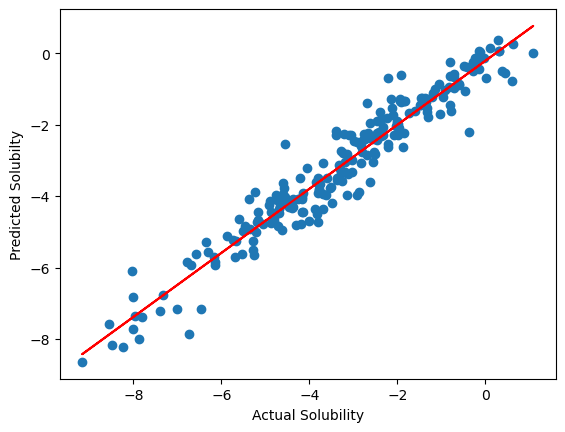

In [25]:
# Scatter PLot
plt.scatter(x = y_test, y = y_pred)

# Add Trendline on matplotlib scatter plot
z = np.polyfit(y_test, y_pred, 1)
p = np.poly1d(z)
plt.plot(y_test, p(y_test), 'r')

# Add x,y labels
plt.xlabel('Actual Solubility')
plt.ylabel('Predicted Solubilty')

### GridSearchCV

In [26]:
param_grid={'n_estimators':[100, 200, 500, 1000],
            'max_features':[ 'sqrt', 'log2'],
            'max_depth':[4,5,6,7,8],
            'criterion':['squared_error','absolute_error']}

GSCV = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
GSCV.fit(X_train, y_train)
GSCV.best_params_ 

Fitting 5 folds for each of 80 candidates, totalling 400 fits


{'criterion': 'squared_error',
 'max_depth': 8,
 'max_features': 'sqrt',
 'n_estimators': 100}

In [27]:
GSCV_best=GSCV.best_estimator_
print('Best Score:', GSCV_best.score(X_test,y_test))

Best Score: 0.9039817136440258


In [28]:
y_predict=GSCV_best.predict(X_test)

In [29]:
print('R2 score:', r2_score(y_test,y_predict))
print('MSE:', mean_squared_error(y_test, y_predict))
print('MAE:', mean_absolute_error(y_test, y_predict))

R2 score: 0.9039817136440258
MSE: 0.4286580544686476
MAE: 0.49992762863043383


Text(0, 0.5, 'Predicted Solubilty')

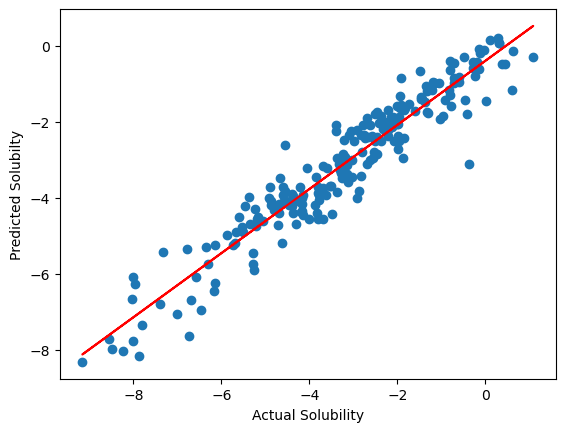

In [30]:
# Scatter PLot
plt.scatter(x = y_test, y = y_predict)

# Add Trendline on matplotlib scatter plot
z = np.polyfit(y_test, y_predict, 1)
p = np.poly1d(z)
plt.plot(y_test, p(y_test), 'r')

# Add x,y labels
plt.xlabel('Actual Solubility')
plt.ylabel('Predicted Solubilty')

### Test model on MAP Kinase ERK2 

### Get PADEL descriptors for erk2 actives and predict solubility

In [31]:
padeldescriptor(mol_dir='Va_murcko.smi', d_file='erk2-desc.csv', d_2d=True, d_3d=True, maxruntime=10000, waitingjobs=10)

RuntimeError: PaDEL-Descriptor encountered an error: Exception in thread "Thread-200" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-247" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-253" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-254" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-286" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-292" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-293" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-358" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-364" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-365" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-191" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-199" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-509" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-508" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-502" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-437" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-436" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-430" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-580" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-581" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-574" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-646" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-653" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-652" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-869" Exception in thread "Thread-868" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-718" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-724" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-725" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-790" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-796" Exception in thread "Thread-797" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-862" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-941" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-940" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-934" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-1085" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-1084" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-1078" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-1006" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-1012" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-1013" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-1157" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-1156" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-1150" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-1229" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-1228" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-1222" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-1301" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-1300" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-1294" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-1445" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-1438" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-1373" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-1372" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-1366" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-1444" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-1589" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-1582" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-1517" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-1516" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-1510" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-1588" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-1661" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-1660" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-1654" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-1805" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-1804" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-1798" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-1734" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-1733" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-1727" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-1877" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-1870" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-1876" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-1949" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-1948" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-1942" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-2021" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-2020" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-2014" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-2093" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-2092" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-2086" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-2165" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-2164" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-2158" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-2237" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-2236" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-2230" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-2309" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-2308" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-2302" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-2453" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-2452" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-2446" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-2374" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-2380" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-2381" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-2518" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-2524" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-2525" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-2669" Exception in thread "Thread-2670" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-2734" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-2740" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-2741" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-2663" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-2591" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-2597" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-2598" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-2885" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-2884" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-2878" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-2813" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-2812" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-2806" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-2956" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-2957" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-2950" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-3022" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-3029" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-3028" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-3101" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-3094" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-3100" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-3173" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-3172" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-3166" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-3244" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-3238" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-3245" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-3389" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-3388" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-3382" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-3317" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-3316" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-3310" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-3533" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-3532" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-3526" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-3461" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-3460" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-3454" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-3749" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-3748" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-3742" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-3677" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-3676" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-3670" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-3605" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-3604" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-3598" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-3965" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-3964" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-3958" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-3893" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-3892" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-3886" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-3821" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-3820" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-3814" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-4109" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-4108" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-4102" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-4037" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-4036" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-4030" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-4253" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-4252" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-4246" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-4181" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-4180" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-4174" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-4325" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-4324" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-4318" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-4469" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-4468" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-4462" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-4397" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-4396" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-4390" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-4541" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-4540" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-4534" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-4613" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-4612" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-4606" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-4756" Exception in thread "Thread-4757" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-4750" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-4685" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-4684" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-4678" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-4973" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-4972" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-4966" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-4901" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-4900" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-4894" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-4829" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-4828" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-4822" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-5044" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-5045" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-5038" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-5261" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-5260" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-5254" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-5333" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-5332" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-5326" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-5189" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-5188" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-5182" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-5117" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-5116" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-5110" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-5549" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-5548" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-5542" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-5477" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-5476" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-5470" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-5405" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-5404" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-5398" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-5621" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-5620" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-5614" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-5837" Exception in thread "Thread-5836" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-5830" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-5765" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-5764" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-5758" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-5693" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-5692" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-5686" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-5909" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-5908" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-5902" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-6124" Exception in thread "Thread-6125" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-6118" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-6053" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-6052" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-6046" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-5981" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-5980" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-5974" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-6341" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-6340" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-6334" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-6269" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-6268" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-6262" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-6197" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-6196" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-6190" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-6557" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-6556" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-6550" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-6485" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-6482" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-6470" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-6484" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-6483" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-6471" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-6773" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-6772" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-6766" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-6700" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-6701" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-6694" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-6629" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-6628" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-6622" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-6917" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-6916" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-6910" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-6845" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-6844" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-6838" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-6988" Exception in thread "Thread-6989" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-6982" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-7061" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-7060" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-7054" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-7349" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-7348" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-7342" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-7277" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-7276" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-7270" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-7205" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-7204" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-7198" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-7133" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-7132" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-7126" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-7420" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-7421" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-7414" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-7709" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-7708" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-7702" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-7637" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-7636" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-7630" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-7565" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-7564" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-7558" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-7493" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-7492" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-7486" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-7925" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-7924" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-7918" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-7853" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-7852" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-7846" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-7781" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-7780" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-7774" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-8213" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-8212" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-8206" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-8141" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-8140" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-8134" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-8069" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-8068" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-8062" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-7997" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-7996" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-7990" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-8429" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-8428" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-8422" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-8357" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-8356" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-8350" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-8285" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-8284" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-8278" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-8717" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-8716" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-8710" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-8645" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-8644" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-8638" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-8573" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-8572" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-8566" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-8501" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-8500" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-8494" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-8789" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-8788" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-8782" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-9004" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-9005" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-8998" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-8933" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-8932" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-8926" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-8861" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-8860" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-8854" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-9221" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-9220" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-9214" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-9149" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-9148" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-9142" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-9077" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-9076" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-9070" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-9430" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-9365" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-9364" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-9358" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-9293" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-9292" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-9286" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-9437" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-9436" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-9502" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-9508" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-9509" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-9796" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-9797" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-9790" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-9725" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-9724" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-9718" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-9652" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-9653" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-9646" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-9581" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-9580" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-9574" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-10012" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-10013" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-10006" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-9941" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-9940" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-9934" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-9868" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-9869" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-9862" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-10301" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-10300" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-10294" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-10229" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-10228" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-10222" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-10085" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-10084" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-10078" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-10156" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-10157" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-10150" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-10588" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-10589" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-10582" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-10517" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-10516" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-10510" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-10421" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-10409" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-10398" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-10445" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-10444" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-10438" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-10733" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-10732" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-10726" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-10661" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-10660" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-10654" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-10877" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-10876" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-10870" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-10805" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-10804" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-10798" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-10949" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-10948" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-10942" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-11165" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-11164" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-11158" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-11093" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-11092" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-11086" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-11021" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-11020" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-11014" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-11353" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-11345" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-11381" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-11380" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-11334" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-11374" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-11237" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-11236" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-11230" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-11453" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-11452" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-11446" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-11597" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-11595" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-11582" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-11669" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-11668" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-11662" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-11596" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-11583" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-11594" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-11812" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-11813" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-11806" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-11741" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-11740" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-11734" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-12029" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-12028" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-12022" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-11957" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-11956" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-11950" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-11885" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-11884" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-11878" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-12245" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-12244" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-12238" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-12173" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-12172" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-12166" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-12101" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-12100" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-12094" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-12533" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-12532" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-12526" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-12461" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-12460" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-12454" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-12389" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-12388" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-12382" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-12317" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-12316" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-12310" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-12749" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-12748" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-12742" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-12677" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-12676" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-12670" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-12605" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-12604" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-12598" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-12821" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-12820" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-12814" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-12965" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-12964" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-12958" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-12893" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-12892" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-12886" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-13181" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-13180" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-13174" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-13109" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-13108" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-13102" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-13037" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-13036" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-13030" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-13468" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-13469" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-13462" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-13397" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-13396" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-13390" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-13325" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-13324" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-13318" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-13253" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-13252" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-13246" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-13757" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-13756" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-13750" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-13685" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-13684" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-13678" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-13613" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-13612" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-13606" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-13541" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-13540" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-13534" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-13901" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-13900" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-13894" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-13829" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-13828" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-13822" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-13973" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-13972" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-13966" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-14261" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-14260" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-14254" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-14189" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-14188" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-14182" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-14117" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-14116" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-14110" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-14045" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-14044" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-14038" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-14326" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-14332" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-14333" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-14549" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-14548" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-14542" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-14477" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-14476" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-14470" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-14405" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-14404" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-14398" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-14614" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-14620" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-14621" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-14687" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-14694" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-14758" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-14693" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-14837" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-14836" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-14830" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-14765" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-14764" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-15124" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-14902" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-15125" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-14908" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-14909" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-14974" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-14980" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-14981" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-15046" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-15053" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-15052" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-15118" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-15412" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-15406" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-15341" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-15340" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-15334" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-15269" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-15268" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-15262" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-15197" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-15196" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-15190" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-15413" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-15478" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-15484" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-15485" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-15550" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-15556" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-15557" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-15773" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-15772" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-15766" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-15701" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-15700" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-15694" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-15629" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-15628" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-15622" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-15988" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-15989" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-15917" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-15916" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-15910" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-16061" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-16060" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-16054" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-15845" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-15844" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-15838" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-15982" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-16126" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-16132" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-16133" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-16198" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-16204" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-16205" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-16349" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-16348" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-16342" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-16276" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-16277" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-16270" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-16637" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-16636" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-16630" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-16628" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-16627" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-16621" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-16493" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-16492" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-16486" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-16421" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-16420" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-16414" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-16709" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-16708" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-16702" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-16997" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-16996" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-16990" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-16925" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-16924" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-16918" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-16853" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-16852" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-16846" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-16781" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-16780" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-16774" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-17285" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-17284" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-17278" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-17213" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-17212" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-17206" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-17141" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-17140" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-17134" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-17069" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-17068" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-17062" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-17350" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-17356" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-17357" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-17573" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-17572" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-17566" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-17501" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-17500" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-17494" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-17429" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-17428" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-17422" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-17717" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-17716" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-17710" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-17645" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-17644" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-17638" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-18005" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-18004" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-17998" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-17933" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-17932" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-17926" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-17861" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-17860" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-17789" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-17788" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-17782" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-17854" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-18149" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-18148" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-18142" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-18077" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-18076" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-18070" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-18293" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-18292" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-18286" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-18221" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-18220" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-18214" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-18509" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-18508" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-18502" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-18437" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-18436" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-18430" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-18365" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-18364" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-18358" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-18725" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-18724" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-18718" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-18653" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-18652" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-18646" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-18581" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-18580" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-18574" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-19013" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-19012" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-19006" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-18941" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-18940" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-18934" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-18869" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-18868" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-18862" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-18797" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-18796" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-18790" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-19157" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-19156" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-19150" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-19229" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-19228" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-19222" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-19085" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-19084" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-19078" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-19373" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-19372" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-19366" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-19516" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-19517" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-19510" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-19445" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-19444" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-19438" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-19301" Exception in thread "Thread-19300" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-19294" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-19805" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-19804" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-19798" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-19733" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-19732" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-19726" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-19589" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-19588" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-19582" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-19661" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-19660" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-19654" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-19877" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-19876" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-19870" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-20092" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-20086" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-20021" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-20020" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-20014" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-19949" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-19948" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-19942" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-20093" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-20165" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-20164" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-20158" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-20230" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-20302" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-20308" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-20309" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-20237" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-20236" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-20453" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-20452" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-20446" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-20381" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-20380" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-20374" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-20597" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-20596" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-20590" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-20525" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-20524" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-20518" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-20662" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-20668" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-20669" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-20885" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-20884" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-20878" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-20813" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-20812" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-20806" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-20741" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-20740" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-20734" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-21029" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-21028" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-21022" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-20957" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-20956" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-20950" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-21173" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-21172" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-21166" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-21101" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-21100" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-21094" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-21245" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-21244" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-21238" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-21533" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-21532" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-21526" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-21461" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-21460" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-21454" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-21389" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-21388" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-21382" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-21317" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-21316" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-21310" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-21598" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-21604" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-21605" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-21670" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-21676" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-21821" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-21820" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-21814" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-21749" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-21748" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-21742" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-21677" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-22109" Exception in thread "Thread-22108" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-22102" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-22037" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-22036" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-22030" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-21892" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-21893" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-21886" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-21965" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-21964" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-21958" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-22397" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-22396" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-22390" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-22325" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-22324" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-22318" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-22253" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-22252" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-22246" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-22181" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-22180" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-22174" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-22613" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-22612" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-22606" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-22685" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-22684" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-22678" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-22541" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-22540" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-22534" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-22469" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-22468" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-22462" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-22757" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-22756" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-22822" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-22828" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-22829" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-22750" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-22972" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-22973" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-22966" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-22901" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-22900" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-22894" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-23117" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-23116" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-23110" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-23045" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-23044" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-23038" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-23189" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-23188" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-23182" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-23269" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-23262" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-23255" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-23333" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-23332" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-23326" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-23477" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-23476" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-23470" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-23405" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-23404" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-23398" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-23693" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-23692" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-23686" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-23621" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-23620" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-23614" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-23549" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-23548" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-23542" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-23758" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-23909" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-23908" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-23902" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-23837" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-23836" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-23830" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-23765" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-23764" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-23981" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-23980" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-23974" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-24053" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-24052" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-24046" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-24268" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-24269" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-24262" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-24197" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-24196" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-24190" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-24125" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-24124" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-24118" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-24334" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-24340" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-24341" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-24557" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-24556" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-24550" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-24485" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-24484" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-24478" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-24413" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-24412" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-24406" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-24701" Exception in thread "Thread-24700" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-24694" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-24628" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-24629" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-24622" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-24773" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-24772" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-24766" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-24910" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-24916" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-24917" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-25061" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-25060" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-25054" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-24989" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-24988" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-24982" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-24845" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-24844" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-24838" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-25348" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-25349" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-25342" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-25277" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-25276" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-25270" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-25205" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-25204" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-25198" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-25133" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-25132" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-25126" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-25414" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-25420" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-25421" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-25708" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-25709" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-25486" Exception in thread "Thread-25492" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-25493" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-25558" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-25564" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-25565" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-25630" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-25636" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-25637" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-25702" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-25774" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-25780" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-25781" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-25997" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-25996" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-25990" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-25925" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-25924" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-25918" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-25853" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-25852" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-25846" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-26213" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-26212" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-26206" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-26141" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-26140" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-26134" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-26069" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-26068" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-26062" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-26357" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-26356" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-26350" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-26285" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-26284" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-26278" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-26572" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-26501" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-26500" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-26494" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-26429" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-26428" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-26422" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-26566" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-26573" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-26717" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-26716" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-26710" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-26644" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-26645" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-26638" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-26861" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-26860" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-26854" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-26789" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-26788" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-26782" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-27005" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-27004" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-26998" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-26933" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-26932" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-26926" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-27077" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-27076" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-27070" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-27364" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-27142" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-27148" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-27149" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-27216" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-27223" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-27222" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-27286" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-27292" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-27293" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-27358" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-27365" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-27436" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-27437" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-27430" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-27653" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-27652" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-27646" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-27581" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-27580" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-27574" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-27509" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-27508" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-27502" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-27724" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-27725" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-27718" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-27797" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-27796" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-27790" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-27869" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-27868" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-27862" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-27941" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-27940" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-27934" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-28013" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-28012" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-28006" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-28229" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-28228" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-28222" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-28157" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-28156" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-28150" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-28085" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-28084" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-28078" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-28445" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-28444" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-28438" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-28373" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-28372" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-28366" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-28301" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-28300" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-28294" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-28517" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-28516" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-28510" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-28660" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-28661" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-28654" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-28589" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-28588" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-28582" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-28805" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-28804" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-28798" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-28733" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-28732" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-28726" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-28948" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-28949" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-28942" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-28877" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-28876" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-28870" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-29020" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-29021" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-29014" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-29092" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-29093" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-29086" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-29165" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-29164" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-29158" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-29237" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-29236" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-29230" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-29525" Exception in thread "Thread-29524" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-29518" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-29453" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-29452" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-29446" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-29381" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-29380" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-29374" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-29309" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-29308" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-29302" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-29669" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-29668" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-29662" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-29596" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-29597" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-29590" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-29885" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-29884" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-29878" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-29813" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-29812" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-29806" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-29741" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-29740" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-29734" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-30173" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-30172" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-30166" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-30100" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-30101" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-30094" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-29957" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-29956" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-29950" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-30029" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-30028" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-30022" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-30461" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-30460" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-30454" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-30389" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-30388" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-30382" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-30245" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-30244" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-30238" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-30317" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-30316" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-30310" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-30605" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-30604" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-30598" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-30533" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-30532" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-30526" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-30677" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-30676" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-30670" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-30839" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-30838" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-30832" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-30750" Exception in thread "Thread-30749" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-30743" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-30893" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-30892" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-30886" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-31109" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-31108" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-31102" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-31037" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-31036" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-31030" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-30965" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-30964" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-30958" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-31174" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-31180" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-31181" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-31397" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-31396" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-31390" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-31325" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-31324" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-31318" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-31253" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-31252" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-31246" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-31469" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-31468" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-31462" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-31685" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-31684" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-31678" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-31613" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-31612" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-31606" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-31541" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-31540" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-31534" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-31829" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-31828" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-31822" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-31757" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-31756" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-31750" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-32044" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-32038" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-31973" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-31972" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-31966" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-31901" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-31900" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-31894" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-32045" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-32333" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-32332" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-32326" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-32261" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-32260" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-32254" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-32189" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-32187" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-32175" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-32188" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-32186" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-32174" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-32405" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-32404" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-32398" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-32470" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-32476" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-32477" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-32693" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-32692" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-32686" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-32549" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-32548" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-32542" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-32621" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-32620" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-32614" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-32765" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-32764" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-32758" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-33053" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-33052" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-33046" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-32981" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-32980" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-32974" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-32909" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-32908" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-32902" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-32837" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-32836" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-32830" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-33269" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-33268" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-33262" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-33197" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-33196" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-33190" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-33125" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-33124" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-33118" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-33485" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-33484" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-33478" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-33413" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-33412" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-33341" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-33340" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-33334" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-33406" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-33557" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-33556" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-33550" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-33773" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-33772" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-33766" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-33701" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-33700" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-33694" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-33629" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-33628" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-33622" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-33916" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-33917" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-33910" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-33989" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-33988" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-33982" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-33845" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-33844" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-33838" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-34133" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-34132" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-34126" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-34061" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-34060" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-34054" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-34205" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-34204" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-34198" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-34348" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-34349" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-34342" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-34277" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-34276" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-34270" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-34493" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-34492" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-34486" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-34421" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-34420" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-34414" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-34564" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-34565" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-34558" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-34637" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-34636" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-34630" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-34709" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-34708" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-34702" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-34781" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-34780" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-34774" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-34924" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-34925" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-34918" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-34853" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-34852" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-34846" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-34997" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-34996" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-34990" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-35141" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-35140" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-35134" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-35069" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-35068" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-35062" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-35285" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-35284" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-35278" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-35213" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-35212" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-35206" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-35356" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-35357" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-35350" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-35573" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-35572" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-35566" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-35501" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-35500" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-35494" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-35429" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-35428" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-35422" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-35789" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-35788" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-35782" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-35861" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-35860" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-35854" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-35717" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-35716" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-35710" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-35645" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-35644" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-35638" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-35933" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-35932" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-35926" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-36076" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-36077" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-36070" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-36005" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-36004" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-35998" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-36149" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-36148" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-36142" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-36220" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-36437" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-36436" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-36430" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-36221" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-36214" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-36365" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-36364" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-36358" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-36293" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-36292" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-36286" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-36509" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-36508" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-36502" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-36725" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-36724" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-36718" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-36653" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-36652" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-36646" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-36580" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-36581" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-36574" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-36796" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-36797" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-36790" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-37084" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-37085" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-37078" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-37013" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-37012" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-37006" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-36941" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-36940" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-36934" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-36869" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-36868" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-36862" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-37301" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-37300" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-37294" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-37229" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-37228" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-37222" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-37157" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-37156" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-37150" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-37366" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-37372" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-37438" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-37445" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-37444" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-37373" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-37589" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-37588" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-37582" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-37517" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-37516" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-37510" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-37654" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-37660" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-37661" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-37877" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-37876" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-37870" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-37805" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-37804" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-37798" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-37733" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-37732" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-37726" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-37949" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-37948" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-37942" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-38165" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-38164" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-38158" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-38021" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-38020" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-38014" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-38093" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-38092" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-38086" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-38452" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-38446" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-38381" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-38380" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-38374" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-38309" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-38308" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-38302" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-38237" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-38236" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-38230" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-38453" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-38525" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-38524" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-38518" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-38741" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-38740" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-38734" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-38597" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-38596" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-38590" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-38669" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-38668" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-38662" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-38813" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-38812" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-38806" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-38957" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-38956" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-38950" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-38885" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-38884" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-38878" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-39029" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-39028" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-39022" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-39159" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-39170" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-39172" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-39317" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-39316" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-39310" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-39245" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-39244" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-39238" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-39173" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-39171" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-39158" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-39605" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-39604" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-39598" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-39533" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-39532" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-39526" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-39461" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-39460" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-39454" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-39389" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-39388" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-39382" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-39676" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-39677" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-39670" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-39821" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-39820" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-39814" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-39749" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-39748" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-39742" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-39965" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-39964" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-39958" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-39893" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-39892" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-39886" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-40037" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-40036" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-40030" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-40102" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-40108" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-40109" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-40325" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-40324" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-40318" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-40181" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-40180" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-40174" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-40253" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-40252" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-40246" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-40397" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-40396" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-40390" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-40685" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-40684" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-40678" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-40613" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-40612" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-40606" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-40541" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-40540" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-40534" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-40469" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-40468" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-40462" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-40829" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-40828" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-40822" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-40757" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-40756" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-40750" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-40901" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-40900" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-40894" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-41117" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-41116" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-41110" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-41045" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-41044" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-41038" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-40973" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-40972" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-40966" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-41189" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-41188" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-41182" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-41405" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-41404" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-41398" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-41333" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-41332" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-41326" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-41261" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-41260" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-41254" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-41477" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-41476" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-41470" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-41621" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-41620" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-41614" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-41549" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-41548" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-41542" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-41837" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-41836" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-41765" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-41764" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-41758" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-41693" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-41692" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-41686" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-41830" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-41980" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-41981" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-41974" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-41909" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-41908" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-41902" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-42053" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-42052" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-42046" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-42118" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-42124" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-42125" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-42413" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-42412" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-42406" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-42341" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-42340" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-42334" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-42269" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-42268" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-42262" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-42197" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-42196" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-42190" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-42478" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-42484" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-42485" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-42550" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-42556" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-42557" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-42701" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-42700" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-42694" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-42629" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-42628" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-42622" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-42989" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-42988" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-42982" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-42917" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-42916" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-42910" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-42845" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-42844" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-42838" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-42772" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-42766" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-42773" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-43054" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-43277" Exception in thread "Thread-43276" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-43270" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-43205" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-43204" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-43198" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-43132" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-43133" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-43126" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-43061" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-43060" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-43342" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-43348" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-43349" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-43541" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-43537" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-43521" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-43565" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-43564" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-43558" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-43421" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-43420" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-43414" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-43636" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-43637" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-43630" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-43924" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-43918" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-43853" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-43852" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-43846" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-43781" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-43780" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-43774" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-43710" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-43709" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-43703" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-43925" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-44069" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-44068" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-44062" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-43997" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-43996" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-43990" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-44213" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-44212" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-44206" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-44285" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-44284" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-44278" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-44141" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-44140" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-44134" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-44429" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-44428" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-44422" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-44357" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-44356" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-44350" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-44501" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-44500" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-44494" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-44645" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-44644" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-44638" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-44573" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-44572" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-44566" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-44716" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-44717" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-44710" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-44789" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-44788" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-44782" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-44933" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-44932" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-44926" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-44861" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-44860" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-44854" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-45077" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-45076" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-45070" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-45005" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-45004" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-44998" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-45149" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-45148" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-45142" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-45293" java.lang.NullPointerException
	at libpadeldescriptor.PaDELWHIMDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-45292" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-45286" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-45221" java.lang.NullPointerException
Exception in thread "Thread-45220" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-45214" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-45437" java.lang.NullPointerException
Exception in thread "Thread-45436" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-45430" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-45365" java.lang.NullPointerException
Exception in thread "Thread-45364" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-45358" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-45581" java.lang.NullPointerException
Exception in thread "Thread-45580" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-45574" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-45509" java.lang.NullPointerException
Exception in thread "Thread-45508" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-45502" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-45653" java.lang.NullPointerException
Exception in thread "Thread-45652" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-45646" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-45869" Exception in thread "Thread-45868" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
java.lang.NullPointerException
Exception in thread "Thread-45862" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-45797" java.lang.NullPointerException
Exception in thread "Thread-45796" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-45790" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-45725" java.lang.NullPointerException
Exception in thread "Thread-45724" java.lang.NullPointerException
	at libpadeldescriptor.RDFDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-45718" java.lang.NullPointerException
	at libpadeldescriptor.Autocorrelation3DDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)
Exception in thread "Thread-45940" java.lang.NullPointerException
Exception in thread "Thread-45941" java.lang.NullPointerException
Exception in thread "Thread-45934" java.lang.NullPointerException
Exception in thread "Thread-46157" java.lang.NullPointerException
Exception in thread "Thread-46156" java.lang.NullPointerException
Exception in thread "Thread-46150" java.lang.NullPointerException
Exception in thread "Thread-46085" java.lang.NullPointerException
Exception in thread "Thread-46084" java.lang.NullPointerException
Exception in thread "Thread-46078" java.lang.NullPointerException
Exception in thread "Thread-46013" java.lang.NullPointerException
Exception in thread "Thread-46012" java.lang.NullPointerException
Exception in thread "Thread-46006" java.lang.NullPointerException
Exception in thread "Thread-46301" java.lang.NullPointerException
Exception in thread "Thread-46300" java.lang.NullPointerException
Exception in thread "Thread-46294" java.lang.NullPointerException
Exception in thread "Thread-46229" java.lang.NullPointerException
Exception in thread "Thread-46228" java.lang.NullPointerException
Exception in thread "Thread-46222" java.lang.NullPointerException
Exception in thread "Thread-46517" java.lang.NullPointerException
Exception in thread "Thread-46445" java.lang.NullPointerException
Exception in thread "Thread-46444" java.lang.NullPointerException
Exception in thread "Thread-46438" java.lang.NullPointerException
Exception in thread "Thread-46373" java.lang.NullPointerException
Exception in thread "Thread-46372" java.lang.NullPointerException
Exception in thread "Thread-46366" java.lang.NullPointerException
Exception in thread "Thread-46516" java.lang.NullPointerException
Exception in thread "Thread-46510" java.lang.NullPointerException
Exception in thread "Thread-46661" java.lang.NullPointerException
Exception in thread "Thread-46660" java.lang.NullPointerException
Exception in thread "Thread-46654" java.lang.NullPointerException
Exception in thread "Thread-46589" java.lang.NullPointerException
Exception in thread "Thread-46588" java.lang.NullPointerException
Exception in thread "Thread-46582" java.lang.NullPointerException
Exception in thread "Thread-46804" java.lang.NullPointerException
Exception in thread "Thread-46805" java.lang.NullPointerException
Exception in thread "Thread-46798" java.lang.NullPointerException
Exception in thread "Thread-46733" java.lang.NullPointerException
Exception in thread "Thread-46732" java.lang.NullPointerException
Exception in thread "Thread-46726" java.lang.NullPointerException
Exception in thread "Thread-47093" java.lang.NullPointerException
Exception in thread "Thread-47092" java.lang.NullPointerException
Exception in thread "Thread-47086" java.lang.NullPointerException
Exception in thread "Thread-47021" java.lang.NullPointerException
Exception in thread "Thread-47020" java.lang.NullPointerException
Exception in thread "Thread-47014" java.lang.NullPointerException
Exception in thread "Thread-46949" java.lang.NullPointerException
Exception in thread "Thread-46948" java.lang.NullPointerException
Exception in thread "Thread-46942" java.lang.NullPointerException
Exception in thread "Thread-46877" java.lang.NullPointerException
Exception in thread "Thread-46876" java.lang.NullPointerException
Exception in thread "Thread-46870" java.lang.NullPointerException
Exception in thread "Thread-47230" java.lang.NullPointerException
Exception in thread "Thread-47381" java.lang.NullPointerException
Exception in thread "Thread-47380" java.lang.NullPointerException
Exception in thread "Thread-47374" java.lang.NullPointerException
Exception in thread "Thread-47309" java.lang.NullPointerException
Exception in thread "Thread-47308" java.lang.NullPointerException
Exception in thread "Thread-47302" java.lang.NullPointerException
Exception in thread "Thread-47165" java.lang.NullPointerException
Exception in thread "Thread-47164" java.lang.NullPointerException
Exception in thread "Thread-47158" java.lang.NullPointerException
Exception in thread "Thread-47237" java.lang.NullPointerException
Exception in thread "Thread-47236" java.lang.NullPointerException
Exception in thread "Thread-47669" java.lang.NullPointerException
Exception in thread "Thread-47668" java.lang.NullPointerException
Exception in thread "Thread-47662" java.lang.NullPointerException
Exception in thread "Thread-47597" java.lang.NullPointerException
Exception in thread "Thread-47596" java.lang.NullPointerException
Exception in thread "Thread-47590" java.lang.NullPointerException
Exception in thread "Thread-47525" java.lang.NullPointerException
Exception in thread "Thread-47524" java.lang.NullPointerException
Exception in thread "Thread-47518" java.lang.NullPointerException
Exception in thread "Thread-47453" java.lang.NullPointerException
Exception in thread "Thread-47452" java.lang.NullPointerException
Exception in thread "Thread-47446" java.lang.NullPointerException
Exception in thread "Thread-47956" Exception in thread "Thread-47957" java.lang.NullPointerException
java.lang.NullPointerException
Exception in thread "Thread-47950" java.lang.NullPointerException
Exception in thread "Thread-47885" java.lang.NullPointerException
Exception in thread "Thread-47884" java.lang.NullPointerException
Exception in thread "Thread-47806" java.lang.NullPointerException
Exception in thread "Thread-47879" java.lang.NullPointerException
Exception in thread "Thread-47878" java.lang.NullPointerException
Exception in thread "Thread-47872" java.lang.NullPointerException
Exception in thread "Thread-47741" java.lang.NullPointerException
Exception in thread "Thread-47740" java.lang.NullPointerException
Exception in thread "Thread-47734" java.lang.NullPointerException
Exception in thread "Thread-48244" Exception in thread "Thread-48245" java.lang.NullPointerException
java.lang.NullPointerException
Exception in thread "Thread-48238" java.lang.NullPointerException
Exception in thread "Thread-48173" java.lang.NullPointerException
Exception in thread "Thread-48172" java.lang.NullPointerException
Exception in thread "Thread-48166" java.lang.NullPointerException
Exception in thread "Thread-48101" java.lang.NullPointerException
Exception in thread "Thread-48100" java.lang.NullPointerException
Exception in thread "Thread-48094" java.lang.NullPointerException
Exception in thread "Thread-48029" java.lang.NullPointerException
Exception in thread "Thread-48028" java.lang.NullPointerException
Exception in thread "Thread-48022" java.lang.NullPointerException
Exception in thread "Thread-48461" java.lang.NullPointerException
Exception in thread "Thread-48460" java.lang.NullPointerException
Exception in thread "Thread-48454" java.lang.NullPointerException
Exception in thread "Thread-48389" java.lang.NullPointerException
Exception in thread "Thread-48388" java.lang.NullPointerException
Exception in thread "Thread-48382" java.lang.NullPointerException
Exception in thread "Thread-48317" java.lang.NullPointerException
Exception in thread "Thread-48316" java.lang.NullPointerException
Exception in thread "Thread-48310" java.lang.NullPointerException
Exception in thread "Thread-48676" Exception in thread "Thread-48677" java.lang.NullPointerException
java.lang.NullPointerException
Exception in thread "Thread-48526" java.lang.NullPointerException
Exception in thread "Thread-48532" java.lang.NullPointerException
Exception in thread "Thread-48533" java.lang.NullPointerException
Exception in thread "Thread-48598" java.lang.NullPointerException
Exception in thread "Thread-48604" java.lang.NullPointerException
Exception in thread "Thread-48605" java.lang.NullPointerException
Exception in thread "Thread-48742" java.lang.NullPointerException
Exception in thread "Thread-48748" java.lang.NullPointerException
Exception in thread "Thread-48749" java.lang.NullPointerException
Exception in thread "Thread-48670" java.lang.NullPointerException
Exception in thread "Thread-48821" java.lang.NullPointerException
Exception in thread "Thread-48820" java.lang.NullPointerException
Exception in thread "Thread-48814" java.lang.NullPointerException
Exception in thread "Thread-48886" java.lang.NullPointerException
Exception in thread "Thread-48892" java.lang.NullPointerException
Exception in thread "Thread-48893" java.lang.NullPointerException
Exception in thread "Thread-49102" java.lang.NullPointerException
Exception in thread "Thread-49098" java.lang.NullPointerException
Exception in thread "Thread-49082" java.lang.NullPointerException
Exception in thread "Thread-49109" java.lang.NullPointerException
Exception in thread "Thread-49108" java.lang.NullPointerException
Exception in thread "Thread-49101" java.lang.NullPointerException
Exception in thread "Thread-48964" java.lang.NullPointerException
Exception in thread "Thread-48965" java.lang.NullPointerException
Exception in thread "Thread-48958" java.lang.NullPointerException
Exception in thread "Thread-49325" java.lang.NullPointerException
Exception in thread "Thread-49324" java.lang.NullPointerException
Exception in thread "Thread-49318" java.lang.NullPointerException
Exception in thread "Thread-49253" java.lang.NullPointerException
Exception in thread "Thread-49252" java.lang.NullPointerException
Exception in thread "Thread-49246" java.lang.NullPointerException
Exception in thread "Thread-49181" java.lang.NullPointerException
Exception in thread "Thread-49180" java.lang.NullPointerException
Exception in thread "Thread-49174" java.lang.NullPointerException
Exception in thread "Thread-49613" java.lang.NullPointerException
Exception in thread "Thread-49612" java.lang.NullPointerException
Exception in thread "Thread-49606" java.lang.NullPointerException
Exception in thread "Thread-49541" java.lang.NullPointerException
Exception in thread "Thread-49540" java.lang.NullPointerException
Exception in thread "Thread-49534" java.lang.NullPointerException
Exception in thread "Thread-49469" java.lang.NullPointerException
Exception in thread "Thread-49468" java.lang.NullPointerException
Exception in thread "Thread-49462" java.lang.NullPointerException
Exception in thread "Thread-49397" java.lang.NullPointerException
Exception in thread "Thread-49396" java.lang.NullPointerException
Exception in thread "Thread-49390" java.lang.NullPointerException
Exception in thread "Thread-49901" java.lang.NullPointerException
Exception in thread "Thread-49900" java.lang.NullPointerException
Exception in thread "Thread-49894" java.lang.NullPointerException
Exception in thread "Thread-49829" java.lang.NullPointerException
Exception in thread "Thread-49828" java.lang.NullPointerException
Exception in thread "Thread-49822" java.lang.NullPointerException
Exception in thread "Thread-49757" java.lang.NullPointerException
Exception in thread "Thread-49756" java.lang.NullPointerException
Exception in thread "Thread-49750" java.lang.NullPointerException
Exception in thread "Thread-49685" java.lang.NullPointerException
Exception in thread "Thread-49684" java.lang.NullPointerException
Exception in thread "Thread-49678" java.lang.NullPointerException
Exception in thread "Thread-49973" java.lang.NullPointerException
Exception in thread "Thread-49972" java.lang.NullPointerException
Exception in thread "Thread-49966" java.lang.NullPointerException
Exception in thread "Thread-50261" java.lang.NullPointerException
Exception in thread "Thread-50260" java.lang.NullPointerException
Exception in thread "Thread-50254" java.lang.NullPointerException
Exception in thread "Thread-50189" java.lang.NullPointerException
Exception in thread "Thread-50188" java.lang.NullPointerException
Exception in thread "Thread-50182" java.lang.NullPointerException
Exception in thread "Thread-50117" java.lang.NullPointerException
Exception in thread "Thread-50116" java.lang.NullPointerException
Exception in thread "Thread-50110" java.lang.NullPointerException
Exception in thread "Thread-50045" java.lang.NullPointerException
Exception in thread "Thread-50044" java.lang.NullPointerException
Exception in thread "Thread-50038" java.lang.NullPointerException
Exception in thread "Thread-50333" java.lang.NullPointerException
Exception in thread "Thread-50332" java.lang.NullPointerException
Exception in thread "Thread-50326" java.lang.NullPointerException
Exception in thread "Thread-50470" java.lang.NullPointerException
Exception in thread "Thread-50477" java.lang.NullPointerException
Exception in thread "Thread-50476" java.lang.NullPointerException
Exception in thread "Thread-50549" java.lang.NullPointerException
Exception in thread "Thread-50548" java.lang.NullPointerException
Exception in thread "Thread-50542" java.lang.NullPointerException
Exception in thread "Thread-50405" java.lang.NullPointerException
Exception in thread "Thread-50404" java.lang.NullPointerException
Exception in thread "Thread-50398" java.lang.NullPointerException
Exception in thread "Thread-50837" java.lang.NullPointerException
Exception in thread "Thread-50836" java.lang.NullPointerException
Exception in thread "Thread-50830" java.lang.NullPointerException
Exception in thread "Thread-50614" java.lang.NullPointerException
Exception in thread "Thread-50765" java.lang.NullPointerException
Exception in thread "Thread-50764" java.lang.NullPointerException
Exception in thread "Thread-50758" java.lang.NullPointerException
Exception in thread "Thread-50693" java.lang.NullPointerException
Exception in thread "Thread-50692" java.lang.NullPointerException
Exception in thread "Thread-50686" java.lang.NullPointerException
Exception in thread "Thread-50621" java.lang.NullPointerException
Exception in thread "Thread-50620" java.lang.NullPointerException
Exception in thread "Thread-50902" java.lang.NullPointerException
Exception in thread "Thread-50908" java.lang.NullPointerException
Exception in thread "Thread-50909" java.lang.NullPointerException
Exception in thread "Thread-51125" java.lang.NullPointerException
Exception in thread "Thread-51124" java.lang.NullPointerException
Exception in thread "Thread-51053" java.lang.NullPointerException
Exception in thread "Thread-51052" java.lang.NullPointerException
Exception in thread "Thread-51046" java.lang.NullPointerException
Exception in thread "Thread-50980" java.lang.NullPointerException
Exception in thread "Thread-50981" java.lang.NullPointerException
Exception in thread "Thread-50974" java.lang.NullPointerException
Exception in thread "Thread-51118" java.lang.NullPointerException
Exception in thread "Thread-51341" Exception in thread "Thread-51340" java.lang.NullPointerException
java.lang.NullPointerException
Exception in thread "Thread-51334" java.lang.NullPointerException
Exception in thread "Thread-51269" java.lang.NullPointerException
Exception in thread "Thread-51268" java.lang.NullPointerException
Exception in thread "Thread-51262" java.lang.NullPointerException
Exception in thread "Thread-51197" java.lang.NullPointerException
Exception in thread "Thread-51196" java.lang.NullPointerException
Exception in thread "Thread-51190" java.lang.NullPointerException
Exception in thread "Thread-51413" java.lang.NullPointerException
Exception in thread "Thread-51412" java.lang.NullPointerException
Exception in thread "Thread-51406" java.lang.NullPointerException
Exception in thread "Thread-51485" java.lang.NullPointerException
Exception in thread "Thread-51484" java.lang.NullPointerException
Exception in thread "Thread-51478" java.lang.NullPointerException
Exception in thread "Thread-51701" java.lang.NullPointerException
Exception in thread "Thread-51700" java.lang.NullPointerException
Exception in thread "Thread-51694" java.lang.NullPointerException
Exception in thread "Thread-51629" java.lang.NullPointerException
Exception in thread "Thread-51628" java.lang.NullPointerException
Exception in thread "Thread-51622" java.lang.NullPointerException
Exception in thread "Thread-51557" java.lang.NullPointerException
Exception in thread "Thread-51556" java.lang.NullPointerException
Exception in thread "Thread-51550" java.lang.NullPointerException
Exception in thread "Thread-51772" java.lang.NullPointerException
Exception in thread "Thread-51766" java.lang.NullPointerException
Exception in thread "Thread-51773" java.lang.NullPointerException
Exception in thread "Thread-51917" java.lang.NullPointerException
Exception in thread "Thread-51916" java.lang.NullPointerException
Exception in thread "Thread-51910" java.lang.NullPointerException
Exception in thread "Thread-51845" java.lang.NullPointerException
Exception in thread "Thread-51844" java.lang.NullPointerException
Exception in thread "Thread-51838" java.lang.NullPointerException
Exception in thread "Thread-51982" java.lang.NullPointerException
Exception in thread "Thread-51988" Exception in thread "Thread-51989" java.lang.NullPointerException
java.lang.NullPointerException
Exception in thread "Thread-52205" java.lang.NullPointerException
Exception in thread "Thread-52204" java.lang.NullPointerException
Exception in thread "Thread-52198" java.lang.NullPointerException
Exception in thread "Thread-52133" java.lang.NullPointerException
Exception in thread "Thread-52132" java.lang.NullPointerException
Exception in thread "Thread-52126" java.lang.NullPointerException
Exception in thread "Thread-52061" java.lang.NullPointerException
Exception in thread "Thread-52060" java.lang.NullPointerException
Exception in thread "Thread-52054" java.lang.NullPointerException
Exception in thread "Thread-52421" java.lang.NullPointerException
Exception in thread "Thread-52420" java.lang.NullPointerException
Exception in thread "Thread-52414" java.lang.NullPointerException
Exception in thread "Thread-52349" java.lang.NullPointerException
Exception in thread "Thread-52348" java.lang.NullPointerException
Exception in thread "Thread-52342" java.lang.NullPointerException
Exception in thread "Thread-52277" java.lang.NullPointerException
Exception in thread "Thread-52276" java.lang.NullPointerException
Exception in thread "Thread-52270" java.lang.NullPointerException
Exception in thread "Thread-52637" java.lang.NullPointerException
Exception in thread "Thread-52636" java.lang.NullPointerException
Exception in thread "Thread-52630" java.lang.NullPointerException
Exception in thread "Thread-52565" java.lang.NullPointerException
Exception in thread "Thread-52564" java.lang.NullPointerException
Exception in thread "Thread-52558" java.lang.NullPointerException
Exception in thread "Thread-52493" java.lang.NullPointerException
Exception in thread "Thread-52492" java.lang.NullPointerException
Exception in thread "Thread-52486" java.lang.NullPointerException
Exception in thread "Thread-52708" Exception in thread "Thread-52709" java.lang.NullPointerException
java.lang.NullPointerException
Exception in thread "Thread-52702" java.lang.NullPointerException
Exception in thread "Thread-52925" Exception in thread "Thread-52924" java.lang.NullPointerException
java.lang.NullPointerException
Exception in thread "Thread-52918" java.lang.NullPointerException
Exception in thread "Thread-52853" java.lang.NullPointerException
Exception in thread "Thread-52852" java.lang.NullPointerException
Exception in thread "Thread-52846" java.lang.NullPointerException
Exception in thread "Thread-52781" java.lang.NullPointerException
Exception in thread "Thread-52780" java.lang.NullPointerException
Exception in thread "Thread-52774" java.lang.NullPointerException
Exception in thread "Thread-53134" java.lang.NullPointerException
Exception in thread "Thread-53069" java.lang.NullPointerException
Exception in thread "Thread-53068" java.lang.NullPointerException
Exception in thread "Thread-53062" java.lang.NullPointerException
Exception in thread "Thread-52997" java.lang.NullPointerException
Exception in thread "Thread-52996" java.lang.NullPointerException
Exception in thread "Thread-52990" java.lang.NullPointerException
Exception in thread "Thread-53141" java.lang.NullPointerException
Exception in thread "Thread-53140" java.lang.NullPointerException
Exception in thread "Thread-53429" java.lang.NullPointerException
Exception in thread "Thread-53428" java.lang.NullPointerException
Exception in thread "Thread-53422" java.lang.NullPointerException
Exception in thread "Thread-53357" java.lang.NullPointerException
Exception in thread "Thread-53356" java.lang.NullPointerException
Exception in thread "Thread-53350" java.lang.NullPointerException
Exception in thread "Thread-53285" java.lang.NullPointerException
Exception in thread "Thread-53284" java.lang.NullPointerException
Exception in thread "Thread-53278" java.lang.NullPointerException
Exception in thread "Thread-53213" java.lang.NullPointerException
Exception in thread "Thread-53212" java.lang.NullPointerException
Exception in thread "Thread-53206" java.lang.NullPointerException
Exception in thread "Thread-53717" java.lang.NullPointerException
Exception in thread "Thread-53716" java.lang.NullPointerException
Exception in thread "Thread-53710" java.lang.NullPointerException
Exception in thread "Thread-53573" java.lang.NullPointerException
Exception in thread "Thread-53572" java.lang.NullPointerException
Exception in thread "Thread-53566" java.lang.NullPointerException
Exception in thread "Thread-53501" java.lang.NullPointerException
Exception in thread "Thread-53500" java.lang.NullPointerException
Exception in thread "Thread-53494" java.lang.NullPointerException
Exception in thread "Thread-53644" java.lang.NullPointerException
Exception in thread "Thread-53645" java.lang.NullPointerException
Exception in thread "Thread-53638" java.lang.NullPointerException
Exception in thread "Thread-53861" java.lang.NullPointerException
Exception in thread "Thread-53860" java.lang.NullPointerException
Exception in thread "Thread-53854" java.lang.NullPointerException
Exception in thread "Thread-53789" java.lang.NullPointerException
Exception in thread "Thread-53788" java.lang.NullPointerException
Exception in thread "Thread-53782" java.lang.NullPointerException
Exception in thread "Thread-53933" java.lang.NullPointerException
Exception in thread "Thread-53932" java.lang.NullPointerException
Exception in thread "Thread-53926" java.lang.NullPointerException
Exception in thread "Thread-54005" java.lang.NullPointerException
Exception in thread "Thread-54004" java.lang.NullPointerException
Exception in thread "Thread-53998" java.lang.NullPointerException
Exception in thread "Thread-54077" Exception in thread "Thread-54076" java.lang.NullPointerException
java.lang.NullPointerException
Exception in thread "Thread-54070" java.lang.NullPointerException
Exception in thread "Thread-54148" Exception in thread "Thread-54149" java.lang.NullPointerException
java.lang.NullPointerException
Exception in thread "Thread-54142" java.lang.NullPointerException
Exception in thread "Thread-54365" java.lang.NullPointerException
Exception in thread "Thread-54364" java.lang.NullPointerException
Exception in thread "Thread-54358" java.lang.NullPointerException
Exception in thread "Thread-54221" java.lang.NullPointerException
Exception in thread "Thread-54220" java.lang.NullPointerException
Exception in thread "Thread-54214" java.lang.NullPointerException
Exception in thread "Thread-54293" java.lang.NullPointerException
Exception in thread "Thread-54292" java.lang.NullPointerException
Exception in thread "Thread-54286" java.lang.NullPointerException
Exception in thread "Thread-54653" java.lang.NullPointerException
Exception in thread "Thread-54652" java.lang.NullPointerException
Exception in thread "Thread-54646" java.lang.NullPointerException
Exception in thread "Thread-54581" java.lang.NullPointerException
Exception in thread "Thread-54580" java.lang.NullPointerException
Exception in thread "Thread-54574" java.lang.NullPointerException
Exception in thread "Thread-54437" java.lang.NullPointerException
Exception in thread "Thread-54436" java.lang.NullPointerException
Exception in thread "Thread-54509" java.lang.NullPointerException
Exception in thread "Thread-54508" java.lang.NullPointerException
Exception in thread "Thread-54502" java.lang.NullPointerException
Exception in thread "Thread-54430" java.lang.NullPointerException
Exception in thread "Thread-54796" java.lang.NullPointerException
Exception in thread "Thread-54797" java.lang.NullPointerException
Exception in thread "Thread-54790" java.lang.NullPointerException
Exception in thread "Thread-54725" java.lang.NullPointerException
Exception in thread "Thread-54724" java.lang.NullPointerException
Exception in thread "Thread-54718" java.lang.NullPointerException
Exception in thread "Thread-55013" Exception in thread "Thread-55012" java.lang.NullPointerException
java.lang.NullPointerException
Exception in thread "Thread-55006" java.lang.NullPointerException
Exception in thread "Thread-54941" java.lang.NullPointerException
Exception in thread "Thread-54940" java.lang.NullPointerException
Exception in thread "Thread-54934" java.lang.NullPointerException
Exception in thread "Thread-54869" Exception in thread "Thread-54868" java.lang.NullPointerException
java.lang.NullPointerException
Exception in thread "Thread-54862" java.lang.NullPointerException
Exception in thread "Thread-55084" Exception in thread "Thread-55085" java.lang.NullPointerException
java.lang.NullPointerException
Exception in thread "Thread-55078" java.lang.NullPointerException
Exception in thread "Thread-55372" Exception in thread "Thread-55373" java.lang.NullPointerException
java.lang.NullPointerException
Exception in thread "Thread-55366" java.lang.NullPointerException
Exception in thread "Thread-55301" java.lang.NullPointerException
Exception in thread "Thread-55300" java.lang.NullPointerException
Exception in thread "Thread-55294" java.lang.NullPointerException
Exception in thread "Thread-55229" java.lang.NullPointerException
Exception in thread "Thread-55228" java.lang.NullPointerException
Exception in thread "Thread-55222" java.lang.NullPointerException
Exception in thread "Thread-55157" java.lang.NullPointerException
Exception in thread "Thread-55156" java.lang.NullPointerException
Exception in thread "Thread-55150" java.lang.NullPointerException
Exception in thread "Thread-55517" java.lang.NullPointerException
Exception in thread "Thread-55516" java.lang.NullPointerException
Exception in thread "Thread-55510" java.lang.NullPointerException
Exception in thread "Thread-55445" java.lang.NullPointerException
Exception in thread "Thread-55444" java.lang.NullPointerException
Exception in thread "Thread-55438" java.lang.NullPointerException
Exception in thread "Thread-55804" java.lang.NullPointerException
Exception in thread "Thread-55805" java.lang.NullPointerException
Exception in thread "Thread-55798" java.lang.NullPointerException
Exception in thread "Thread-55733" java.lang.NullPointerException
Exception in thread "Thread-55732" java.lang.NullPointerException
Exception in thread "Thread-55726" java.lang.NullPointerException
Exception in thread "Thread-55661" java.lang.NullPointerException
Exception in thread "Thread-55660" java.lang.NullPointerException
Exception in thread "Thread-55654" java.lang.NullPointerException
Exception in thread "Thread-55589" java.lang.NullPointerException
Exception in thread "Thread-55588" java.lang.NullPointerException
Exception in thread "Thread-55582" java.lang.NullPointerException
Exception in thread "Thread-56021" java.lang.NullPointerException
Exception in thread "Thread-56020" java.lang.NullPointerException
Exception in thread "Thread-56014" java.lang.NullPointerException
Exception in thread "Thread-55948" java.lang.NullPointerException
Exception in thread "Thread-55949" java.lang.NullPointerException
Exception in thread "Thread-55942" java.lang.NullPointerException
Exception in thread "Thread-55877" java.lang.NullPointerException
Exception in thread "Thread-55876" java.lang.NullPointerException
Exception in thread "Thread-55870" java.lang.NullPointerException
Exception in thread "Thread-56093" java.lang.NullPointerException
Exception in thread "Thread-56092" java.lang.NullPointerException
Exception in thread "Thread-56086" java.lang.NullPointerException
Exception in thread "Thread-56237" java.lang.NullPointerException
Exception in thread "Thread-56236" java.lang.NullPointerException
Exception in thread "Thread-56230" java.lang.NullPointerException
Exception in thread "Thread-56165" java.lang.NullPointerException
Exception in thread "Thread-56164" java.lang.NullPointerException
Exception in thread "Thread-56158" java.lang.NullPointerException
Exception in thread "Thread-56381" java.lang.NullPointerException
Exception in thread "Thread-56380" java.lang.NullPointerException
Exception in thread "Thread-56374" java.lang.NullPointerException
Exception in thread "Thread-56308" java.lang.NullPointerException
Exception in thread "Thread-56309" java.lang.NullPointerException
Exception in thread "Thread-56302" java.lang.NullPointerException
Exception in thread "Thread-56453" java.lang.NullPointerException
Exception in thread "Thread-56452" java.lang.NullPointerException
Exception in thread "Thread-56446" java.lang.NullPointerException
Exception in thread "Thread-56525" java.lang.NullPointerException
Exception in thread "Thread-56524" java.lang.NullPointerException
Exception in thread "Thread-56518" java.lang.NullPointerException
Exception in thread "Thread-56669" java.lang.NullPointerException
Exception in thread "Thread-56668" java.lang.NullPointerException
Exception in thread "Thread-56662" java.lang.NullPointerException
Exception in thread "Thread-56597" java.lang.NullPointerException
Exception in thread "Thread-56596" java.lang.NullPointerException
Exception in thread "Thread-56590" java.lang.NullPointerException
Exception in thread "Thread-56741" java.lang.NullPointerException
Exception in thread "Thread-56740" java.lang.NullPointerException
Exception in thread "Thread-56734" java.lang.NullPointerException
Exception in thread "Thread-56813" java.lang.NullPointerException
Exception in thread "Thread-56812" java.lang.NullPointerException
Exception in thread "Thread-56806" java.lang.NullPointerException
Exception in thread "Thread-56957" java.lang.NullPointerException
Exception in thread "Thread-56956" java.lang.NullPointerException
Exception in thread "Thread-56950" java.lang.NullPointerException
Exception in thread "Thread-56885" java.lang.NullPointerException
Exception in thread "Thread-56884" java.lang.NullPointerException
Exception in thread "Thread-56878" java.lang.NullPointerException
Exception in thread "Thread-57101" java.lang.NullPointerException
Exception in thread "Thread-57100" java.lang.NullPointerException
Exception in thread "Thread-57094" java.lang.NullPointerException
Exception in thread "Thread-57029" java.lang.NullPointerException
Exception in thread "Thread-57028" java.lang.NullPointerException
Exception in thread "Thread-57022" java.lang.NullPointerException
Exception in thread "Thread-57173" java.lang.NullPointerException
Exception in thread "Thread-57172" java.lang.NullPointerException
Exception in thread "Thread-57166" java.lang.NullPointerException
Exception in thread "Thread-57245" java.lang.NullPointerException
Exception in thread "Thread-57244" java.lang.NullPointerException
Exception in thread "Thread-57238" java.lang.NullPointerException
Exception in thread "Thread-57389" java.lang.NullPointerException
Exception in thread "Thread-57388" java.lang.NullPointerException
Exception in thread "Thread-57382" java.lang.NullPointerException
Exception in thread "Thread-57317" java.lang.NullPointerException
Exception in thread "Thread-57316" java.lang.NullPointerException
Exception in thread "Thread-57310" java.lang.NullPointerException
Exception in thread "Thread-57604" Exception in thread "Thread-57605" java.lang.NullPointerException
java.lang.NullPointerException
Exception in thread "Thread-57598" java.lang.NullPointerException
Exception in thread "Thread-57461" java.lang.NullPointerException
Exception in thread "Thread-57460" java.lang.NullPointerException
Exception in thread "Thread-57454" java.lang.NullPointerException
Exception in thread "Thread-57533" java.lang.NullPointerException
Exception in thread "Thread-57532" java.lang.NullPointerException
Exception in thread "Thread-57526" java.lang.NullPointerException
Exception in thread "Thread-57749" Exception in thread "Thread-57748" java.lang.NullPointerException
java.lang.NullPointerException
Exception in thread "Thread-57742" java.lang.NullPointerException
Exception in thread "Thread-57821" java.lang.NullPointerException
Exception in thread "Thread-57820" java.lang.NullPointerException
Exception in thread "Thread-57814" java.lang.NullPointerException
Exception in thread "Thread-57677" java.lang.NullPointerException
Exception in thread "Thread-57676" java.lang.NullPointerException
Exception in thread "Thread-57670" java.lang.NullPointerException
Exception in thread "Thread-58037" java.lang.NullPointerException
Exception in thread "Thread-58036" java.lang.NullPointerException
Exception in thread "Thread-58030" java.lang.NullPointerException
Exception in thread "Thread-58109" java.lang.NullPointerException
Exception in thread "Thread-58108" java.lang.NullPointerException
Exception in thread "Thread-58102" java.lang.NullPointerException
Exception in thread "Thread-57893" java.lang.NullPointerException
Exception in thread "Thread-57892" java.lang.NullPointerException
Exception in thread "Thread-57886" java.lang.NullPointerException
Exception in thread "Thread-57965" java.lang.NullPointerException
Exception in thread "Thread-57964" java.lang.NullPointerException
Exception in thread "Thread-57958" java.lang.NullPointerException
Exception in thread "Thread-58253" java.lang.NullPointerException
Exception in thread "Thread-58252" java.lang.NullPointerException
Exception in thread "Thread-58246" java.lang.NullPointerException
Exception in thread "Thread-58181" java.lang.NullPointerException
Exception in thread "Thread-58180" java.lang.NullPointerException
Exception in thread "Thread-58174" java.lang.NullPointerException
Exception in thread "Thread-58397" java.lang.NullPointerException
Exception in thread "Thread-58396" java.lang.NullPointerException
Exception in thread "Thread-58390" java.lang.NullPointerException
Exception in thread "Thread-58325" java.lang.NullPointerException
Exception in thread "Thread-58324" java.lang.NullPointerException
Exception in thread "Thread-58318" java.lang.NullPointerException
Exception in thread "Thread-58541" java.lang.NullPointerException
Exception in thread "Thread-58540" java.lang.NullPointerException
Exception in thread "Thread-58534" java.lang.NullPointerException
Exception in thread "Thread-58469" java.lang.NullPointerException
Exception in thread "Thread-58468" java.lang.NullPointerException
Exception in thread "Thread-58462" java.lang.NullPointerException
Exception in thread "Thread-58613" java.lang.NullPointerException
Exception in thread "Thread-58612" java.lang.NullPointerException
Exception in thread "Thread-58606" java.lang.NullPointerException
Exception in thread "Thread-58684" Exception in thread "Thread-58685" java.lang.NullPointerException
java.lang.NullPointerException
Exception in thread "Thread-58678" java.lang.NullPointerException
Exception in thread "Thread-58757" java.lang.NullPointerException
Exception in thread "Thread-58756" java.lang.NullPointerException
Exception in thread "Thread-58750" java.lang.NullPointerException
Exception in thread "Thread-58829" Exception in thread "Thread-58828" java.lang.NullPointerException
java.lang.NullPointerException
Exception in thread "Thread-58822" java.lang.NullPointerException
Exception in thread "Thread-58901" java.lang.NullPointerException
Exception in thread "Thread-58900" java.lang.NullPointerException
Exception in thread "Thread-58894" java.lang.NullPointerException
Exception in thread "Thread-58973" java.lang.NullPointerException
Exception in thread "Thread-58972" java.lang.NullPointerException
Exception in thread "Thread-58966" java.lang.NullPointerException
Exception in thread "Thread-59038" java.lang.NullPointerException
Exception in thread "Thread-59044" java.lang.NullPointerException
Exception in thread "Thread-59045" java.lang.NullPointerException
Exception in thread "Thread-59333" java.lang.NullPointerException
Exception in thread "Thread-59332" java.lang.NullPointerException
Exception in thread "Thread-59326" java.lang.NullPointerException
Exception in thread "Thread-59260" java.lang.NullPointerException
Exception in thread "Thread-59261" java.lang.NullPointerException
Exception in thread "Thread-59254" java.lang.NullPointerException
Exception in thread "Thread-59189" java.lang.NullPointerException
Exception in thread "Thread-59188" java.lang.NullPointerException
Exception in thread "Thread-59182" java.lang.NullPointerException
Exception in thread "Thread-59117" java.lang.NullPointerException
Exception in thread "Thread-59116" java.lang.NullPointerException
Exception in thread "Thread-59110" java.lang.NullPointerException
Exception in thread "Thread-59477" java.lang.NullPointerException
Exception in thread "Thread-59476" java.lang.NullPointerException
Exception in thread "Thread-59470" java.lang.NullPointerException
Exception in thread "Thread-59405" java.lang.NullPointerException
Exception in thread "Thread-59404" java.lang.NullPointerException
Exception in thread "Thread-59398" java.lang.NullPointerException
Exception in thread "Thread-59764" java.lang.NullPointerException
Exception in thread "Thread-59758" java.lang.NullPointerException
Exception in thread "Thread-59693" java.lang.NullPointerException
Exception in thread "Thread-59692" java.lang.NullPointerException
Exception in thread "Thread-59686" java.lang.NullPointerException
Exception in thread "Thread-59621" java.lang.NullPointerException
Exception in thread "Thread-59620" java.lang.NullPointerException
Exception in thread "Thread-59614" java.lang.NullPointerException
Exception in thread "Thread-59549" java.lang.NullPointerException
Exception in thread "Thread-59548" java.lang.NullPointerException
Exception in thread "Thread-59542" java.lang.NullPointerException
Exception in thread "Thread-59765" java.lang.NullPointerException
Exception in thread "Thread-59909" java.lang.NullPointerException
Exception in thread "Thread-59908" java.lang.NullPointerException
Exception in thread "Thread-59902" java.lang.NullPointerException
Exception in thread "Thread-59837" java.lang.NullPointerException
Exception in thread "Thread-59836" java.lang.NullPointerException
Exception in thread "Thread-59830" java.lang.NullPointerException
Exception in thread "Thread-60197" java.lang.NullPointerException
Exception in thread "Thread-60190" java.lang.NullPointerException
Exception in thread "Thread-60053" java.lang.NullPointerException
Exception in thread "Thread-60052" java.lang.NullPointerException
Exception in thread "Thread-60046" java.lang.NullPointerException
Exception in thread "Thread-60125" java.lang.NullPointerException
Exception in thread "Thread-60124" java.lang.NullPointerException
Exception in thread "Thread-60118" java.lang.NullPointerException
Exception in thread "Thread-59981" java.lang.NullPointerException
Exception in thread "Thread-59980" java.lang.NullPointerException
Exception in thread "Thread-59974" java.lang.NullPointerException
Exception in thread "Thread-60196" java.lang.NullPointerException
Exception in thread "Thread-60262" java.lang.NullPointerException
Exception in thread "Thread-60268" java.lang.NullPointerException
Exception in thread "Thread-60269" java.lang.NullPointerException
Exception in thread "Thread-60334" java.lang.NullPointerException
Exception in thread "Thread-60340" java.lang.NullPointerException
Exception in thread "Thread-60341" java.lang.NullPointerException
Exception in thread "Thread-60478" java.lang.NullPointerException
Exception in thread "Thread-60460" java.lang.NullPointerException
Exception in thread "Thread-60456" java.lang.NullPointerException
Exception in thread "Thread-60444" java.lang.NullPointerException
Exception in thread "Thread-60485" java.lang.NullPointerException
Exception in thread "Thread-60484" java.lang.NullPointerException
Exception in thread "Thread-60550" java.lang.NullPointerException
Exception in thread "Thread-60556" java.lang.NullPointerException
Exception in thread "Thread-60557" java.lang.NullPointerException
Exception in thread "Thread-60773" java.lang.NullPointerException
Exception in thread "Thread-60772" java.lang.NullPointerException
Exception in thread "Thread-60766" java.lang.NullPointerException
Exception in thread "Thread-60701" java.lang.NullPointerException
Exception in thread "Thread-60700" java.lang.NullPointerException
Exception in thread "Thread-60694" java.lang.NullPointerException
Exception in thread "Thread-60629" java.lang.NullPointerException
Exception in thread "Thread-60628" java.lang.NullPointerException
Exception in thread "Thread-60622" java.lang.NullPointerException
Exception in thread "Thread-60989" java.lang.NullPointerException
Exception in thread "Thread-60988" java.lang.NullPointerException
Exception in thread "Thread-60982" java.lang.NullPointerException
Exception in thread "Thread-60917" java.lang.NullPointerException
Exception in thread "Thread-60916" java.lang.NullPointerException
Exception in thread "Thread-60910" java.lang.NullPointerException
Exception in thread "Thread-60845" java.lang.NullPointerException
Exception in thread "Thread-60844" java.lang.NullPointerException
Exception in thread "Thread-60838" java.lang.NullPointerException
Exception in thread "Thread-61205" java.lang.NullPointerException
Exception in thread "Thread-61204" java.lang.NullPointerException
Exception in thread "Thread-61198" java.lang.NullPointerException
Exception in thread "Thread-61133" java.lang.NullPointerException
Exception in thread "Thread-61132" java.lang.NullPointerException
Exception in thread "Thread-61126" java.lang.NullPointerException
Exception in thread "Thread-61061" java.lang.NullPointerException
Exception in thread "Thread-61060" java.lang.NullPointerException
Exception in thread "Thread-61054" java.lang.NullPointerException
Exception in thread "Thread-61276" java.lang.NullPointerException
Exception in thread "Thread-61277" java.lang.NullPointerException
Exception in thread "Thread-61270" java.lang.NullPointerException
Exception in thread "Thread-61493" java.lang.NullPointerException
Exception in thread "Thread-61492" java.lang.NullPointerException
Exception in thread "Thread-61486" java.lang.NullPointerException
Exception in thread "Thread-61421" java.lang.NullPointerException
Exception in thread "Thread-61420" java.lang.NullPointerException
Exception in thread "Thread-61414" java.lang.NullPointerException
Exception in thread "Thread-61348" java.lang.NullPointerException
Exception in thread "Thread-61349" java.lang.NullPointerException
Exception in thread "Thread-61342" java.lang.NullPointerException
Exception in thread "Thread-61637" Exception in thread "Thread-61636" java.lang.NullPointerException
java.lang.NullPointerException
Exception in thread "Thread-61630" java.lang.NullPointerException
Exception in thread "Thread-61565" java.lang.NullPointerException
Exception in thread "Thread-61564" java.lang.NullPointerException
Exception in thread "Thread-61558" java.lang.NullPointerException
Exception in thread "Thread-61781" java.lang.NullPointerException
Exception in thread "Thread-61780" java.lang.NullPointerException
Exception in thread "Thread-61774" java.lang.NullPointerException
Exception in thread "Thread-61708" java.lang.NullPointerException
Exception in thread "Thread-61709" java.lang.NullPointerException
Exception in thread "Thread-61702" java.lang.NullPointerException
Exception in thread "Thread-61853" java.lang.NullPointerException
Exception in thread "Thread-61852" java.lang.NullPointerException
Exception in thread "Thread-61846" java.lang.NullPointerException
Exception in thread "Thread-61925" java.lang.NullPointerException
Exception in thread "Thread-61924" java.lang.NullPointerException
Exception in thread "Thread-61918" java.lang.NullPointerException
Exception in thread "Thread-62213" java.lang.NullPointerException
Exception in thread "Thread-62212" java.lang.NullPointerException
Exception in thread "Thread-62206" java.lang.NullPointerException
Exception in thread "Thread-62141" java.lang.NullPointerException
Exception in thread "Thread-62140" java.lang.NullPointerException
Exception in thread "Thread-62134" java.lang.NullPointerException
Exception in thread "Thread-62069" java.lang.NullPointerException
Exception in thread "Thread-62068" java.lang.NullPointerException
Exception in thread "Thread-62062" java.lang.NullPointerException
Exception in thread "Thread-61997" java.lang.NullPointerException
Exception in thread "Thread-61996" java.lang.NullPointerException
Exception in thread "Thread-61990" java.lang.NullPointerException
Exception in thread "Thread-62356" java.lang.NullPointerException
Exception in thread "Thread-62357" java.lang.NullPointerException
Exception in thread "Thread-62350" java.lang.NullPointerException
Exception in thread "Thread-62285" java.lang.NullPointerException
Exception in thread "Thread-62284" java.lang.NullPointerException
Exception in thread "Thread-62278" java.lang.NullPointerException
Exception in thread "Thread-62500" java.lang.NullPointerException
Exception in thread "Thread-62501" java.lang.NullPointerException
Exception in thread "Thread-62494" java.lang.NullPointerException
Exception in thread "Thread-62429" java.lang.NullPointerException
Exception in thread "Thread-62428" java.lang.NullPointerException
Exception in thread "Thread-62422" java.lang.NullPointerException
Exception in thread "Thread-62573" java.lang.NullPointerException
Exception in thread "Thread-62572" java.lang.NullPointerException
Exception in thread "Thread-62566" java.lang.NullPointerException
Exception in thread "Thread-62645" java.lang.NullPointerException
Exception in thread "Thread-62644" java.lang.NullPointerException
Exception in thread "Thread-62638" java.lang.NullPointerException
Exception in thread "Thread-62861" java.lang.NullPointerException
Exception in thread "Thread-62860" java.lang.NullPointerException
Exception in thread "Thread-62854" java.lang.NullPointerException
Exception in thread "Thread-62789" java.lang.NullPointerException
Exception in thread "Thread-62788" java.lang.NullPointerException
Exception in thread "Thread-62782" java.lang.NullPointerException
Exception in thread "Thread-62717" java.lang.NullPointerException
Exception in thread "Thread-62716" java.lang.NullPointerException
Exception in thread "Thread-62710" java.lang.NullPointerException
Exception in thread "Thread-63004" java.lang.NullPointerException
Exception in thread "Thread-62998" java.lang.NullPointerException
Exception in thread "Thread-62933" java.lang.NullPointerException
Exception in thread "Thread-62932" java.lang.NullPointerException
Exception in thread "Thread-62926" java.lang.NullPointerException
Exception in thread "Thread-63005" java.lang.NullPointerException
Exception in thread "Thread-63077" Exception in thread "Thread-63076" java.lang.NullPointerException
java.lang.NullPointerException
Exception in thread "Thread-63070" java.lang.NullPointerException
Exception in thread "Thread-63221" java.lang.NullPointerException
Exception in thread "Thread-63220" java.lang.NullPointerException
Exception in thread "Thread-63214" java.lang.NullPointerException
Exception in thread "Thread-63149" java.lang.NullPointerException
Exception in thread "Thread-63148" java.lang.NullPointerException
Exception in thread "Thread-63142" java.lang.NullPointerException
Exception in thread "Thread-63293" java.lang.NullPointerException
Exception in thread "Thread-63292" java.lang.NullPointerException
Exception in thread "Thread-63286" java.lang.NullPointerException
Exception in thread "Thread-63365" java.lang.NullPointerException
Exception in thread "Thread-63364" java.lang.NullPointerException
Exception in thread "Thread-63358" java.lang.NullPointerException
Exception in thread "Thread-63581" java.lang.NullPointerException
Exception in thread "Thread-63580" java.lang.NullPointerException
Exception in thread "Thread-63574" java.lang.NullPointerException
Exception in thread "Thread-63509" java.lang.NullPointerException
Exception in thread "Thread-63508" java.lang.NullPointerException
Exception in thread "Thread-63502" java.lang.NullPointerException
Exception in thread "Thread-63437" java.lang.NullPointerException
Exception in thread "Thread-63436" java.lang.NullPointerException
Exception in thread "Thread-63430" java.lang.NullPointerException
Exception in thread "Thread-63653" java.lang.NullPointerException
Exception in thread "Thread-63652" java.lang.NullPointerException
Exception in thread "Thread-63646" java.lang.NullPointerException
Exception in thread "Thread-63941" java.lang.NullPointerException
Exception in thread "Thread-63940" java.lang.NullPointerException
Exception in thread "Thread-63934" java.lang.NullPointerException
Exception in thread "Thread-63869" java.lang.NullPointerException
Exception in thread "Thread-63868" java.lang.NullPointerException
Exception in thread "Thread-63862" java.lang.NullPointerException
Exception in thread "Thread-63757" java.lang.NullPointerException
Exception in thread "Thread-63756" java.lang.NullPointerException
Exception in thread "Thread-63743" java.lang.NullPointerException
Exception in thread "Thread-63797" java.lang.NullPointerException
Exception in thread "Thread-63796" java.lang.NullPointerException
Exception in thread "Thread-63790" java.lang.NullPointerException
Exception in thread "Thread-64012" Exception in thread "Thread-64013" java.lang.NullPointerException
java.lang.NullPointerException
Exception in thread "Thread-64006" java.lang.NullPointerException
Exception in thread "Thread-64085" java.lang.NullPointerException
Exception in thread "Thread-64084" java.lang.NullPointerException
Exception in thread "Thread-64078" java.lang.NullPointerException
Exception in thread "Thread-64373" java.lang.NullPointerException
Exception in thread "Thread-64372" java.lang.NullPointerException
Exception in thread "Thread-64366" java.lang.NullPointerException
Exception in thread "Thread-64301" java.lang.NullPointerException
Exception in thread "Thread-64300" java.lang.NullPointerException
Exception in thread "Thread-64294" java.lang.NullPointerException
Exception in thread "Thread-64229" java.lang.NullPointerException
Exception in thread "Thread-64228" java.lang.NullPointerException
Exception in thread "Thread-64222" java.lang.NullPointerException
Exception in thread "Thread-64157" java.lang.NullPointerException
Exception in thread "Thread-64156" java.lang.NullPointerException
Exception in thread "Thread-64150" java.lang.NullPointerException
Exception in thread "Thread-64445" java.lang.NullPointerException
Exception in thread "Thread-64444" java.lang.NullPointerException
Exception in thread "Thread-64438" java.lang.NullPointerException
Exception in thread "Thread-64517" java.lang.NullPointerException
Exception in thread "Thread-64516" java.lang.NullPointerException
Exception in thread "Thread-64510" java.lang.NullPointerException
Exception in thread "Thread-64661" java.lang.NullPointerException
Exception in thread "Thread-64660" java.lang.NullPointerException
Exception in thread "Thread-64654" java.lang.NullPointerException
Exception in thread "Thread-64589" java.lang.NullPointerException
Exception in thread "Thread-64588" java.lang.NullPointerException
Exception in thread "Thread-64582" java.lang.NullPointerException
Exception in thread "Thread-64733" java.lang.NullPointerException
Exception in thread "Thread-64732" java.lang.NullPointerException
Exception in thread "Thread-64726" java.lang.NullPointerException
Exception in thread "Thread-64949" Exception in thread "Thread-64948" java.lang.NullPointerException
java.lang.NullPointerException
Exception in thread "Thread-64877" java.lang.NullPointerException
Exception in thread "Thread-64876" java.lang.NullPointerException
Exception in thread "Thread-64870" java.lang.NullPointerException
Exception in thread "Thread-64805" java.lang.NullPointerException
Exception in thread "Thread-64804" java.lang.NullPointerException
Exception in thread "Thread-64798" java.lang.NullPointerException
Exception in thread "Thread-64942" java.lang.NullPointerException
Exception in thread "Thread-65093" java.lang.NullPointerException
Exception in thread "Thread-65092" java.lang.NullPointerException
Exception in thread "Thread-65086" java.lang.NullPointerException
Exception in thread "Thread-65021" java.lang.NullPointerException
Exception in thread "Thread-65020" java.lang.NullPointerException
Exception in thread "Thread-65014" java.lang.NullPointerException
Exception in thread "Thread-65381" java.lang.NullPointerException
Exception in thread "Thread-65380" java.lang.NullPointerException
Exception in thread "Thread-65374" java.lang.NullPointerException
Exception in thread "Thread-65309" java.lang.NullPointerException
Exception in thread "Thread-65308" java.lang.NullPointerException
Exception in thread "Thread-65302" java.lang.NullPointerException
Exception in thread "Thread-65237" java.lang.NullPointerException
Exception in thread "Thread-65236" java.lang.NullPointerException
Exception in thread "Thread-65230" java.lang.NullPointerException
Exception in thread "Thread-65165" Exception in thread "Thread-65164" java.lang.NullPointerException
java.lang.NullPointerException
Exception in thread "Thread-65158" java.lang.NullPointerException
Exception in thread "Thread-65669" java.lang.NullPointerException
Exception in thread "Thread-65446" java.lang.NullPointerException
Exception in thread "Thread-65452" java.lang.NullPointerException
Exception in thread "Thread-65453" java.lang.NullPointerException
Exception in thread "Thread-65518" java.lang.NullPointerException
Exception in thread "Thread-65524" java.lang.NullPointerException
Exception in thread "Thread-65525" java.lang.NullPointerException
Exception in thread "Thread-65590" java.lang.NullPointerException
Exception in thread "Thread-65596" java.lang.NullPointerException
Exception in thread "Thread-65597" java.lang.NullPointerException
Exception in thread "Thread-65662" java.lang.NullPointerException
Exception in thread "Thread-65668" java.lang.NullPointerException
Exception in thread "Thread-65957" java.lang.NullPointerException
Exception in thread "Thread-65956" java.lang.NullPointerException
Exception in thread "Thread-65950" java.lang.NullPointerException
Exception in thread "Thread-65741" java.lang.NullPointerException
Exception in thread "Thread-65740" java.lang.NullPointerException
Exception in thread "Thread-65734" java.lang.NullPointerException
Exception in thread "Thread-65885" java.lang.NullPointerException
Exception in thread "Thread-65884" java.lang.NullPointerException
Exception in thread "Thread-65878" java.lang.NullPointerException
Exception in thread "Thread-65813" java.lang.NullPointerException
Exception in thread "Thread-65812" java.lang.NullPointerException
Exception in thread "Thread-65806" java.lang.NullPointerException
Exception in thread "Thread-66245" java.lang.NullPointerException
Exception in thread "Thread-66244" java.lang.NullPointerException
Exception in thread "Thread-66238" java.lang.NullPointerException
Exception in thread "Thread-66173" java.lang.NullPointerException
Exception in thread "Thread-66172" java.lang.NullPointerException
Exception in thread "Thread-66166" java.lang.NullPointerException
Exception in thread "Thread-66101" java.lang.NullPointerException
Exception in thread "Thread-66100" java.lang.NullPointerException
Exception in thread "Thread-66094" java.lang.NullPointerException
Exception in thread "Thread-66029" java.lang.NullPointerException
Exception in thread "Thread-66028" java.lang.NullPointerException
Exception in thread "Thread-66022" java.lang.NullPointerException
Exception in thread "Thread-66317" java.lang.NullPointerException
Exception in thread "Thread-66316" java.lang.NullPointerException
Exception in thread "Thread-66310" java.lang.NullPointerException
Exception in thread "Thread-66533" java.lang.NullPointerException
Exception in thread "Thread-66532" java.lang.NullPointerException
Exception in thread "Thread-66526" java.lang.NullPointerException
Exception in thread "Thread-66461" java.lang.NullPointerException
Exception in thread "Thread-66460" java.lang.NullPointerException
Exception in thread "Thread-66454" java.lang.NullPointerException
Exception in thread "Thread-66389" java.lang.NullPointerException
Exception in thread "Thread-66388" java.lang.NullPointerException
Exception in thread "Thread-66382" java.lang.NullPointerException
Exception in thread "Thread-66604" java.lang.NullPointerException
Exception in thread "Thread-66605" java.lang.NullPointerException
Exception in thread "Thread-66598" java.lang.NullPointerException
Exception in thread "Thread-66748" Exception in thread "Thread-66749" java.lang.NullPointerException
java.lang.NullPointerException
Exception in thread "Thread-66742" java.lang.NullPointerException
Exception in thread "Thread-66677" java.lang.NullPointerException
Exception in thread "Thread-66676" java.lang.NullPointerException
Exception in thread "Thread-66670" java.lang.NullPointerException
Exception in thread "Thread-66893" java.lang.NullPointerException
Exception in thread "Thread-66814" java.lang.NullPointerException
Exception in thread "Thread-66820" java.lang.NullPointerException
Exception in thread "Thread-66821" java.lang.NullPointerException
Exception in thread "Thread-66892" java.lang.NullPointerException
Exception in thread "Thread-66886" java.lang.NullPointerException
Exception in thread "Thread-67037" java.lang.NullPointerException
Exception in thread "Thread-67036" java.lang.NullPointerException
Exception in thread "Thread-67030" java.lang.NullPointerException
Exception in thread "Thread-66965" java.lang.NullPointerException
Exception in thread "Thread-66964" java.lang.NullPointerException
Exception in thread "Thread-66958" java.lang.NullPointerException
Exception in thread "Thread-67325" java.lang.NullPointerException
Exception in thread "Thread-67324" java.lang.NullPointerException
Exception in thread "Thread-67318" java.lang.NullPointerException
Exception in thread "Thread-67253" java.lang.NullPointerException
Exception in thread "Thread-67252" java.lang.NullPointerException
Exception in thread "Thread-67246" java.lang.NullPointerException
Exception in thread "Thread-67181" java.lang.NullPointerException
Exception in thread "Thread-67180" java.lang.NullPointerException
Exception in thread "Thread-67174" java.lang.NullPointerException
Exception in thread "Thread-67109" java.lang.NullPointerException
Exception in thread "Thread-67108" java.lang.NullPointerException
Exception in thread "Thread-67102" java.lang.NullPointerException
Exception in thread "Thread-67469" java.lang.NullPointerException
Exception in thread "Thread-67468" java.lang.NullPointerException
Exception in thread "Thread-67462" java.lang.NullPointerException
Exception in thread "Thread-67397" java.lang.NullPointerException
Exception in thread "Thread-67396" java.lang.NullPointerException
Exception in thread "Thread-67390" java.lang.NullPointerException
Exception in thread "Thread-67757" java.lang.NullPointerException
Exception in thread "Thread-67756" java.lang.NullPointerException
Exception in thread "Thread-67750" java.lang.NullPointerException
Exception in thread "Thread-67685" java.lang.NullPointerException
Exception in thread "Thread-67684" java.lang.NullPointerException
Exception in thread "Thread-67678" java.lang.NullPointerException
Exception in thread "Thread-67613" java.lang.NullPointerException
Exception in thread "Thread-67612" java.lang.NullPointerException
Exception in thread "Thread-67606" java.lang.NullPointerException
Exception in thread "Thread-67541" java.lang.NullPointerException
Exception in thread "Thread-67540" java.lang.NullPointerException
Exception in thread "Thread-67534" java.lang.NullPointerException
Exception in thread "Thread-67973" java.lang.NullPointerException
Exception in thread "Thread-67972" java.lang.NullPointerException
Exception in thread "Thread-67966" java.lang.NullPointerException
Exception in thread "Thread-67901" java.lang.NullPointerException
Exception in thread "Thread-67900" java.lang.NullPointerException
Exception in thread "Thread-67894" java.lang.NullPointerException
Exception in thread "Thread-67829" java.lang.NullPointerException
Exception in thread "Thread-67828" java.lang.NullPointerException
Exception in thread "Thread-67822" java.lang.NullPointerException
Exception in thread "Thread-68045" java.lang.NullPointerException
Exception in thread "Thread-68044" java.lang.NullPointerException
Exception in thread "Thread-68038" java.lang.NullPointerException
Exception in thread "Thread-68117" java.lang.NullPointerException
Exception in thread "Thread-68116" java.lang.NullPointerException
Exception in thread "Thread-68110" java.lang.NullPointerException
Exception in thread "Thread-68261" java.lang.NullPointerException
Exception in thread "Thread-68260" java.lang.NullPointerException
Exception in thread "Thread-68254" java.lang.NullPointerException
Exception in thread "Thread-68189" java.lang.NullPointerException
Exception in thread "Thread-68188" java.lang.NullPointerException
Exception in thread "Thread-68182" java.lang.NullPointerException
Exception in thread "Thread-68405" Exception in thread "Thread-68404" java.lang.NullPointerException
java.lang.NullPointerException
Exception in thread "Thread-68398" java.lang.NullPointerException
Exception in thread "Thread-68333" java.lang.NullPointerException
Exception in thread "Thread-68332" java.lang.NullPointerException
Exception in thread "Thread-68326" java.lang.NullPointerException
Exception in thread "Thread-68621" java.lang.NullPointerException
Exception in thread "Thread-68620" java.lang.NullPointerException
Exception in thread "Thread-68614" java.lang.NullPointerException
Exception in thread "Thread-68548" java.lang.NullPointerException
Exception in thread "Thread-68549" java.lang.NullPointerException
Exception in thread "Thread-68542" java.lang.NullPointerException
Exception in thread "Thread-68477" java.lang.NullPointerException
Exception in thread "Thread-68476" java.lang.NullPointerException
Exception in thread "Thread-68470" java.lang.NullPointerException
Exception in thread "Thread-68837" java.lang.NullPointerException
Exception in thread "Thread-68836" java.lang.NullPointerException
Exception in thread "Thread-68830" java.lang.NullPointerException
Exception in thread "Thread-68693" java.lang.NullPointerException
Exception in thread "Thread-68692" java.lang.NullPointerException
Exception in thread "Thread-68686" java.lang.NullPointerException
Exception in thread "Thread-68765" java.lang.NullPointerException
Exception in thread "Thread-68764" java.lang.NullPointerException
Exception in thread "Thread-68758" java.lang.NullPointerException
Exception in thread "Thread-68981" java.lang.NullPointerException
Exception in thread "Thread-68980" java.lang.NullPointerException
Exception in thread "Thread-68974" java.lang.NullPointerException
Exception in thread "Thread-68909" java.lang.NullPointerException
Exception in thread "Thread-68908" java.lang.NullPointerException
Exception in thread "Thread-68902" java.lang.NullPointerException
Exception in thread "Thread-69053" Exception in thread "Thread-69052" java.lang.NullPointerException
java.lang.NullPointerException
Exception in thread "Thread-69046" java.lang.NullPointerException
Exception in thread "Thread-69125" java.lang.NullPointerException
Exception in thread "Thread-69124" java.lang.NullPointerException
Exception in thread "Thread-69118" java.lang.NullPointerException
Exception in thread "Thread-69341" java.lang.NullPointerException
Exception in thread "Thread-69340" java.lang.NullPointerException
Exception in thread "Thread-69334" java.lang.NullPointerException
Exception in thread "Thread-69269" java.lang.NullPointerException
Exception in thread "Thread-69268" java.lang.NullPointerException
Exception in thread "Thread-69262" java.lang.NullPointerException
Exception in thread "Thread-69197" java.lang.NullPointerException
Exception in thread "Thread-69196" java.lang.NullPointerException
Exception in thread "Thread-69190" java.lang.NullPointerException
Exception in thread "Thread-69557" java.lang.NullPointerException
Exception in thread "Thread-69556" java.lang.NullPointerException
Exception in thread "Thread-69550" java.lang.NullPointerException
Exception in thread "Thread-69485" java.lang.NullPointerException
Exception in thread "Thread-69484" java.lang.NullPointerException
Exception in thread "Thread-69478" java.lang.NullPointerException
Exception in thread "Thread-69413" java.lang.NullPointerException
Exception in thread "Thread-69412" java.lang.NullPointerException
Exception in thread "Thread-69406" java.lang.NullPointerException
Exception in thread "Thread-69766" java.lang.NullPointerException
Exception in thread "Thread-69701" java.lang.NullPointerException
Exception in thread "Thread-69700" java.lang.NullPointerException
Exception in thread "Thread-69694" java.lang.NullPointerException
Exception in thread "Thread-69629" java.lang.NullPointerException
Exception in thread "Thread-69628" java.lang.NullPointerException
Exception in thread "Thread-69622" java.lang.NullPointerException
Exception in thread "Thread-69773" java.lang.NullPointerException
Exception in thread "Thread-69772" java.lang.NullPointerException
Exception in thread "Thread-69838" java.lang.NullPointerException
Exception in thread "Thread-69844" java.lang.NullPointerException
Exception in thread "Thread-69845" java.lang.NullPointerException
Exception in thread "Thread-70060" java.lang.NullPointerException
Exception in thread "Thread-70061" java.lang.NullPointerException
Exception in thread "Thread-70054" java.lang.NullPointerException
Exception in thread "Thread-69989" java.lang.NullPointerException
Exception in thread "Thread-69988" java.lang.NullPointerException
Exception in thread "Thread-69982" java.lang.NullPointerException
Exception in thread "Thread-69917" java.lang.NullPointerException
Exception in thread "Thread-69916" java.lang.NullPointerException
Exception in thread "Thread-69910" java.lang.NullPointerException
Exception in thread "Thread-70132" java.lang.NullPointerException
Exception in thread "Thread-70133" java.lang.NullPointerException
Exception in thread "Thread-70126" java.lang.NullPointerException
Exception in thread "Thread-70205" java.lang.NullPointerException
Exception in thread "Thread-70204" java.lang.NullPointerException
Exception in thread "Thread-70198" java.lang.NullPointerException
Exception in thread "Thread-70420" java.lang.NullPointerException
Exception in thread "Thread-70421" java.lang.NullPointerException
Exception in thread "Thread-70414" java.lang.NullPointerException
Exception in thread "Thread-70349" java.lang.NullPointerException
Exception in thread "Thread-70348" java.lang.NullPointerException
Exception in thread "Thread-70342" java.lang.NullPointerException
Exception in thread "Thread-70277" java.lang.NullPointerException
Exception in thread "Thread-70276" java.lang.NullPointerException
Exception in thread "Thread-70270" java.lang.NullPointerException
Exception in thread "Thread-70709" java.lang.NullPointerException
Exception in thread "Thread-70708" java.lang.NullPointerException
Exception in thread "Thread-70702" java.lang.NullPointerException
Exception in thread "Thread-70637" java.lang.NullPointerException
Exception in thread "Thread-70636" java.lang.NullPointerException
Exception in thread "Thread-70630" java.lang.NullPointerException
Exception in thread "Thread-70565" java.lang.NullPointerException
Exception in thread "Thread-70564" java.lang.NullPointerException
Exception in thread "Thread-70493" java.lang.NullPointerException
Exception in thread "Thread-70492" java.lang.NullPointerException
Exception in thread "Thread-70486" java.lang.NullPointerException
Exception in thread "Thread-70558" java.lang.NullPointerException
Exception in thread "Thread-70774" java.lang.NullPointerException
Exception in thread "Thread-70780" java.lang.NullPointerException
Exception in thread "Thread-70781" java.lang.NullPointerException
Exception in thread "Thread-71069" java.lang.NullPointerException
Exception in thread "Thread-71068" java.lang.NullPointerException
Exception in thread "Thread-71062" java.lang.NullPointerException
Exception in thread "Thread-70997" java.lang.NullPointerException
Exception in thread "Thread-70996" java.lang.NullPointerException
Exception in thread "Thread-70990" java.lang.NullPointerException
Exception in thread "Thread-70925" java.lang.NullPointerException
Exception in thread "Thread-70924" java.lang.NullPointerException
Exception in thread "Thread-70918" java.lang.NullPointerException
Exception in thread "Thread-70853" java.lang.NullPointerException
Exception in thread "Thread-70852" java.lang.NullPointerException
Exception in thread "Thread-70846" java.lang.NullPointerException
Exception in thread "Thread-71356" Exception in thread "Thread-71357" java.lang.NullPointerException
java.lang.NullPointerException
Exception in thread "Thread-71350" java.lang.NullPointerException
Exception in thread "Thread-71285" java.lang.NullPointerException
Exception in thread "Thread-71284" java.lang.NullPointerException
Exception in thread "Thread-71278" java.lang.NullPointerException
Exception in thread "Thread-71213" java.lang.NullPointerException
Exception in thread "Thread-71212" java.lang.NullPointerException
Exception in thread "Thread-71206" java.lang.NullPointerException
Exception in thread "Thread-71141" java.lang.NullPointerException
Exception in thread "Thread-71140" java.lang.NullPointerException
Exception in thread "Thread-71134" java.lang.NullPointerException
Exception in thread "Thread-71573" java.lang.NullPointerException
Exception in thread "Thread-71572" java.lang.NullPointerException
Exception in thread "Thread-71566" java.lang.NullPointerException
Exception in thread "Thread-71501" java.lang.NullPointerException
Exception in thread "Thread-71500" java.lang.NullPointerException
Exception in thread "Thread-71494" java.lang.NullPointerException
Exception in thread "Thread-71429" java.lang.NullPointerException
Exception in thread "Thread-71428" java.lang.NullPointerException
Exception in thread "Thread-71422" java.lang.NullPointerException
Exception in thread "Thread-71638" java.lang.NullPointerException
Exception in thread "Thread-71644" java.lang.NullPointerException
Exception in thread "Thread-71645" java.lang.NullPointerException
Exception in thread "Thread-71933" java.lang.NullPointerException
Exception in thread "Thread-71932" java.lang.NullPointerException
Exception in thread "Thread-71926" java.lang.NullPointerException
Exception in thread "Thread-71861" java.lang.NullPointerException
Exception in thread "Thread-71860" java.lang.NullPointerException
Exception in thread "Thread-71854" java.lang.NullPointerException
Exception in thread "Thread-71717" java.lang.NullPointerException
Exception in thread "Thread-71716" java.lang.NullPointerException
Exception in thread "Thread-71710" java.lang.NullPointerException
Exception in thread "Thread-71789" java.lang.NullPointerException
Exception in thread "Thread-71788" java.lang.NullPointerException
Exception in thread "Thread-71782" java.lang.NullPointerException
Exception in thread "Thread-72005" java.lang.NullPointerException
Exception in thread "Thread-72004" java.lang.NullPointerException
Exception in thread "Thread-71998" java.lang.NullPointerException
Exception in thread "Thread-72149" java.lang.NullPointerException
Exception in thread "Thread-72148" java.lang.NullPointerException
Exception in thread "Thread-72142" java.lang.NullPointerException
Exception in thread "Thread-72077" java.lang.NullPointerException
Exception in thread "Thread-72076" java.lang.NullPointerException
Exception in thread "Thread-72070" java.lang.NullPointerException
Exception in thread "Thread-72293" java.lang.NullPointerException
Exception in thread "Thread-72292" java.lang.NullPointerException
Exception in thread "Thread-72286" java.lang.NullPointerException
Exception in thread "Thread-72221" java.lang.NullPointerException
Exception in thread "Thread-72220" java.lang.NullPointerException
Exception in thread "Thread-72214" java.lang.NullPointerException
Exception in thread "Thread-72581" java.lang.NullPointerException
Exception in thread "Thread-72580" java.lang.NullPointerException
Exception in thread "Thread-72574" java.lang.NullPointerException
Exception in thread "Thread-72509" java.lang.NullPointerException
Exception in thread "Thread-72508" java.lang.NullPointerException
Exception in thread "Thread-72502" java.lang.NullPointerException
Exception in thread "Thread-72437" java.lang.NullPointerException
Exception in thread "Thread-72436" java.lang.NullPointerException
Exception in thread "Thread-72430" java.lang.NullPointerException
Exception in thread "Thread-72365" java.lang.NullPointerException
Exception in thread "Thread-72364" java.lang.NullPointerException
Exception in thread "Thread-72358" java.lang.NullPointerException
Exception in thread "Thread-72652" Exception in thread "Thread-72653" java.lang.NullPointerException
java.lang.NullPointerException
Exception in thread "Thread-72646" java.lang.NullPointerException
Exception in thread "Thread-72869" java.lang.NullPointerException
Exception in thread "Thread-72868" java.lang.NullPointerException
Exception in thread "Thread-72862" java.lang.NullPointerException
Exception in thread "Thread-72797" java.lang.NullPointerException
Exception in thread "Thread-72796" java.lang.NullPointerException
Exception in thread "Thread-72790" java.lang.NullPointerException
Exception in thread "Thread-72725" java.lang.NullPointerException
Exception in thread "Thread-72724" java.lang.NullPointerException
Exception in thread "Thread-72718" java.lang.NullPointerException
Exception in thread "Thread-72941" java.lang.NullPointerException
Exception in thread "Thread-72940" java.lang.NullPointerException
Exception in thread "Thread-72934" java.lang.NullPointerException
Exception in thread "Thread-73229" java.lang.NullPointerException
Exception in thread "Thread-73228" java.lang.NullPointerException
Exception in thread "Thread-73222" java.lang.NullPointerException
Exception in thread "Thread-73157" java.lang.NullPointerException
Exception in thread "Thread-73156" java.lang.NullPointerException
Exception in thread "Thread-73150" java.lang.NullPointerException
Exception in thread "Thread-73085" java.lang.NullPointerException
Exception in thread "Thread-73084" java.lang.NullPointerException
Exception in thread "Thread-73078" java.lang.NullPointerException
Exception in thread "Thread-73013" java.lang.NullPointerException
Exception in thread "Thread-73012" java.lang.NullPointerException
Exception in thread "Thread-73006" java.lang.NullPointerException
Exception in thread "Thread-73301" java.lang.NullPointerException
Exception in thread "Thread-73517" java.lang.NullPointerException
Exception in thread "Thread-73516" java.lang.NullPointerException
Exception in thread "Thread-73510" java.lang.NullPointerException
Exception in thread "Thread-73300" java.lang.NullPointerException
Exception in thread "Thread-73294" java.lang.NullPointerException
Exception in thread "Thread-73445" java.lang.NullPointerException
Exception in thread "Thread-73444" java.lang.NullPointerException
Exception in thread "Thread-73438" java.lang.NullPointerException
Exception in thread "Thread-73373" java.lang.NullPointerException
Exception in thread "Thread-73372" java.lang.NullPointerException
Exception in thread "Thread-73366" java.lang.NullPointerException
Exception in thread "Thread-73805" Exception in thread "Thread-73804" java.lang.NullPointerException
java.lang.NullPointerException
Exception in thread "Thread-73798" java.lang.NullPointerException
Exception in thread "Thread-73733" java.lang.NullPointerException
Exception in thread "Thread-73732" java.lang.NullPointerException
Exception in thread "Thread-73726" java.lang.NullPointerException
Exception in thread "Thread-73661" java.lang.NullPointerException
Exception in thread "Thread-73660" java.lang.NullPointerException
Exception in thread "Thread-73589" java.lang.NullPointerException
Exception in thread "Thread-73588" java.lang.NullPointerException
Exception in thread "Thread-73654" java.lang.NullPointerException
Exception in thread "Thread-73582" java.lang.NullPointerException
Exception in thread "Thread-74020" Exception in thread "Thread-74021" java.lang.NullPointerException
java.lang.NullPointerException
Exception in thread "Thread-74014" java.lang.NullPointerException
Exception in thread "Thread-73948" java.lang.NullPointerException
Exception in thread "Thread-73949" java.lang.NullPointerException
Exception in thread "Thread-73942" java.lang.NullPointerException
Exception in thread "Thread-73877" java.lang.NullPointerException
Exception in thread "Thread-73876" java.lang.NullPointerException
Exception in thread "Thread-73870" java.lang.NullPointerException
Exception in thread "Thread-74093" java.lang.NullPointerException
Exception in thread "Thread-74092" java.lang.NullPointerException
Exception in thread "Thread-74086" java.lang.NullPointerException
Exception in thread "Thread-74165" java.lang.NullPointerException
Exception in thread "Thread-74164" java.lang.NullPointerException
Exception in thread "Thread-74158" java.lang.NullPointerException
Exception in thread "Thread-74453" Exception in thread "Thread-74452" java.lang.NullPointerException
java.lang.NullPointerException
Exception in thread "Thread-74446" java.lang.NullPointerException
Exception in thread "Thread-74381" java.lang.NullPointerException
Exception in thread "Thread-74380" java.lang.NullPointerException
Exception in thread "Thread-74374" java.lang.NullPointerException
Exception in thread "Thread-74237" java.lang.NullPointerException
Exception in thread "Thread-74236" java.lang.NullPointerException
Exception in thread "Thread-74230" java.lang.NullPointerException
Exception in thread "Thread-74309" java.lang.NullPointerException
Exception in thread "Thread-74308" java.lang.NullPointerException
Exception in thread "Thread-74302" java.lang.NullPointerException
Exception in thread "Thread-74518" java.lang.NullPointerException
Exception in thread "Thread-74524" java.lang.NullPointerException
Exception in thread "Thread-74525" java.lang.NullPointerException
Exception in thread "Thread-74741" java.lang.NullPointerException
Exception in thread "Thread-74740" java.lang.NullPointerException
Exception in thread "Thread-74734" java.lang.NullPointerException
Exception in thread "Thread-74669" java.lang.NullPointerException
Exception in thread "Thread-74668" java.lang.NullPointerException
Exception in thread "Thread-74662" java.lang.NullPointerException
Exception in thread "Thread-74597" java.lang.NullPointerException
Exception in thread "Thread-74596" java.lang.NullPointerException
Exception in thread "Thread-74590" java.lang.NullPointerException
Exception in thread "Thread-74813" java.lang.NullPointerException
Exception in thread "Thread-74812" java.lang.NullPointerException
Exception in thread "Thread-74806" java.lang.NullPointerException
Exception in thread "Thread-75101" java.lang.NullPointerException
Exception in thread "Thread-75100" java.lang.NullPointerException
Exception in thread "Thread-75094" java.lang.NullPointerException
Exception in thread "Thread-75029" java.lang.NullPointerException
Exception in thread "Thread-75028" java.lang.NullPointerException
Exception in thread "Thread-75022" java.lang.NullPointerException
Exception in thread "Thread-74957" java.lang.NullPointerException
Exception in thread "Thread-74956" java.lang.NullPointerException
Exception in thread "Thread-74950" java.lang.NullPointerException
Exception in thread "Thread-74885" java.lang.NullPointerException
Exception in thread "Thread-74884" java.lang.NullPointerException
Exception in thread "Thread-74878" java.lang.NullPointerException
Exception in thread "Thread-75389" java.lang.NullPointerException
Exception in thread "Thread-75388" java.lang.NullPointerException
Exception in thread "Thread-75382" java.lang.NullPointerException
Exception in thread "Thread-75317" java.lang.NullPointerException
Exception in thread "Thread-75316" java.lang.NullPointerException
Exception in thread "Thread-75310" java.lang.NullPointerException
Exception in thread "Thread-75245" java.lang.NullPointerException
Exception in thread "Thread-75244" java.lang.NullPointerException
Exception in thread "Thread-75238" java.lang.NullPointerException
Exception in thread "Thread-75173" java.lang.NullPointerException
Exception in thread "Thread-75172" java.lang.NullPointerException
Exception in thread "Thread-75166" java.lang.NullPointerException
Exception in thread "Thread-75677" java.lang.NullPointerException
Exception in thread "Thread-75676" java.lang.NullPointerException
Exception in thread "Thread-75670" java.lang.NullPointerException
Exception in thread "Thread-75605" java.lang.NullPointerException
Exception in thread "Thread-75604" java.lang.NullPointerException
Exception in thread "Thread-75598" java.lang.NullPointerException
Exception in thread "Thread-75533" java.lang.NullPointerException
Exception in thread "Thread-75532" java.lang.NullPointerException
Exception in thread "Thread-75526" java.lang.NullPointerException
Exception in thread "Thread-75461" java.lang.NullPointerException
Exception in thread "Thread-75460" java.lang.NullPointerException
Exception in thread "Thread-75454" java.lang.NullPointerException
Exception in thread "Thread-75742" java.lang.NullPointerException
Exception in thread "Thread-75748" java.lang.NullPointerException
Exception in thread "Thread-75749" java.lang.NullPointerException
Exception in thread "Thread-75814" java.lang.NullPointerException
Exception in thread "Thread-75821" java.lang.NullPointerException
Exception in thread "Thread-75820" java.lang.NullPointerException
Exception in thread "Thread-75965" java.lang.NullPointerException
Exception in thread "Thread-75964" java.lang.NullPointerException
Exception in thread "Thread-75958" java.lang.NullPointerException
Exception in thread "Thread-75893" java.lang.NullPointerException
Exception in thread "Thread-75892" java.lang.NullPointerException
Exception in thread "Thread-75886" java.lang.NullPointerException
Exception in thread "Thread-76253" java.lang.NullPointerException
Exception in thread "Thread-76252" java.lang.NullPointerException
Exception in thread "Thread-76246" java.lang.NullPointerException
Exception in thread "Thread-76181" java.lang.NullPointerException
Exception in thread "Thread-76180" java.lang.NullPointerException
Exception in thread "Thread-76174" java.lang.NullPointerException
Exception in thread "Thread-76109" java.lang.NullPointerException
Exception in thread "Thread-76108" java.lang.NullPointerException
Exception in thread "Thread-76102" java.lang.NullPointerException
Exception in thread "Thread-76037" java.lang.NullPointerException
Exception in thread "Thread-76036" java.lang.NullPointerException
Exception in thread "Thread-76030" java.lang.NullPointerException
Exception in thread "Thread-76325" java.lang.NullPointerException
Exception in thread "Thread-76324" java.lang.NullPointerException
Exception in thread "Thread-76318" java.lang.NullPointerException
Exception in thread "Thread-76397" Exception in thread "Thread-76396" java.lang.NullPointerException
java.lang.NullPointerException
Exception in thread "Thread-76390" java.lang.NullPointerException
Exception in thread "Thread-76462" java.lang.NullPointerException
Exception in thread "Thread-76685" java.lang.NullPointerException
Exception in thread "Thread-76684" java.lang.NullPointerException
Exception in thread "Thread-76678" java.lang.NullPointerException
Exception in thread "Thread-76468" java.lang.NullPointerException
Exception in thread "Thread-76613" java.lang.NullPointerException
Exception in thread "Thread-76612" java.lang.NullPointerException
Exception in thread "Thread-76606" java.lang.NullPointerException
Exception in thread "Thread-76541" java.lang.NullPointerException
Exception in thread "Thread-76540" java.lang.NullPointerException
Exception in thread "Thread-76534" java.lang.NullPointerException
Exception in thread "Thread-76469" java.lang.NullPointerException
Exception in thread "Thread-76901" java.lang.NullPointerException
Exception in thread "Thread-76900" java.lang.NullPointerException
Exception in thread "Thread-76894" java.lang.NullPointerException
Exception in thread "Thread-76829" java.lang.NullPointerException
Exception in thread "Thread-76828" java.lang.NullPointerException
Exception in thread "Thread-76822" java.lang.NullPointerException
Exception in thread "Thread-76757" java.lang.NullPointerException
Exception in thread "Thread-76756" java.lang.NullPointerException
Exception in thread "Thread-76750" java.lang.NullPointerException
Exception in thread "Thread-76972" java.lang.NullPointerException
Exception in thread "Thread-76973" java.lang.NullPointerException
Exception in thread "Thread-76966" java.lang.NullPointerException
Exception in thread "Thread-77117" Exception in thread "Thread-77116" java.lang.NullPointerException
java.lang.NullPointerException
Exception in thread "Thread-77110" java.lang.NullPointerException
Exception in thread "Thread-77045" java.lang.NullPointerException
Exception in thread "Thread-77044" java.lang.NullPointerException
Exception in thread "Thread-77038" java.lang.NullPointerException
Exception in thread "Thread-77189" java.lang.NullPointerException
Exception in thread "Thread-77188" java.lang.NullPointerException
Exception in thread "Thread-77182" java.lang.NullPointerException
Exception in thread "Thread-77261" java.lang.NullPointerException
Exception in thread "Thread-77260" java.lang.NullPointerException
Exception in thread "Thread-77254" java.lang.NullPointerException
Exception in thread "Thread-77333" java.lang.NullPointerException
Exception in thread "Thread-77332" java.lang.NullPointerException
Exception in thread "Thread-77326" java.lang.NullPointerException
Exception in thread "Thread-77405" java.lang.NullPointerException
Exception in thread "Thread-77404" java.lang.NullPointerException
Exception in thread "Thread-77398" java.lang.NullPointerException
Exception in thread "Thread-77621" java.lang.NullPointerException
Exception in thread "Thread-77620" java.lang.NullPointerException
Exception in thread "Thread-77614" java.lang.NullPointerException
Exception in thread "Thread-77549" java.lang.NullPointerException
Exception in thread "Thread-77548" java.lang.NullPointerException
Exception in thread "Thread-77542" java.lang.NullPointerException
Exception in thread "Thread-77477" java.lang.NullPointerException
Exception in thread "Thread-77476" java.lang.NullPointerException
Exception in thread "Thread-77470" java.lang.NullPointerException
Exception in thread "Thread-77693" java.lang.NullPointerException
Exception in thread "Thread-77692" java.lang.NullPointerException
Exception in thread "Thread-77686" java.lang.NullPointerException
Exception in thread "Thread-77765" java.lang.NullPointerException
Exception in thread "Thread-77764" java.lang.NullPointerException
Exception in thread "Thread-77837" java.lang.NullPointerException
Exception in thread "Thread-77836" java.lang.NullPointerException
Exception in thread "Thread-77830" java.lang.NullPointerException
Exception in thread "Thread-77758" java.lang.NullPointerException
Exception in thread "Thread-77909" java.lang.NullPointerException
Exception in thread "Thread-77908" java.lang.NullPointerException
Exception in thread "Thread-77902" java.lang.NullPointerException
Exception in thread "Thread-78053" java.lang.NullPointerException
Exception in thread "Thread-78052" java.lang.NullPointerException
Exception in thread "Thread-78046" java.lang.NullPointerException
Exception in thread "Thread-77981" java.lang.NullPointerException
Exception in thread "Thread-77980" java.lang.NullPointerException
Exception in thread "Thread-77974" java.lang.NullPointerException
Exception in thread "Thread-78197" java.lang.NullPointerException
Exception in thread "Thread-78196" java.lang.NullPointerException
Exception in thread "Thread-78190" java.lang.NullPointerException
Exception in thread "Thread-78125" java.lang.NullPointerException
Exception in thread "Thread-78124" java.lang.NullPointerException
Exception in thread "Thread-78118" java.lang.NullPointerException
Exception in thread "Thread-78341" java.lang.NullPointerException
Exception in thread "Thread-78340" java.lang.NullPointerException
Exception in thread "Thread-78334" java.lang.NullPointerException
Exception in thread "Thread-78269" java.lang.NullPointerException
Exception in thread "Thread-78268" java.lang.NullPointerException
Exception in thread "Thread-78262" java.lang.NullPointerException
Exception in thread "Thread-78484" Exception in thread "Thread-78485" java.lang.NullPointerException
java.lang.NullPointerException
Exception in thread "Thread-78478" java.lang.NullPointerException
Exception in thread "Thread-78413" java.lang.NullPointerException
Exception in thread "Thread-78412" java.lang.NullPointerException
Exception in thread "Thread-78406" java.lang.NullPointerException
Exception in thread "Thread-78629" java.lang.NullPointerException
Exception in thread "Thread-78628" java.lang.NullPointerException
Exception in thread "Thread-78622" java.lang.NullPointerException
Exception in thread "Thread-78557" java.lang.NullPointerException
Exception in thread "Thread-78556" java.lang.NullPointerException
Exception in thread "Thread-78550" java.lang.NullPointerException
Exception in thread "Thread-78772" java.lang.NullPointerException
Exception in thread "Thread-78773" java.lang.NullPointerException
Exception in thread "Thread-78766" java.lang.NullPointerException
Exception in thread "Thread-78701" java.lang.NullPointerException
Exception in thread "Thread-78700" java.lang.NullPointerException
Exception in thread "Thread-78694" java.lang.NullPointerException
Exception in thread "Thread-78845" java.lang.NullPointerException
Exception in thread "Thread-78844" java.lang.NullPointerException
Exception in thread "Thread-78838" java.lang.NullPointerException
Exception in thread "Thread-79061" java.lang.NullPointerException
Exception in thread "Thread-79060" java.lang.NullPointerException
Exception in thread "Thread-79054" java.lang.NullPointerException
Exception in thread "Thread-78989" java.lang.NullPointerException
Exception in thread "Thread-78988" java.lang.NullPointerException
Exception in thread "Thread-78982" java.lang.NullPointerException
Exception in thread "Thread-78917" java.lang.NullPointerException
Exception in thread "Thread-78916" java.lang.NullPointerException
Exception in thread "Thread-78910" java.lang.NullPointerException
Exception in thread "Thread-79126" java.lang.NullPointerException
Exception in thread "Thread-79132" java.lang.NullPointerException
Exception in thread "Thread-79133" java.lang.NullPointerException
Exception in thread "Thread-79421" java.lang.NullPointerException
Exception in thread "Thread-79420" java.lang.NullPointerException
Exception in thread "Thread-79414" java.lang.NullPointerException
Exception in thread "Thread-79349" java.lang.NullPointerException
Exception in thread "Thread-79348" java.lang.NullPointerException
Exception in thread "Thread-79342" java.lang.NullPointerException
Exception in thread "Thread-79205" java.lang.NullPointerException
Exception in thread "Thread-79204" java.lang.NullPointerException
Exception in thread "Thread-79198" java.lang.NullPointerException
Exception in thread "Thread-79277" java.lang.NullPointerException
Exception in thread "Thread-79276" java.lang.NullPointerException
Exception in thread "Thread-79270" java.lang.NullPointerException
Exception in thread "Thread-79708" Exception in thread "Thread-79709" java.lang.NullPointerException
java.lang.NullPointerException
Exception in thread "Thread-79702" java.lang.NullPointerException
Exception in thread "Thread-79565" java.lang.NullPointerException
Exception in thread "Thread-79564" java.lang.NullPointerException
Exception in thread "Thread-79558" java.lang.NullPointerException
Exception in thread "Thread-79637" java.lang.NullPointerException
Exception in thread "Thread-79636" java.lang.NullPointerException
Exception in thread "Thread-79630" java.lang.NullPointerException
Exception in thread "Thread-79493" java.lang.NullPointerException
Exception in thread "Thread-79492" java.lang.NullPointerException
Exception in thread "Thread-79486" java.lang.NullPointerException
Exception in thread "Thread-79774" java.lang.NullPointerException
Exception in thread "Thread-79780" java.lang.NullPointerException
Exception in thread "Thread-79781" java.lang.NullPointerException
Exception in thread "Thread-80069" java.lang.NullPointerException
Exception in thread "Thread-80068" java.lang.NullPointerException
Exception in thread "Thread-80062" java.lang.NullPointerException
Exception in thread "Thread-79997" java.lang.NullPointerException
Exception in thread "Thread-79996" java.lang.NullPointerException
Exception in thread "Thread-79990" java.lang.NullPointerException
Exception in thread "Thread-79924" Exception in thread "Thread-79925" java.lang.NullPointerException
java.lang.NullPointerException
Exception in thread "Thread-79918" java.lang.NullPointerException
Exception in thread "Thread-79853" java.lang.NullPointerException
Exception in thread "Thread-79852" java.lang.NullPointerException
Exception in thread "Thread-79846" java.lang.NullPointerException
Exception in thread "Thread-80141" java.lang.NullPointerException
Exception in thread "Thread-80140" java.lang.NullPointerException
Exception in thread "Thread-80134" java.lang.NullPointerException
Exception in thread "Thread-80285" java.lang.NullPointerException
Exception in thread "Thread-80284" java.lang.NullPointerException
Exception in thread "Thread-80278" java.lang.NullPointerException
Exception in thread "Thread-80213" java.lang.NullPointerException
Exception in thread "Thread-80212" java.lang.NullPointerException
Exception in thread "Thread-80206" java.lang.NullPointerException
Exception in thread "Thread-80357" java.lang.NullPointerException
Exception in thread "Thread-80356" java.lang.NullPointerException
Exception in thread "Thread-80350" java.lang.NullPointerException
Exception in thread "Thread-80429" java.lang.NullPointerException
Exception in thread "Thread-80428" java.lang.NullPointerException
Exception in thread "Thread-80422" java.lang.NullPointerException
Exception in thread "Thread-80644" java.lang.NullPointerException
Exception in thread "Thread-80645" java.lang.NullPointerException
Exception in thread "Thread-80638" java.lang.NullPointerException
Exception in thread "Thread-80573" java.lang.NullPointerException
Exception in thread "Thread-80572" java.lang.NullPointerException
Exception in thread "Thread-80566" java.lang.NullPointerException
Exception in thread "Thread-80501" java.lang.NullPointerException
Exception in thread "Thread-80500" java.lang.NullPointerException
Exception in thread "Thread-80494" java.lang.NullPointerException
Exception in thread "Thread-80717" java.lang.NullPointerException
Exception in thread "Thread-80716" java.lang.NullPointerException
Exception in thread "Thread-80710" java.lang.NullPointerException
Exception in thread "Thread-80861" java.lang.NullPointerException
Exception in thread "Thread-80860" java.lang.NullPointerException
Exception in thread "Thread-80854" java.lang.NullPointerException
Exception in thread "Thread-80933" java.lang.NullPointerException
Exception in thread "Thread-80932" java.lang.NullPointerException
Exception in thread "Thread-80926" java.lang.NullPointerException
Exception in thread "Thread-80789" java.lang.NullPointerException
Exception in thread "Thread-80788" java.lang.NullPointerException
Exception in thread "Thread-80782" java.lang.NullPointerException
Exception in thread "Thread-81005" java.lang.NullPointerException
Exception in thread "Thread-81004" java.lang.NullPointerException
Exception in thread "Thread-80998" java.lang.NullPointerException
Exception in thread "Thread-81076" java.lang.NullPointerException
Exception in thread "Thread-81077" java.lang.NullPointerException
Exception in thread "Thread-81070" java.lang.NullPointerException
Exception in thread "Thread-81149" java.lang.NullPointerException
Exception in thread "Thread-81148" java.lang.NullPointerException
Exception in thread "Thread-81142" java.lang.NullPointerException
Exception in thread "Thread-81221" java.lang.NullPointerException
Exception in thread "Thread-81220" java.lang.NullPointerException
Exception in thread "Thread-81214" java.lang.NullPointerException
Exception in thread "Thread-81437" Exception in thread "Thread-81436" java.lang.NullPointerException
java.lang.NullPointerException
Exception in thread "Thread-81430" java.lang.NullPointerException
Exception in thread "Thread-81365" java.lang.NullPointerException
Exception in thread "Thread-81364" java.lang.NullPointerException
Exception in thread "Thread-81358" java.lang.NullPointerException
Exception in thread "Thread-81293" java.lang.NullPointerException
Exception in thread "Thread-81292" java.lang.NullPointerException
Exception in thread "Thread-81286" java.lang.NullPointerException
Exception in thread "Thread-81581" Exception in thread "Thread-81580" java.lang.NullPointerException
java.lang.NullPointerException
Exception in thread "Thread-81574" java.lang.NullPointerException
Exception in thread "Thread-81509" java.lang.NullPointerException
Exception in thread "Thread-81508" java.lang.NullPointerException
Exception in thread "Thread-81502" java.lang.NullPointerException
Exception in thread "Thread-81725" java.lang.NullPointerException
Exception in thread "Thread-81724" java.lang.NullPointerException
Exception in thread "Thread-81718" java.lang.NullPointerException
Exception in thread "Thread-81653" java.lang.NullPointerException
Exception in thread "Thread-81652" java.lang.NullPointerException
Exception in thread "Thread-81646" java.lang.NullPointerException
Exception in thread "Thread-81868" Exception in thread "Thread-81869" java.lang.NullPointerException
java.lang.NullPointerException
Exception in thread "Thread-81862" java.lang.NullPointerException
Exception in thread "Thread-81797" java.lang.NullPointerException
Exception in thread "Thread-81796" java.lang.NullPointerException
Exception in thread "Thread-81790" java.lang.NullPointerException
Exception in thread "Thread-82085" java.lang.NullPointerException
Exception in thread "Thread-82084" java.lang.NullPointerException
Exception in thread "Thread-82078" java.lang.NullPointerException
Exception in thread "Thread-82013" java.lang.NullPointerException
Exception in thread "Thread-82012" java.lang.NullPointerException
Exception in thread "Thread-82006" java.lang.NullPointerException
Exception in thread "Thread-81941" java.lang.NullPointerException
Exception in thread "Thread-81940" java.lang.NullPointerException
Exception in thread "Thread-81934" java.lang.NullPointerException
Exception in thread "Thread-82157" java.lang.NullPointerException
Exception in thread "Thread-82156" java.lang.NullPointerException
Exception in thread "Thread-82150" java.lang.NullPointerException
Exception in thread "Thread-82301" Exception in thread "Thread-82300" java.lang.NullPointerException
java.lang.NullPointerException
Exception in thread "Thread-82294" java.lang.NullPointerException
Exception in thread "Thread-82229" java.lang.NullPointerException
Exception in thread "Thread-82228" java.lang.NullPointerException
Exception in thread "Thread-82222" java.lang.NullPointerException
Exception in thread "Thread-82372" java.lang.NullPointerException
Exception in thread "Thread-82373" java.lang.NullPointerException
Exception in thread "Thread-82366" java.lang.NullPointerException
Exception in thread "Thread-82661" java.lang.NullPointerException
Exception in thread "Thread-82660" java.lang.NullPointerException
Exception in thread "Thread-82654" java.lang.NullPointerException
Exception in thread "Thread-82589" java.lang.NullPointerException
Exception in thread "Thread-82588" java.lang.NullPointerException
Exception in thread "Thread-82582" java.lang.NullPointerException
Exception in thread "Thread-82517" java.lang.NullPointerException
Exception in thread "Thread-82516" java.lang.NullPointerException
Exception in thread "Thread-82510" java.lang.NullPointerException
Exception in thread "Thread-82445" java.lang.NullPointerException
Exception in thread "Thread-82444" java.lang.NullPointerException
Exception in thread "Thread-82438" java.lang.NullPointerException
Exception in thread "Thread-82805" Exception in thread "Thread-82804" java.lang.NullPointerException
java.lang.NullPointerException
Exception in thread "Thread-82798" java.lang.NullPointerException
Exception in thread "Thread-82733" java.lang.NullPointerException
Exception in thread "Thread-82732" java.lang.NullPointerException
Exception in thread "Thread-82726" java.lang.NullPointerException
Exception in thread "Thread-82949" java.lang.NullPointerException
Exception in thread "Thread-82948" java.lang.NullPointerException
Exception in thread "Thread-82942" java.lang.NullPointerException
Exception in thread "Thread-82877" java.lang.NullPointerException
Exception in thread "Thread-82876" java.lang.NullPointerException
Exception in thread "Thread-82870" java.lang.NullPointerException
Exception in thread "Thread-83165" java.lang.NullPointerException
Exception in thread "Thread-83164" java.lang.NullPointerException
Exception in thread "Thread-83158" java.lang.NullPointerException
Exception in thread "Thread-83237" java.lang.NullPointerException
Exception in thread "Thread-83236" java.lang.NullPointerException
Exception in thread "Thread-83230" java.lang.NullPointerException
Exception in thread "Thread-83021" java.lang.NullPointerException
Exception in thread "Thread-83020" java.lang.NullPointerException
Exception in thread "Thread-83014" java.lang.NullPointerException
Exception in thread "Thread-83093" java.lang.NullPointerException
Exception in thread "Thread-83092" java.lang.NullPointerException
Exception in thread "Thread-83086" java.lang.NullPointerException
Exception in thread "Thread-83309" java.lang.NullPointerException
Exception in thread "Thread-83308" java.lang.NullPointerException
Exception in thread "Thread-83302" java.lang.NullPointerException
Exception in thread "Thread-83525" Exception in thread "Thread-83524" java.lang.NullPointerException
java.lang.NullPointerException
Exception in thread "Thread-83518" java.lang.NullPointerException
Exception in thread "Thread-83453" java.lang.NullPointerException
Exception in thread "Thread-83452" java.lang.NullPointerException
Exception in thread "Thread-83446" java.lang.NullPointerException
Exception in thread "Thread-83381" java.lang.NullPointerException
Exception in thread "Thread-83380" java.lang.NullPointerException
Exception in thread "Thread-83374" java.lang.NullPointerException
Exception in thread "Thread-83668" java.lang.NullPointerException
Exception in thread "Thread-83669" java.lang.NullPointerException
Exception in thread "Thread-83662" java.lang.NullPointerException
Exception in thread "Thread-83597" java.lang.NullPointerException
Exception in thread "Thread-83596" java.lang.NullPointerException
Exception in thread "Thread-83590" java.lang.NullPointerException
Exception in thread "Thread-83741" java.lang.NullPointerException
Exception in thread "Thread-83740" java.lang.NullPointerException
Exception in thread "Thread-83734" java.lang.NullPointerException
Exception in thread "Thread-83806" java.lang.NullPointerException
Exception in thread "Thread-83812" java.lang.NullPointerException
Exception in thread "Thread-83813" java.lang.NullPointerException
Exception in thread "Thread-84029" java.lang.NullPointerException
Exception in thread "Thread-84028" java.lang.NullPointerException
Exception in thread "Thread-84022" java.lang.NullPointerException
Exception in thread "Thread-83956" java.lang.NullPointerException
Exception in thread "Thread-83957" java.lang.NullPointerException
Exception in thread "Thread-83950" java.lang.NullPointerException
Exception in thread "Thread-83885" java.lang.NullPointerException
Exception in thread "Thread-83884" java.lang.NullPointerException
Exception in thread "Thread-83878" java.lang.NullPointerException
Exception in thread "Thread-84101" java.lang.NullPointerException
Exception in thread "Thread-84100" java.lang.NullPointerException
Exception in thread "Thread-84094" java.lang.NullPointerException
Exception in thread "Thread-84389" java.lang.NullPointerException
Exception in thread "Thread-84388" java.lang.NullPointerException
Exception in thread "Thread-84382" java.lang.NullPointerException
Exception in thread "Thread-84317" java.lang.NullPointerException
Exception in thread "Thread-84316" java.lang.NullPointerException
Exception in thread "Thread-84310" java.lang.NullPointerException
Exception in thread "Thread-84245" java.lang.NullPointerException
Exception in thread "Thread-84244" java.lang.NullPointerException
Exception in thread "Thread-84238" java.lang.NullPointerException
Exception in thread "Thread-84173" java.lang.NullPointerException
Exception in thread "Thread-84172" java.lang.NullPointerException
Exception in thread "Thread-84166" java.lang.NullPointerException
Exception in thread "Thread-84605" java.lang.NullPointerException
Exception in thread "Thread-84604" java.lang.NullPointerException
Exception in thread "Thread-84598" java.lang.NullPointerException
Exception in thread "Thread-84533" java.lang.NullPointerException
Exception in thread "Thread-84532" java.lang.NullPointerException
Exception in thread "Thread-84526" java.lang.NullPointerException
Exception in thread "Thread-84461" java.lang.NullPointerException
Exception in thread "Thread-84460" java.lang.NullPointerException
Exception in thread "Thread-84454" java.lang.NullPointerException
Exception in thread "Thread-84821" Exception in thread "Thread-84820" java.lang.NullPointerException
java.lang.NullPointerException
Exception in thread "Thread-84814" java.lang.NullPointerException
Exception in thread "Thread-84677" java.lang.NullPointerException
Exception in thread "Thread-84676" java.lang.NullPointerException
Exception in thread "Thread-84670" java.lang.NullPointerException
Exception in thread "Thread-84749" java.lang.NullPointerException
Exception in thread "Thread-84748" java.lang.NullPointerException
Exception in thread "Thread-84742" java.lang.NullPointerException
Exception in thread "Thread-85037" java.lang.NullPointerException
Exception in thread "Thread-85036" java.lang.NullPointerException
Exception in thread "Thread-85030" java.lang.NullPointerException
Exception in thread "Thread-84965" java.lang.NullPointerException
Exception in thread "Thread-84964" java.lang.NullPointerException
Exception in thread "Thread-84958" java.lang.NullPointerException
Exception in thread "Thread-84893" java.lang.NullPointerException
Exception in thread "Thread-84892" java.lang.NullPointerException
Exception in thread "Thread-84886" java.lang.NullPointerException
Exception in thread "Thread-85181" java.lang.NullPointerException
Exception in thread "Thread-85180" java.lang.NullPointerException
Exception in thread "Thread-85174" java.lang.NullPointerException
Exception in thread "Thread-85109" java.lang.NullPointerException
Exception in thread "Thread-85108" java.lang.NullPointerException
Exception in thread "Thread-85102" java.lang.NullPointerException
Exception in thread "Thread-85325" java.lang.NullPointerException
Exception in thread "Thread-85324" java.lang.NullPointerException
Exception in thread "Thread-85318" java.lang.NullPointerException
Exception in thread "Thread-85253" java.lang.NullPointerException
Exception in thread "Thread-85252" java.lang.NullPointerException
Exception in thread "Thread-85246" java.lang.NullPointerException
Exception in thread "Thread-85462" java.lang.NullPointerException
Exception in thread "Thread-85468" java.lang.NullPointerException
Exception in thread "Thread-85469" java.lang.NullPointerException
Exception in thread "Thread-85613" Exception in thread "Thread-85612" java.lang.NullPointerException
java.lang.NullPointerException
Exception in thread "Thread-85606" java.lang.NullPointerException
Exception in thread "Thread-85541" java.lang.NullPointerException
Exception in thread "Thread-85540" java.lang.NullPointerException
Exception in thread "Thread-85534" java.lang.NullPointerException
Exception in thread "Thread-85397" java.lang.NullPointerException
Exception in thread "Thread-85396" java.lang.NullPointerException
Exception in thread "Thread-85390" java.lang.NullPointerException
Exception in thread "Thread-85829" java.lang.NullPointerException
Exception in thread "Thread-85828" java.lang.NullPointerException
Exception in thread "Thread-85822" java.lang.NullPointerException
Exception in thread "Thread-85757" java.lang.NullPointerException
Exception in thread "Thread-85756" java.lang.NullPointerException
Exception in thread "Thread-85750" java.lang.NullPointerException
Exception in thread "Thread-85685" java.lang.NullPointerException
Exception in thread "Thread-85684" java.lang.NullPointerException
Exception in thread "Thread-85678" java.lang.NullPointerException
Exception in thread "Thread-86045" java.lang.NullPointerException
Exception in thread "Thread-86044" java.lang.NullPointerException
Exception in thread "Thread-86038" java.lang.NullPointerException
Exception in thread "Thread-85973" java.lang.NullPointerException
Exception in thread "Thread-85972" java.lang.NullPointerException
Exception in thread "Thread-85966" java.lang.NullPointerException
Exception in thread "Thread-85901" java.lang.NullPointerException
Exception in thread "Thread-85900" java.lang.NullPointerException
Exception in thread "Thread-85894" java.lang.NullPointerException
Exception in thread "Thread-86261" java.lang.NullPointerException
Exception in thread "Thread-86260" java.lang.NullPointerException
Exception in thread "Thread-86254" java.lang.NullPointerException
Exception in thread "Thread-86189" java.lang.NullPointerException
Exception in thread "Thread-86188" java.lang.NullPointerException
Exception in thread "Thread-86182" java.lang.NullPointerException
Exception in thread "Thread-86117" java.lang.NullPointerException
Exception in thread "Thread-86116" java.lang.NullPointerException
Exception in thread "Thread-86110" java.lang.NullPointerException
Exception in thread "Thread-86477" java.lang.NullPointerException
Exception in thread "Thread-86476" java.lang.NullPointerException
Exception in thread "Thread-86470" java.lang.NullPointerException
Exception in thread "Thread-86405" java.lang.NullPointerException
Exception in thread "Thread-86404" java.lang.NullPointerException
Exception in thread "Thread-86398" java.lang.NullPointerException
Exception in thread "Thread-86333" java.lang.NullPointerException
Exception in thread "Thread-86332" java.lang.NullPointerException
Exception in thread "Thread-86326" java.lang.NullPointerException
Exception in thread "Thread-86693" java.lang.NullPointerException
Exception in thread "Thread-86686" java.lang.NullPointerException
Exception in thread "Thread-86621" java.lang.NullPointerException
Exception in thread "Thread-86620" java.lang.NullPointerException
Exception in thread "Thread-86614" java.lang.NullPointerException
Exception in thread "Thread-86549" java.lang.NullPointerException
Exception in thread "Thread-86548" java.lang.NullPointerException
Exception in thread "Thread-86542" java.lang.NullPointerException
Exception in thread "Thread-86692" java.lang.NullPointerException
Exception in thread "Thread-86765" java.lang.NullPointerException
Exception in thread "Thread-86764" java.lang.NullPointerException
Exception in thread "Thread-86758" java.lang.NullPointerException
Exception in thread "Thread-86837" java.lang.NullPointerException
Exception in thread "Thread-86836" java.lang.NullPointerException
Exception in thread "Thread-86830" java.lang.NullPointerException
Exception in thread "Thread-86980" Exception in thread "Thread-86981" java.lang.NullPointerException
java.lang.NullPointerException
Exception in thread "Thread-86909" java.lang.NullPointerException
Exception in thread "Thread-86908" java.lang.NullPointerException
Exception in thread "Thread-86902" java.lang.NullPointerException
Exception in thread "Thread-86974" java.lang.NullPointerException
Exception in thread "Thread-87125" java.lang.NullPointerException
Exception in thread "Thread-87124" java.lang.NullPointerException
Exception in thread "Thread-87118" java.lang.NullPointerException
Exception in thread "Thread-87053" java.lang.NullPointerException
Exception in thread "Thread-87052" java.lang.NullPointerException
Exception in thread "Thread-87046" java.lang.NullPointerException
Exception in thread "Thread-87197" java.lang.NullPointerException
Exception in thread "Thread-87196" java.lang.NullPointerException
Exception in thread "Thread-87190" java.lang.NullPointerException
Exception in thread "Thread-87341" java.lang.NullPointerException
Exception in thread "Thread-87340" java.lang.NullPointerException
Exception in thread "Thread-87334" java.lang.NullPointerException
Exception in thread "Thread-87269" java.lang.NullPointerException
Exception in thread "Thread-87268" java.lang.NullPointerException
Exception in thread "Thread-87262" java.lang.NullPointerException
Exception in thread "Thread-87412" java.lang.NullPointerException
Exception in thread "Thread-87413" java.lang.NullPointerException
Exception in thread "Thread-87406" java.lang.NullPointerException
Exception in thread "Thread-87629" java.lang.NullPointerException
Exception in thread "Thread-87628" java.lang.NullPointerException
Exception in thread "Thread-87622" java.lang.NullPointerException
Exception in thread "Thread-87557" java.lang.NullPointerException
Exception in thread "Thread-87556" java.lang.NullPointerException
Exception in thread "Thread-87550" java.lang.NullPointerException
Exception in thread "Thread-87485" java.lang.NullPointerException
Exception in thread "Thread-87484" java.lang.NullPointerException
Exception in thread "Thread-87478" java.lang.NullPointerException
Exception in thread "Thread-87773" java.lang.NullPointerException
Exception in thread "Thread-87772" java.lang.NullPointerException
Exception in thread "Thread-87766" java.lang.NullPointerException
Exception in thread "Thread-87701" java.lang.NullPointerException
Exception in thread "Thread-87700" java.lang.NullPointerException
Exception in thread "Thread-87694" java.lang.NullPointerException
Exception in thread "Thread-87917" java.lang.NullPointerException
Exception in thread "Thread-87916" java.lang.NullPointerException
Exception in thread "Thread-87910" java.lang.NullPointerException
Exception in thread "Thread-87845" java.lang.NullPointerException
Exception in thread "Thread-87844" java.lang.NullPointerException
Exception in thread "Thread-87838" java.lang.NullPointerException
Exception in thread "Thread-87989" java.lang.NullPointerException
Exception in thread "Thread-87988" java.lang.NullPointerException
Exception in thread "Thread-87982" java.lang.NullPointerException
Exception in thread "Thread-88204" Exception in thread "Thread-88205" java.lang.NullPointerException
java.lang.NullPointerException
Exception in thread "Thread-88198" java.lang.NullPointerException
Exception in thread "Thread-88133" java.lang.NullPointerException
Exception in thread "Thread-88132" java.lang.NullPointerException
Exception in thread "Thread-88126" java.lang.NullPointerException
Exception in thread "Thread-88061" java.lang.NullPointerException
Exception in thread "Thread-88060" java.lang.NullPointerException
Exception in thread "Thread-88054" java.lang.NullPointerException
Exception in thread "Thread-88349" java.lang.NullPointerException
Exception in thread "Thread-88348" java.lang.NullPointerException
Exception in thread "Thread-88342" java.lang.NullPointerException
Exception in thread "Thread-88277" java.lang.NullPointerException
Exception in thread "Thread-88276" java.lang.NullPointerException
Exception in thread "Thread-88270" java.lang.NullPointerException
Exception in thread "Thread-88493" java.lang.NullPointerException
Exception in thread "Thread-88492" java.lang.NullPointerException
Exception in thread "Thread-88486" java.lang.NullPointerException
Exception in thread "Thread-88421" java.lang.NullPointerException
Exception in thread "Thread-88420" java.lang.NullPointerException
Exception in thread "Thread-88414" java.lang.NullPointerException
Exception in thread "Thread-88637" Exception in thread "Thread-88635" java.lang.NullPointerException
java.lang.NullPointerException
Exception in thread "Thread-88622" java.lang.NullPointerException
Exception in thread "Thread-88636" java.lang.NullPointerException
Exception in thread "Thread-88634" java.lang.NullPointerException
Exception in thread "Thread-88623" java.lang.NullPointerException
Exception in thread "Thread-88709" java.lang.NullPointerException
Exception in thread "Thread-88708" java.lang.NullPointerException
Exception in thread "Thread-88702" java.lang.NullPointerException
Exception in thread "Thread-88781" java.lang.NullPointerException
Exception in thread "Thread-88780" java.lang.NullPointerException
Exception in thread "Thread-88774" java.lang.NullPointerException
Exception in thread "Thread-88924" java.lang.NullPointerException
Exception in thread "Thread-88925" java.lang.NullPointerException
Exception in thread "Thread-88918" java.lang.NullPointerException
Exception in thread "Thread-88853" java.lang.NullPointerException
Exception in thread "Thread-88852" java.lang.NullPointerException
Exception in thread "Thread-88846" java.lang.NullPointerException
Exception in thread "Thread-88997" java.lang.NullPointerException
Exception in thread "Thread-88996" java.lang.NullPointerException
Exception in thread "Thread-88990" java.lang.NullPointerException
Exception in thread "Thread-89140" Exception in thread "Thread-89141" java.lang.NullPointerException
java.lang.NullPointerException
Exception in thread "Thread-89134" java.lang.NullPointerException
Exception in thread "Thread-89069" java.lang.NullPointerException
Exception in thread "Thread-89068" java.lang.NullPointerException
Exception in thread "Thread-89062" java.lang.NullPointerException
Exception in thread "Thread-89428" Exception in thread "Thread-89429" java.lang.NullPointerException
java.lang.NullPointerException
Exception in thread "Thread-89422" java.lang.NullPointerException
Exception in thread "Thread-89357" java.lang.NullPointerException
Exception in thread "Thread-89356" java.lang.NullPointerException
Exception in thread "Thread-89350" java.lang.NullPointerException
Exception in thread "Thread-89285" java.lang.NullPointerException
Exception in thread "Thread-89284" java.lang.NullPointerException
Exception in thread "Thread-89278" java.lang.NullPointerException
Exception in thread "Thread-89213" java.lang.NullPointerException
Exception in thread "Thread-89212" java.lang.NullPointerException
Exception in thread "Thread-89206" java.lang.NullPointerException
Exception in thread "Thread-89494" java.lang.NullPointerException
Exception in thread "Thread-89500" java.lang.NullPointerException
Exception in thread "Thread-89501" java.lang.NullPointerException
Exception in thread "Thread-89573" java.lang.NullPointerException
Exception in thread "Thread-89572" java.lang.NullPointerException
Exception in thread "Thread-89566" java.lang.NullPointerException
Exception in thread "Thread-89789" java.lang.NullPointerException
Exception in thread "Thread-89788" java.lang.NullPointerException
Exception in thread "Thread-89782" java.lang.NullPointerException
Exception in thread "Thread-89717" java.lang.NullPointerException
Exception in thread "Thread-89716" java.lang.NullPointerException
Exception in thread "Thread-89710" java.lang.NullPointerException
Exception in thread "Thread-89645" java.lang.NullPointerException
Exception in thread "Thread-89644" java.lang.NullPointerException
Exception in thread "Thread-89638" java.lang.NullPointerException
Exception in thread "Thread-90005" Exception in thread "Thread-90004" java.lang.NullPointerException
java.lang.NullPointerException
Exception in thread "Thread-89998" java.lang.NullPointerException
Exception in thread "Thread-89933" java.lang.NullPointerException
Exception in thread "Thread-89932" java.lang.NullPointerException
Exception in thread "Thread-89926" java.lang.NullPointerException
Exception in thread "Thread-89860" java.lang.NullPointerException
Exception in thread "Thread-89861" java.lang.NullPointerException
Exception in thread "Thread-89854" java.lang.NullPointerException
Exception in thread "Thread-90221" java.lang.NullPointerException
Exception in thread "Thread-90220" java.lang.NullPointerException
Exception in thread "Thread-90214" java.lang.NullPointerException
Exception in thread "Thread-90149" java.lang.NullPointerException
Exception in thread "Thread-90148" java.lang.NullPointerException
Exception in thread "Thread-90142" java.lang.NullPointerException
Exception in thread "Thread-90077" java.lang.NullPointerException
Exception in thread "Thread-90076" java.lang.NullPointerException
Exception in thread "Thread-90070" java.lang.NullPointerException
Exception in thread "Thread-90365" java.lang.NullPointerException
Exception in thread "Thread-90364" java.lang.NullPointerException
Exception in thread "Thread-90358" java.lang.NullPointerException
Exception in thread "Thread-90293" java.lang.NullPointerException
Exception in thread "Thread-90292" java.lang.NullPointerException
Exception in thread "Thread-90286" java.lang.NullPointerException
Exception in thread "Thread-90581" java.lang.NullPointerException
Exception in thread "Thread-90580" java.lang.NullPointerException
Exception in thread "Thread-90574" java.lang.NullPointerException
Exception in thread "Thread-90509" java.lang.NullPointerException
Exception in thread "Thread-90508" java.lang.NullPointerException
Exception in thread "Thread-90502" java.lang.NullPointerException
Exception in thread "Thread-90437" java.lang.NullPointerException
Exception in thread "Thread-90436" java.lang.NullPointerException
Exception in thread "Thread-90430" java.lang.NullPointerException
Exception in thread "Thread-90797" java.lang.NullPointerException
Exception in thread "Thread-90796" java.lang.NullPointerException
Exception in thread "Thread-90790" java.lang.NullPointerException
Exception in thread "Thread-90725" java.lang.NullPointerException
Exception in thread "Thread-90724" java.lang.NullPointerException
Exception in thread "Thread-90718" java.lang.NullPointerException
Exception in thread "Thread-90653" java.lang.NullPointerException
Exception in thread "Thread-90652" java.lang.NullPointerException
Exception in thread "Thread-90646" java.lang.NullPointerException
Exception in thread "Thread-90869" java.lang.NullPointerException
Exception in thread "Thread-90868" java.lang.NullPointerException
Exception in thread "Thread-90862" java.lang.NullPointerException
Exception in thread "Thread-90934" java.lang.NullPointerException
Exception in thread "Thread-90941" java.lang.NullPointerException
Exception in thread "Thread-90940" java.lang.NullPointerException
Exception in thread "Thread-91157" java.lang.NullPointerException
Exception in thread "Thread-91156" java.lang.NullPointerException
Exception in thread "Thread-91150" java.lang.NullPointerException
Exception in thread "Thread-91013" java.lang.NullPointerException
Exception in thread "Thread-91012" java.lang.NullPointerException
Exception in thread "Thread-91006" java.lang.NullPointerException
Exception in thread "Thread-91085" java.lang.NullPointerException
Exception in thread "Thread-91084" java.lang.NullPointerException
Exception in thread "Thread-91078" java.lang.NullPointerException
Exception in thread "Thread-91229" java.lang.NullPointerException
Exception in thread "Thread-91228" java.lang.NullPointerException
Exception in thread "Thread-91222" java.lang.NullPointerException
Exception in thread "Thread-91517" Exception in thread "Thread-91516" java.lang.NullPointerException
java.lang.NullPointerException
Exception in thread "Thread-91510" java.lang.NullPointerException
Exception in thread "Thread-91444" java.lang.NullPointerException
Exception in thread "Thread-91445" java.lang.NullPointerException
Exception in thread "Thread-91438" java.lang.NullPointerException
Exception in thread "Thread-91300" java.lang.NullPointerException
Exception in thread "Thread-91301" java.lang.NullPointerException
Exception in thread "Thread-91373" java.lang.NullPointerException
Exception in thread "Thread-91294" java.lang.NullPointerException
Exception in thread "Thread-91372" java.lang.NullPointerException
Exception in thread "Thread-91366" java.lang.NullPointerException
Exception in thread "Thread-91589" java.lang.NullPointerException
Exception in thread "Thread-91588" java.lang.NullPointerException
Exception in thread "Thread-91582" java.lang.NullPointerException
Exception in thread "Thread-91654" java.lang.NullPointerException
Exception in thread "Thread-91660" java.lang.NullPointerException
Exception in thread "Thread-91661" java.lang.NullPointerException
Exception in thread "Thread-91949" java.lang.NullPointerException
Exception in thread "Thread-91948" java.lang.NullPointerException
Exception in thread "Thread-91942" Exception in thread "Thread-91877" java.lang.NullPointerException
Exception in thread "Thread-91876" java.lang.NullPointerException
Exception in thread "Thread-91870" java.lang.NullPointerException
Exception in thread "Thread-91805" java.lang.NullPointerException
Exception in thread "Thread-91804" java.lang.NullPointerException
Exception in thread "Thread-91798" java.lang.NullPointerException
Exception in thread "Thread-91733" java.lang.NullPointerException
Exception in thread "Thread-91732" java.lang.NullPointerException
Exception in thread "Thread-91726" java.lang.NullPointerException
java.lang.NullPointerException
Exception in thread "Thread-92021" java.lang.NullPointerException
Exception in thread "Thread-92020" java.lang.NullPointerException
Exception in thread "Thread-92014" java.lang.NullPointerException
Exception in thread "Thread-92309" java.lang.NullPointerException
Exception in thread "Thread-92308" java.lang.NullPointerException
Exception in thread "Thread-92302" java.lang.NullPointerException
Exception in thread "Thread-92237" java.lang.NullPointerException
Exception in thread "Thread-92236" java.lang.NullPointerException
Exception in thread "Thread-92230" java.lang.NullPointerException
Exception in thread "Thread-92165" java.lang.NullPointerException
Exception in thread "Thread-92164" java.lang.NullPointerException
Exception in thread "Thread-92158" java.lang.NullPointerException
Exception in thread "Thread-92093" java.lang.NullPointerException
Exception in thread "Thread-92092" java.lang.NullPointerException
Exception in thread "Thread-92086" java.lang.NullPointerException
Exception in thread "Thread-92596" Exception in thread "Thread-92597" java.lang.NullPointerException
java.lang.NullPointerException
Exception in thread "Thread-92590" java.lang.NullPointerException
Exception in thread "Thread-92525" java.lang.NullPointerException
Exception in thread "Thread-92524" java.lang.NullPointerException
Exception in thread "Thread-92518" java.lang.NullPointerException
Exception in thread "Thread-92453" java.lang.NullPointerException
Exception in thread "Thread-92452" java.lang.NullPointerException
Exception in thread "Thread-92446" java.lang.NullPointerException
Exception in thread "Thread-92381" java.lang.NullPointerException
Exception in thread "Thread-92380" java.lang.NullPointerException
Exception in thread "Thread-92374" java.lang.NullPointerException
Exception in thread "Thread-92885" java.lang.NullPointerException
Exception in thread "Thread-92884" java.lang.NullPointerException
Exception in thread "Thread-92878" java.lang.NullPointerException
Exception in thread "Thread-92813" java.lang.NullPointerException
Exception in thread "Thread-92812" java.lang.NullPointerException
Exception in thread "Thread-92806" java.lang.NullPointerException
Exception in thread "Thread-92741" java.lang.NullPointerException
Exception in thread "Thread-92740" java.lang.NullPointerException
Exception in thread "Thread-92734" java.lang.NullPointerException
Exception in thread "Thread-92669" java.lang.NullPointerException
Exception in thread "Thread-92668" java.lang.NullPointerException
Exception in thread "Thread-92662" java.lang.NullPointerException
Exception in thread "Thread-92957" java.lang.NullPointerException
Exception in thread "Thread-92956" java.lang.NullPointerException
Exception in thread "Thread-92950" java.lang.NullPointerException
Exception in thread "Thread-93173" java.lang.NullPointerException
Exception in thread "Thread-93172" java.lang.NullPointerException
Exception in thread "Thread-93166" java.lang.NullPointerException
Exception in thread "Thread-93101" java.lang.NullPointerException
Exception in thread "Thread-93100" java.lang.NullPointerException
Exception in thread "Thread-93094" java.lang.NullPointerException
Exception in thread "Thread-93029" java.lang.NullPointerException
Exception in thread "Thread-93028" java.lang.NullPointerException
Exception in thread "Thread-93022" java.lang.NullPointerException
Exception in thread "Thread-93244" Exception in thread "Thread-93245" java.lang.NullPointerException
java.lang.NullPointerException
Exception in thread "Thread-93238" java.lang.NullPointerException
Exception in thread "Thread-93461" java.lang.NullPointerException
Exception in thread "Thread-93460" java.lang.NullPointerException
Exception in thread "Thread-93454" java.lang.NullPointerException
Exception in thread "Thread-93389" java.lang.NullPointerException
Exception in thread "Thread-93387" java.lang.NullPointerException
Exception in thread "Thread-93372" java.lang.NullPointerException
Exception in thread "Thread-93388" java.lang.NullPointerException
Exception in thread "Thread-93386" java.lang.NullPointerException
Exception in thread "Thread-93375" java.lang.NullPointerException
Exception in thread "Thread-93677" java.lang.NullPointerException
Exception in thread "Thread-93676" java.lang.NullPointerException
Exception in thread "Thread-93670" java.lang.NullPointerException
Exception in thread "Thread-93605" java.lang.NullPointerException
Exception in thread "Thread-93604" java.lang.NullPointerException
Exception in thread "Thread-93598" java.lang.NullPointerException
Exception in thread "Thread-93533" java.lang.NullPointerException
Exception in thread "Thread-93532" java.lang.NullPointerException
Exception in thread "Thread-93526" java.lang.NullPointerException
Exception in thread "Thread-93964" java.lang.NullPointerException
Exception in thread "Thread-93965" java.lang.NullPointerException
Exception in thread "Thread-93958" java.lang.NullPointerException
Exception in thread "Thread-93893" java.lang.NullPointerException
Exception in thread "Thread-93892" java.lang.NullPointerException
Exception in thread "Thread-93886" java.lang.NullPointerException
Exception in thread "Thread-93821" java.lang.NullPointerException
Exception in thread "Thread-93820" java.lang.NullPointerException
Exception in thread "Thread-93814" java.lang.NullPointerException
Exception in thread "Thread-93749" java.lang.NullPointerException
Exception in thread "Thread-93748" java.lang.NullPointerException
Exception in thread "Thread-93742" java.lang.NullPointerException
Exception in thread "Thread-94181" java.lang.NullPointerException
Exception in thread "Thread-94180" java.lang.NullPointerException
Exception in thread "Thread-94174" java.lang.NullPointerException
Exception in thread "Thread-94109" java.lang.NullPointerException
Exception in thread "Thread-94108" java.lang.NullPointerException
Exception in thread "Thread-94102" java.lang.NullPointerException
Exception in thread "Thread-94037" java.lang.NullPointerException
Exception in thread "Thread-94036" java.lang.NullPointerException
Exception in thread "Thread-94030" java.lang.NullPointerException
Exception in thread "Thread-94325" java.lang.NullPointerException
Exception in thread "Thread-94324" java.lang.NullPointerException
Exception in thread "Thread-94318" java.lang.NullPointerException
Exception in thread "Thread-94253" java.lang.NullPointerException
Exception in thread "Thread-94252" java.lang.NullPointerException
Exception in thread "Thread-94246" java.lang.NullPointerException
Exception in thread "Thread-94541" java.lang.NullPointerException
Exception in thread "Thread-94540" java.lang.NullPointerException
Exception in thread "Thread-94534" java.lang.NullPointerException
Exception in thread "Thread-94469" java.lang.NullPointerException
Exception in thread "Thread-94468" java.lang.NullPointerException
Exception in thread "Thread-94462" java.lang.NullPointerException
Exception in thread "Thread-94397" java.lang.NullPointerException
Exception in thread "Thread-94396" java.lang.NullPointerException
Exception in thread "Thread-94390" java.lang.NullPointerException
Exception in thread "Thread-94829" java.lang.NullPointerException
Exception in thread "Thread-94828" java.lang.NullPointerException
Exception in thread "Thread-94822" java.lang.NullPointerException
Exception in thread "Thread-94757" java.lang.NullPointerException
Exception in thread "Thread-94756" java.lang.NullPointerException
Exception in thread "Thread-94750" java.lang.NullPointerException
Exception in thread "Thread-94685" java.lang.NullPointerException
Exception in thread "Thread-94684" java.lang.NullPointerException
Exception in thread "Thread-94678" java.lang.NullPointerException
Exception in thread "Thread-94613" java.lang.NullPointerException
Exception in thread "Thread-94612" java.lang.NullPointerException
Exception in thread "Thread-94606" java.lang.NullPointerException
Exception in thread "Thread-95117" java.lang.NullPointerException
Exception in thread "Thread-95116" java.lang.NullPointerException
Exception in thread "Thread-95110" java.lang.NullPointerException
Exception in thread "Thread-95045" java.lang.NullPointerException
Exception in thread "Thread-95044" java.lang.NullPointerException
Exception in thread "Thread-95038" java.lang.NullPointerException
Exception in thread "Thread-94973" java.lang.NullPointerException
Exception in thread "Thread-94972" java.lang.NullPointerException
Exception in thread "Thread-94966" java.lang.NullPointerException
Exception in thread "Thread-94901" java.lang.NullPointerException
Exception in thread "Thread-94900" java.lang.NullPointerException
Exception in thread "Thread-94894" java.lang.NullPointerException
Exception in thread "Thread-95261" java.lang.NullPointerException
Exception in thread "Thread-95260" java.lang.NullPointerException
Exception in thread "Thread-95254" java.lang.NullPointerException
Exception in thread "Thread-95189" java.lang.NullPointerException
Exception in thread "Thread-95188" java.lang.NullPointerException
Exception in thread "Thread-95182" java.lang.NullPointerException
Exception in thread "Thread-95405" java.lang.NullPointerException
Exception in thread "Thread-95404" java.lang.NullPointerException
Exception in thread "Thread-95398" java.lang.NullPointerException
Exception in thread "Thread-95333" java.lang.NullPointerException
Exception in thread "Thread-95332" java.lang.NullPointerException
Exception in thread "Thread-95326" java.lang.NullPointerException
Exception in thread "Thread-95477" java.lang.NullPointerException
Exception in thread "Thread-95476" java.lang.NullPointerException
Exception in thread "Thread-95470" java.lang.NullPointerException
Exception in thread "Thread-95548" java.lang.NullPointerException
Exception in thread "Thread-95542" java.lang.NullPointerException
Exception in thread "Thread-95549" java.lang.NullPointerException
Exception in thread "Thread-95765" java.lang.NullPointerException
Exception in thread "Thread-95764" java.lang.NullPointerException
Exception in thread "Thread-95758" java.lang.NullPointerException
Exception in thread "Thread-95693" java.lang.NullPointerException
Exception in thread "Thread-95692" java.lang.NullPointerException
Exception in thread "Thread-95686" java.lang.NullPointerException
Exception in thread "Thread-95621" java.lang.NullPointerException
Exception in thread "Thread-95620" java.lang.NullPointerException
Exception in thread "Thread-95614" java.lang.NullPointerException
Exception in thread "Thread-95836" java.lang.NullPointerException
Exception in thread "Thread-95837" java.lang.NullPointerException
Exception in thread "Thread-95830" java.lang.NullPointerException
Exception in thread "Thread-96125" java.lang.NullPointerException
Exception in thread "Thread-96124" java.lang.NullPointerException
Exception in thread "Thread-96118" java.lang.NullPointerException
Exception in thread "Thread-96053" java.lang.NullPointerException
Exception in thread "Thread-96052" java.lang.NullPointerException
Exception in thread "Thread-96046" java.lang.NullPointerException
Exception in thread "Thread-95981" java.lang.NullPointerException
Exception in thread "Thread-95980" java.lang.NullPointerException
Exception in thread "Thread-95974" java.lang.NullPointerException
Exception in thread "Thread-95909" java.lang.NullPointerException
Exception in thread "Thread-95908" java.lang.NullPointerException
Exception in thread "Thread-95902" java.lang.NullPointerException
Exception in thread "Thread-96413" java.lang.NullPointerException
Exception in thread "Thread-96412" java.lang.NullPointerException
Exception in thread "Thread-96406" java.lang.NullPointerException
Exception in thread "Thread-96269" java.lang.NullPointerException
Exception in thread "Thread-96268" java.lang.NullPointerException
Exception in thread "Thread-96262" java.lang.NullPointerException
Exception in thread "Thread-96341" java.lang.NullPointerException
Exception in thread "Thread-96340" java.lang.NullPointerException
Exception in thread "Thread-96334" java.lang.NullPointerException
Exception in thread "Thread-96197" java.lang.NullPointerException
Exception in thread "Thread-96196" java.lang.NullPointerException
Exception in thread "Thread-96190" java.lang.NullPointerException
Exception in thread "Thread-96485" java.lang.NullPointerException
Exception in thread "Thread-96484" java.lang.NullPointerException
Exception in thread "Thread-96478" java.lang.NullPointerException
Exception in thread "Thread-96629" java.lang.NullPointerException
Exception in thread "Thread-96628" java.lang.NullPointerException
Exception in thread "Thread-96622" java.lang.NullPointerException
Exception in thread "Thread-96557" java.lang.NullPointerException
Exception in thread "Thread-96556" java.lang.NullPointerException
Exception in thread "Thread-96550" java.lang.NullPointerException
Exception in thread "Thread-96701" java.lang.NullPointerException
Exception in thread "Thread-96700" java.lang.NullPointerException
Exception in thread "Thread-96694" java.lang.NullPointerException
Exception in thread "Thread-96773" java.lang.NullPointerException
Exception in thread "Thread-96772" java.lang.NullPointerException
Exception in thread "Thread-96766" java.lang.NullPointerException
Exception in thread "Thread-96845" java.lang.NullPointerException
Exception in thread "Thread-96844" java.lang.NullPointerException
Exception in thread "Thread-96838" java.lang.NullPointerException
Exception in thread "Thread-96989" java.lang.NullPointerException
Exception in thread "Thread-96988" java.lang.NullPointerException
Exception in thread "Thread-96982" java.lang.NullPointerException
Exception in thread "Thread-96917" java.lang.NullPointerException
Exception in thread "Thread-96916" java.lang.NullPointerException
Exception in thread "Thread-96910" java.lang.NullPointerException
Exception in thread "Thread-97061" java.lang.NullPointerException
Exception in thread "Thread-97060" java.lang.NullPointerException
Exception in thread "Thread-97054" java.lang.NullPointerException
Exception in thread "Thread-97133" java.lang.NullPointerException
Exception in thread "Thread-97132" java.lang.NullPointerException
Exception in thread "Thread-97126" java.lang.NullPointerException
Exception in thread "Thread-97348" Exception in thread "Thread-97349" java.lang.NullPointerException
java.lang.NullPointerException
Exception in thread "Thread-97342" java.lang.NullPointerException
Exception in thread "Thread-97277" java.lang.NullPointerException
Exception in thread "Thread-97276" java.lang.NullPointerException
Exception in thread "Thread-97270" java.lang.NullPointerException
Exception in thread "Thread-97205" java.lang.NullPointerException
Exception in thread "Thread-97204" java.lang.NullPointerException
Exception in thread "Thread-97198" java.lang.NullPointerException
Exception in thread "Thread-97493" java.lang.NullPointerException
Exception in thread "Thread-97492" java.lang.NullPointerException
Exception in thread "Thread-97486" java.lang.NullPointerException
Exception in thread "Thread-97421" java.lang.NullPointerException
Exception in thread "Thread-97420" java.lang.NullPointerException
Exception in thread "Thread-97414" java.lang.NullPointerException
Exception in thread "Thread-97565" Exception in thread "Thread-97564" java.lang.NullPointerException
java.lang.NullPointerException
Exception in thread "Thread-97558" java.lang.NullPointerException
Exception in thread "Thread-97637" java.lang.NullPointerException
Exception in thread "Thread-97636" java.lang.NullPointerException
Exception in thread "Thread-97630" java.lang.NullPointerException
Exception in thread "Thread-97709" java.lang.NullPointerException
Exception in thread "Thread-97708" java.lang.NullPointerException
Exception in thread "Thread-97702" java.lang.NullPointerException
Exception in thread "Thread-97924" Exception in thread "Thread-97925" java.lang.NullPointerException
java.lang.NullPointerException
Exception in thread "Thread-97918" java.lang.NullPointerException
Exception in thread "Thread-97853" java.lang.NullPointerException
Exception in thread "Thread-97852" java.lang.NullPointerException
Exception in thread "Thread-97846" java.lang.NullPointerException
Exception in thread "Thread-97781" java.lang.NullPointerException
Exception in thread "Thread-97780" java.lang.NullPointerException
Exception in thread "Thread-97774" java.lang.NullPointerException
Exception in thread "Thread-98068" java.lang.NullPointerException
Exception in thread "Thread-98069" java.lang.NullPointerException
Exception in thread "Thread-98062" java.lang.NullPointerException
Exception in thread "Thread-97997" java.lang.NullPointerException
Exception in thread "Thread-97996" java.lang.NullPointerException
Exception in thread "Thread-97990" java.lang.NullPointerException
Exception in thread "Thread-98134" java.lang.NullPointerException
Exception in thread "Thread-98140" java.lang.NullPointerException
Exception in thread "Thread-98141" java.lang.NullPointerException
Exception in thread "Thread-98357" java.lang.NullPointerException
Exception in thread "Thread-98356" java.lang.NullPointerException
Exception in thread "Thread-98350" java.lang.NullPointerException
Exception in thread "Thread-98285" java.lang.NullPointerException
Exception in thread "Thread-98284" java.lang.NullPointerException
Exception in thread "Thread-98278" java.lang.NullPointerException
Exception in thread "Thread-98212" java.lang.NullPointerException
Exception in thread "Thread-98213" java.lang.NullPointerException
Exception in thread "Thread-98206" java.lang.NullPointerException
Exception in thread "Thread-98501" java.lang.NullPointerException
Exception in thread "Thread-98498" java.lang.NullPointerException
Exception in thread "Thread-98487" java.lang.NullPointerException
Exception in thread "Thread-98500" java.lang.NullPointerException
Exception in thread "Thread-98499" java.lang.NullPointerException
Exception in thread "Thread-98486" java.lang.NullPointerException
Exception in thread "Thread-98789" java.lang.NullPointerException
Exception in thread "Thread-98788" java.lang.NullPointerException
Exception in thread "Thread-98782" java.lang.NullPointerException
Exception in thread "Thread-98717" java.lang.NullPointerException
Exception in thread "Thread-98716" java.lang.NullPointerException
Exception in thread "Thread-98710" java.lang.NullPointerException
Exception in thread "Thread-98645" java.lang.NullPointerException
Exception in thread "Thread-98644" java.lang.NullPointerException
Exception in thread "Thread-98638" java.lang.NullPointerException
Exception in thread "Thread-98573" java.lang.NullPointerException
Exception in thread "Thread-98572" java.lang.NullPointerException
Exception in thread "Thread-98566" java.lang.NullPointerException
Exception in thread "Thread-99076" java.lang.NullPointerException
Exception in thread "Thread-99077" java.lang.NullPointerException
Exception in thread "Thread-99070" java.lang.NullPointerException
Exception in thread "Thread-98983" java.lang.NullPointerException
Exception in thread "Thread-98979" java.lang.NullPointerException
Exception in thread "Thread-98967" java.lang.NullPointerException
Exception in thread "Thread-99004" Exception in thread "Thread-99005" java.lang.NullPointerException
java.lang.NullPointerException
Exception in thread "Thread-98998" java.lang.NullPointerException
Exception in thread "Thread-98861" java.lang.NullPointerException
Exception in thread "Thread-98860" java.lang.NullPointerException
Exception in thread "Thread-98854" java.lang.NullPointerException
Exception in thread "Thread-99220" java.lang.NullPointerException
Exception in thread "Thread-99221" java.lang.NullPointerException
Exception in thread "Thread-99214" java.lang.NullPointerException
Exception in thread "Thread-99149" java.lang.NullPointerException
Exception in thread "Thread-99148" java.lang.NullPointerException
Exception in thread "Thread-99142" java.lang.NullPointerException
Exception in thread "Thread-99293" java.lang.NullPointerException
Exception in thread "Thread-99292" java.lang.NullPointerException
Exception in thread "Thread-99286" java.lang.NullPointerException
Exception in thread "Thread-99365" java.lang.NullPointerException
Exception in thread "Thread-99364" java.lang.NullPointerException
Exception in thread "Thread-99358" java.lang.NullPointerException
Exception in thread "Thread-99509" java.lang.NullPointerException
Exception in thread "Thread-99508" java.lang.NullPointerException
Exception in thread "Thread-99502" java.lang.NullPointerException
Exception in thread "Thread-99437" java.lang.NullPointerException
Exception in thread "Thread-99436" java.lang.NullPointerException
Exception in thread "Thread-99430" java.lang.NullPointerException
Feb 25, 2023 7:16:12 PM libpadeldescriptor.RingCountDescriptor calculate
SEVERE: null
org.openscience.cdk.exception.CDKException: Timeout for AllringsFinder exceeded
	at org.openscience.cdk.ringsearch.AllRingsFinder.checkTimeout(AllRingsFinder.java:414)
	at org.openscience.cdk.ringsearch.AllRingsFinder.remove(AllRingsFinder.java:275)
	at org.openscience.cdk.ringsearch.AllRingsFinder.doSearch(AllRingsFinder.java:202)
	at org.openscience.cdk.ringsearch.AllRingsFinder.findAllRingsInIsolatedRingSystem(AllRingsFinder.java:174)
	at org.openscience.cdk.ringsearch.AllRingsFinder.findAllRings(AllRingsFinder.java:136)
	at org.openscience.cdk.ringsearch.AllRingsFinder.findAllRings(AllRingsFinder.java:117)
	at libpadeldescriptor.RingCountDescriptor.calculate(Unknown Source)
	at libpadeldescriptor.CDK_Descriptor.run(Unknown Source)

Exception in thread "Thread-99581" java.lang.NullPointerException
Exception in thread "Thread-99580" java.lang.NullPointerException
Exception in thread "Thread-99574" java.lang.NullPointerException
Exception in thread "Thread-99724" java.lang.NullPointerException
Exception in thread "Thread-99725" java.lang.NullPointerException
Exception in thread "Thread-99718" java.lang.NullPointerException
Exception in thread "Thread-99653" java.lang.NullPointerException
Exception in thread "Thread-99652" java.lang.NullPointerException
Exception in thread "Thread-99646" java.lang.NullPointerException
Exception in thread "Thread-99869" Exception in thread "Thread-99868" java.lang.NullPointerException
java.lang.NullPointerException
Exception in thread "Thread-99862" java.lang.NullPointerException
Exception in thread "Thread-99797" java.lang.NullPointerException
Exception in thread "Thread-99796" java.lang.NullPointerException
Exception in thread "Thread-99790" java.lang.NullPointerException
Exception in thread "Thread-99941" java.lang.NullPointerException
Exception in thread "Thread-99940" java.lang.NullPointerException
Exception in thread "Thread-99934" java.lang.NullPointerException
Exception in thread "Thread-100078" java.lang.NullPointerException
Exception in thread "Thread-100084" java.lang.NullPointerException
Exception in thread "Thread-100085" java.lang.NullPointerException
Exception in thread "Thread-100229" java.lang.NullPointerException
Exception in thread "Thread-100228" java.lang.NullPointerException
Exception in thread "Thread-100222" java.lang.NullPointerException
Exception in thread "Thread-100157" java.lang.NullPointerException
Exception in thread "Thread-100156" java.lang.NullPointerException
Exception in thread "Thread-100150" java.lang.NullPointerException
Exception in thread "Thread-100013" java.lang.NullPointerException
Exception in thread "Thread-100012" java.lang.NullPointerException
Exception in thread "Thread-100006" java.lang.NullPointerException
Exception in thread "Thread-100301" java.lang.NullPointerException
Exception in thread "Thread-100300" java.lang.NullPointerException
Exception in thread "Thread-100294" java.lang.NullPointerException
Exception in thread "Thread-100517" java.lang.NullPointerException
Exception in thread "Thread-100516" java.lang.NullPointerException
Exception in thread "Thread-100510" java.lang.NullPointerException
Exception in thread "Thread-100445" java.lang.NullPointerException
Exception in thread "Thread-100444" java.lang.NullPointerException
Exception in thread "Thread-100438" java.lang.NullPointerException
Exception in thread "Thread-100373" java.lang.NullPointerException
Exception in thread "Thread-100372" java.lang.NullPointerException
Exception in thread "Thread-100366" java.lang.NullPointerException
Exception in thread "Thread-100661" Exception in thread "Thread-100660" java.lang.NullPointerException
java.lang.NullPointerException
Exception in thread "Thread-100654" java.lang.NullPointerException
Exception in thread "Thread-100589" java.lang.NullPointerException
Exception in thread "Thread-100588" java.lang.NullPointerException
Exception in thread "Thread-100582" java.lang.NullPointerException
Exception in thread "Thread-100726" java.lang.NullPointerException
Exception in thread "Thread-100732" java.lang.NullPointerException
Exception in thread "Thread-100733" java.lang.NullPointerException
Exception in thread "Thread-100949" java.lang.NullPointerException
Exception in thread "Thread-100948" java.lang.NullPointerException
Exception in thread "Thread-100942" java.lang.NullPointerException
Exception in thread "Thread-100877" java.lang.NullPointerException
Exception in thread "Thread-100876" java.lang.NullPointerException
Exception in thread "Thread-100870" java.lang.NullPointerException
Exception in thread "Thread-100804" java.lang.NullPointerException
Exception in thread "Thread-100805" java.lang.NullPointerException
Exception in thread "Thread-100798" java.lang.NullPointerException
Exception in thread "Thread-101237" java.lang.NullPointerException
Exception in thread "Thread-101236" java.lang.NullPointerException
Exception in thread "Thread-101230" java.lang.NullPointerException
Exception in thread "Thread-101021" java.lang.NullPointerException
Exception in thread "Thread-101020" java.lang.NullPointerException
Exception in thread "Thread-101014" java.lang.NullPointerException
Exception in thread "Thread-101093" java.lang.NullPointerException
Exception in thread "Thread-101092" java.lang.NullPointerException
Exception in thread "Thread-101086" java.lang.NullPointerException
Exception in thread "Thread-101308" java.lang.NullPointerException
Exception in thread "Thread-101309" java.lang.NullPointerException
Exception in thread "Thread-101302" java.lang.NullPointerException
Exception in thread "Thread-101165" java.lang.NullPointerException
Exception in thread "Thread-101164" java.lang.NullPointerException
Exception in thread "Thread-101158" java.lang.NullPointerException
Exception in thread "Thread-101453" java.lang.NullPointerException
Exception in thread "Thread-101452" java.lang.NullPointerException
Exception in thread "Thread-101446" java.lang.NullPointerException
Exception in thread "Thread-101381" java.lang.NullPointerException
Exception in thread "Thread-101380" java.lang.NullPointerException
Exception in thread "Thread-101374" java.lang.NullPointerException
Exception in thread "Thread-101597" java.lang.NullPointerException
Exception in thread "Thread-101596" java.lang.NullPointerException
Exception in thread "Thread-101590" java.lang.NullPointerException
Exception in thread "Thread-101525" java.lang.NullPointerException
Exception in thread "Thread-101524" java.lang.NullPointerException
Exception in thread "Thread-101518" java.lang.NullPointerException
Exception in thread "Thread-101885" java.lang.NullPointerException
Exception in thread "Thread-101884" java.lang.NullPointerException
Exception in thread "Thread-101878" java.lang.NullPointerException
Exception in thread "Thread-101813" java.lang.NullPointerException
Exception in thread "Thread-101812" java.lang.NullPointerException
Exception in thread "Thread-101806" java.lang.NullPointerException
Exception in thread "Thread-101741" java.lang.NullPointerException
Exception in thread "Thread-101740" java.lang.NullPointerException
Exception in thread "Thread-101734" java.lang.NullPointerException
Exception in thread "Thread-101669" java.lang.NullPointerException
Exception in thread "Thread-101668" java.lang.NullPointerException
Exception in thread "Thread-101662" java.lang.NullPointerException
Exception in thread "Thread-102101" java.lang.NullPointerException
Exception in thread "Thread-102094" java.lang.NullPointerException
Exception in thread "Thread-102029" java.lang.NullPointerException
Exception in thread "Thread-102028" java.lang.NullPointerException
Exception in thread "Thread-102022" java.lang.NullPointerException
Exception in thread "Thread-101957" java.lang.NullPointerException
Exception in thread "Thread-101956" java.lang.NullPointerException
Exception in thread "Thread-101950" java.lang.NullPointerException
Exception in thread "Thread-102100" java.lang.NullPointerException
Exception in thread "Thread-102173" java.lang.NullPointerException
Exception in thread "Thread-102172" java.lang.NullPointerException
Exception in thread "Thread-102166" java.lang.NullPointerException
Exception in thread "Thread-102245" java.lang.NullPointerException
Exception in thread "Thread-102244" java.lang.NullPointerException
Exception in thread "Thread-102238" java.lang.NullPointerException
Exception in thread "Thread-102533" Exception in thread "Thread-102532" java.lang.NullPointerException
java.lang.NullPointerException
Exception in thread "Thread-102526" java.lang.NullPointerException
Exception in thread "Thread-102461" java.lang.NullPointerException
Exception in thread "Thread-102460" java.lang.NullPointerException
Exception in thread "Thread-102454" java.lang.NullPointerException
Exception in thread "Thread-102389" java.lang.NullPointerException
Exception in thread "Thread-102388" java.lang.NullPointerException
Exception in thread "Thread-102382" java.lang.NullPointerException
Exception in thread "Thread-102317" java.lang.NullPointerException
Exception in thread "Thread-102316" java.lang.NullPointerException
Exception in thread "Thread-102310" java.lang.NullPointerException
Exception in thread "Thread-102598" java.lang.NullPointerException
Exception in thread "Thread-102604" java.lang.NullPointerException
Exception in thread "Thread-102605" java.lang.NullPointerException
Exception in thread "Thread-102821" java.lang.NullPointerException
Exception in thread "Thread-102820" java.lang.NullPointerException
Exception in thread "Thread-102814" java.lang.NullPointerException
Exception in thread "Thread-102749" java.lang.NullPointerException
Exception in thread "Thread-102748" java.lang.NullPointerException
Exception in thread "Thread-102742" java.lang.NullPointerException
Exception in thread "Thread-102677" java.lang.NullPointerException
Exception in thread "Thread-102676" java.lang.NullPointerException
Exception in thread "Thread-102670" java.lang.NullPointerException
Exception in thread "Thread-102893" java.lang.NullPointerException
Exception in thread "Thread-102892" java.lang.NullPointerException
Exception in thread "Thread-102886" java.lang.NullPointerException
Exception in thread "Thread-103181" java.lang.NullPointerException
Exception in thread "Thread-103180" java.lang.NullPointerException
Exception in thread "Thread-103174" java.lang.NullPointerException
Exception in thread "Thread-103109" java.lang.NullPointerException
Exception in thread "Thread-103108" java.lang.NullPointerException
Exception in thread "Thread-103102" java.lang.NullPointerException
Exception in thread "Thread-103037" java.lang.NullPointerException
Exception in thread "Thread-103036" java.lang.NullPointerException
Exception in thread "Thread-103030" java.lang.NullPointerException
Exception in thread "Thread-102965" java.lang.NullPointerException
Exception in thread "Thread-102964" java.lang.NullPointerException
Exception in thread "Thread-102958" java.lang.NullPointerException
Exception in thread "Thread-103246" java.lang.NullPointerException
Exception in thread "Thread-103252" java.lang.NullPointerException
Exception in thread "Thread-103253" java.lang.NullPointerException
Exception in thread "Thread-103318" java.lang.NullPointerException
Exception in thread "Thread-103324" java.lang.NullPointerException
Exception in thread "Thread-103325" java.lang.NullPointerException
Exception in thread "Thread-103541" java.lang.NullPointerException
Exception in thread "Thread-103540" java.lang.NullPointerException
Exception in thread "Thread-103534" java.lang.NullPointerException
Exception in thread "Thread-103469" java.lang.NullPointerException
Exception in thread "Thread-103468" java.lang.NullPointerException
Exception in thread "Thread-103462" java.lang.NullPointerException
Exception in thread "Thread-103396" java.lang.NullPointerException
Exception in thread "Thread-103397" java.lang.NullPointerException
Exception in thread "Thread-103390" java.lang.NullPointerException
Exception in thread "Thread-103757" Exception in thread "Thread-103756" java.lang.NullPointerException
java.lang.NullPointerException
Exception in thread "Thread-103750" java.lang.NullPointerException
Exception in thread "Thread-103829" java.lang.NullPointerException
Exception in thread "Thread-103828" java.lang.NullPointerException
Exception in thread "Thread-103822" java.lang.NullPointerException
Exception in thread "Thread-103684" java.lang.NullPointerException
Exception in thread "Thread-103685" java.lang.NullPointerException
Exception in thread "Thread-103678" java.lang.NullPointerException
Exception in thread "Thread-103613" java.lang.NullPointerException
Exception in thread "Thread-103612" java.lang.NullPointerException
Exception in thread "Thread-103606" java.lang.NullPointerException
Exception in thread "Thread-103901" java.lang.NullPointerException
Exception in thread "Thread-103900" java.lang.NullPointerException
Exception in thread "Thread-103894" java.lang.NullPointerException
Exception in thread "Thread-104116" Exception in thread "Thread-104117" java.lang.NullPointerException
java.lang.NullPointerException
Exception in thread "Thread-104110" java.lang.NullPointerException
Exception in thread "Thread-104045" java.lang.NullPointerException
Exception in thread "Thread-104044" java.lang.NullPointerException
Exception in thread "Thread-104038" java.lang.NullPointerException
Exception in thread "Thread-103973" java.lang.NullPointerException
Exception in thread "Thread-103972" java.lang.NullPointerException
Exception in thread "Thread-103966" java.lang.NullPointerException
Exception in thread "Thread-104332" java.lang.NullPointerException
Exception in thread "Thread-104333" java.lang.NullPointerException
Exception in thread "Thread-104326" java.lang.NullPointerException
Exception in thread "Thread-104261" java.lang.NullPointerException
Exception in thread "Thread-104260" java.lang.NullPointerException
Exception in thread "Thread-104254" java.lang.NullPointerException
Exception in thread "Thread-104189" java.lang.NullPointerException
Exception in thread "Thread-104188" java.lang.NullPointerException
Exception in thread "Thread-104182" java.lang.NullPointerException
Exception in thread "Thread-104405" java.lang.NullPointerException
Exception in thread "Thread-104404" java.lang.NullPointerException
Exception in thread "Thread-104398" java.lang.NullPointerException
Exception in thread "Thread-104470" java.lang.NullPointerException
Exception in thread "Thread-104476" java.lang.NullPointerException
Exception in thread "Thread-104477" java.lang.NullPointerException
Exception in thread "Thread-104765" java.lang.NullPointerException
Exception in thread "Thread-104764" java.lang.NullPointerException
Exception in thread "Thread-104758" java.lang.NullPointerException
Exception in thread "Thread-104693" java.lang.NullPointerException
Exception in thread "Thread-104692" java.lang.NullPointerException
Exception in thread "Thread-104686" java.lang.NullPointerException
Exception in thread "Thread-104620" java.lang.NullPointerException
Exception in thread "Thread-104619" java.lang.NullPointerException
Exception in thread "Thread-104606" java.lang.NullPointerException
Exception in thread "Thread-104621" java.lang.NullPointerException
Exception in thread "Thread-104618" java.lang.NullPointerException
Exception in thread "Thread-104607" java.lang.NullPointerException
Exception in thread "Thread-104981" java.lang.NullPointerException
Exception in thread "Thread-104980" java.lang.NullPointerException
Exception in thread "Thread-104974" java.lang.NullPointerException
Exception in thread "Thread-104909" java.lang.NullPointerException
Exception in thread "Thread-104908" java.lang.NullPointerException
Exception in thread "Thread-104902" java.lang.NullPointerException
Exception in thread "Thread-104837" java.lang.NullPointerException
Exception in thread "Thread-104836" java.lang.NullPointerException
Exception in thread "Thread-104830" java.lang.NullPointerException
Exception in thread "Thread-105125" java.lang.NullPointerException
Exception in thread "Thread-105124" java.lang.NullPointerException
Exception in thread "Thread-105118" java.lang.NullPointerException
Exception in thread "Thread-105053" java.lang.NullPointerException
Exception in thread "Thread-105052" java.lang.NullPointerException
Exception in thread "Thread-105046" java.lang.NullPointerException
Exception in thread "Thread-105197" java.lang.NullPointerException
Exception in thread "Thread-105196" java.lang.NullPointerException
Exception in thread "Thread-105190" java.lang.NullPointerException
Exception in thread "Thread-105341" java.lang.NullPointerException
Exception in thread "Thread-105340" java.lang.NullPointerException
Exception in thread "Thread-105334" java.lang.NullPointerException
Exception in thread "Thread-105269" java.lang.NullPointerException
Exception in thread "Thread-105268" java.lang.NullPointerException
Exception in thread "Thread-105262" java.lang.NullPointerException
Exception in thread "Thread-105557" java.lang.NullPointerException
Exception in thread "Thread-105556" java.lang.NullPointerException
Exception in thread "Thread-105550" java.lang.NullPointerException
Exception in thread "Thread-105485" java.lang.NullPointerException
Exception in thread "Thread-105484" java.lang.NullPointerException
Exception in thread "Thread-105478" java.lang.NullPointerException
Exception in thread "Thread-105413" java.lang.NullPointerException
Exception in thread "Thread-105412" java.lang.NullPointerException
Exception in thread "Thread-105406" java.lang.NullPointerException
Exception in thread "Thread-105845" java.lang.NullPointerException
Exception in thread "Thread-105844" java.lang.NullPointerException
Exception in thread "Thread-105838" java.lang.NullPointerException
Exception in thread "Thread-105701" java.lang.NullPointerException
Exception in thread "Thread-105700" java.lang.NullPointerException
Exception in thread "Thread-105694" java.lang.NullPointerException
Exception in thread "Thread-105773" java.lang.NullPointerException
Exception in thread "Thread-105772" java.lang.NullPointerException
Exception in thread "Thread-105766" java.lang.NullPointerException
Exception in thread "Thread-105629" java.lang.NullPointerException
Exception in thread "Thread-105628" java.lang.NullPointerException
Exception in thread "Thread-105622" java.lang.NullPointerException
Exception in thread "Thread-106133" java.lang.NullPointerException
Exception in thread "Thread-106132" java.lang.NullPointerException
Exception in thread "Thread-106126" java.lang.NullPointerException
Exception in thread "Thread-106061" java.lang.NullPointerException
Exception in thread "Thread-106060" java.lang.NullPointerException
Exception in thread "Thread-106054" java.lang.NullPointerException
Exception in thread "Thread-105989" java.lang.NullPointerException
Exception in thread "Thread-105988" java.lang.NullPointerException
Exception in thread "Thread-105982" java.lang.NullPointerException
Exception in thread "Thread-105917" java.lang.NullPointerException
Exception in thread "Thread-105916" java.lang.NullPointerException
Exception in thread "Thread-105910" java.lang.NullPointerException
Exception in thread "Thread-106205" java.lang.NullPointerException
Exception in thread "Thread-106204" java.lang.NullPointerException
Exception in thread "Thread-106198" java.lang.NullPointerException
Exception in thread "Thread-106277" java.lang.NullPointerException
Exception in thread "Thread-106276" java.lang.NullPointerException
Exception in thread "Thread-106270" java.lang.NullPointerException
Exception in thread "Thread-106421" java.lang.NullPointerException
Exception in thread "Thread-106420" java.lang.NullPointerException
Exception in thread "Thread-106414" java.lang.NullPointerException
Exception in thread "Thread-106349" java.lang.NullPointerException
Exception in thread "Thread-106348" java.lang.NullPointerException
Exception in thread "Thread-106342" java.lang.NullPointerException
Exception in thread "Thread-106492" java.lang.NullPointerException
Exception in thread "Thread-106493" java.lang.NullPointerException
Exception in thread "Thread-106486" java.lang.NullPointerException
Exception in thread "Thread-106565" java.lang.NullPointerException
Exception in thread "Thread-106564" java.lang.NullPointerException
Exception in thread "Thread-106558" java.lang.NullPointerException
Exception in thread "Thread-106637" java.lang.NullPointerException
Exception in thread "Thread-106636" java.lang.NullPointerException
Exception in thread "Thread-106630" java.lang.NullPointerException
Exception in thread "Thread-106780" java.lang.NullPointerException
Exception in thread "Thread-106781" java.lang.NullPointerException
Exception in thread "Thread-106774" java.lang.NullPointerException
Exception in thread "Thread-106709" java.lang.NullPointerException
Exception in thread "Thread-106708" java.lang.NullPointerException
Exception in thread "Thread-106702" java.lang.NullPointerException
Exception in thread "Thread-106852" java.lang.NullPointerException
Exception in thread "Thread-106853" java.lang.NullPointerException
Exception in thread "Thread-106846" java.lang.NullPointerException
Exception in thread "Thread-106925" java.lang.NullPointerException
Exception in thread "Thread-106924" java.lang.NullPointerException
Exception in thread "Thread-106918" java.lang.NullPointerException
Exception in thread "Thread-107141" java.lang.NullPointerException
Exception in thread "Thread-107134" java.lang.NullPointerException
Exception in thread "Thread-107069" java.lang.NullPointerException
Exception in thread "Thread-107068" java.lang.NullPointerException
Exception in thread "Thread-107062" java.lang.NullPointerException
Exception in thread "Thread-106997" java.lang.NullPointerException
Exception in thread "Thread-106996" java.lang.NullPointerException
Exception in thread "Thread-106990" java.lang.NullPointerException
Exception in thread "Thread-107140" java.lang.NullPointerException
Exception in thread "Thread-107357" java.lang.NullPointerException
Exception in thread "Thread-107356" java.lang.NullPointerException
Exception in thread "Thread-107350" java.lang.NullPointerException
Exception in thread "Thread-107285" java.lang.NullPointerException
Exception in thread "Thread-107284" java.lang.NullPointerException
Exception in thread "Thread-107278" java.lang.NullPointerException
Exception in thread "Thread-107213" java.lang.NullPointerException
Exception in thread "Thread-107212" java.lang.NullPointerException
Exception in thread "Thread-107206" java.lang.NullPointerException
Exception in thread "Thread-107501" java.lang.NullPointerException
Exception in thread "Thread-107500" java.lang.NullPointerException
Exception in thread "Thread-107494" java.lang.NullPointerException
Exception in thread "Thread-107429" java.lang.NullPointerException
Exception in thread "Thread-107428" java.lang.NullPointerException
Exception in thread "Thread-107422" java.lang.NullPointerException
Exception in thread "Thread-107789" java.lang.NullPointerException
Exception in thread "Thread-107788" java.lang.NullPointerException
Exception in thread "Thread-107782" java.lang.NullPointerException
Exception in thread "Thread-107717" java.lang.NullPointerException
Exception in thread "Thread-107716" java.lang.NullPointerException
Exception in thread "Thread-107710" java.lang.NullPointerException
Exception in thread "Thread-107645" java.lang.NullPointerException
Exception in thread "Thread-107644" java.lang.NullPointerException
Exception in thread "Thread-107638" java.lang.NullPointerException
Exception in thread "Thread-107573" java.lang.NullPointerException
Exception in thread "Thread-107572" java.lang.NullPointerException
Exception in thread "Thread-107566" java.lang.NullPointerException
Exception in thread "Thread-108004" Exception in thread "Thread-108005" java.lang.NullPointerException
java.lang.NullPointerException
Exception in thread "Thread-107998" java.lang.NullPointerException
Exception in thread "Thread-107933" java.lang.NullPointerException
Exception in thread "Thread-107932" java.lang.NullPointerException
Exception in thread "Thread-107926" java.lang.NullPointerException
Exception in thread "Thread-107861" java.lang.NullPointerException
Exception in thread "Thread-107860" java.lang.NullPointerException
Exception in thread "Thread-107854" java.lang.NullPointerException
Exception in thread "Thread-108149" java.lang.NullPointerException
Exception in thread "Thread-108148" java.lang.NullPointerException
Exception in thread "Thread-108142" java.lang.NullPointerException
Exception in thread "Thread-108077" java.lang.NullPointerException
Exception in thread "Thread-108076" java.lang.NullPointerException
Exception in thread "Thread-108070" java.lang.NullPointerException
Exception in thread "Thread-108220" java.lang.NullPointerException
Exception in thread "Thread-108221" java.lang.NullPointerException
Exception in thread "Thread-108214" java.lang.NullPointerException
Exception in thread "Thread-108293" java.lang.NullPointerException
Exception in thread "Thread-108292" java.lang.NullPointerException
Exception in thread "Thread-108286" java.lang.NullPointerException
Exception in thread "Thread-108365" java.lang.NullPointerException
Exception in thread "Thread-108364" java.lang.NullPointerException
Exception in thread "Thread-108358" java.lang.NullPointerException
Exception in thread "Thread-108653" java.lang.NullPointerException
Exception in thread "Thread-108652" java.lang.NullPointerException
Exception in thread "Thread-108646" java.lang.NullPointerException
Exception in thread "Thread-108581" java.lang.NullPointerException
Exception in thread "Thread-108580" java.lang.NullPointerException
Exception in thread "Thread-108574" java.lang.NullPointerException
Exception in thread "Thread-108509" java.lang.NullPointerException
Exception in thread "Thread-108508" java.lang.NullPointerException
Exception in thread "Thread-108502" java.lang.NullPointerException
Exception in thread "Thread-108437" java.lang.NullPointerException
Exception in thread "Thread-108436" java.lang.NullPointerException
Exception in thread "Thread-108430" java.lang.NullPointerException
Exception in thread "Thread-108718" java.lang.NullPointerException
Exception in thread "Thread-108724" java.lang.NullPointerException
Exception in thread "Thread-108725" java.lang.NullPointerException
Exception in thread "Thread-108941" java.lang.NullPointerException
Exception in thread "Thread-108940" java.lang.NullPointerException
Exception in thread "Thread-108934" java.lang.NullPointerException
Exception in thread "Thread-108868" java.lang.NullPointerException
Exception in thread "Thread-108869" java.lang.NullPointerException
Exception in thread "Thread-108862" java.lang.NullPointerException
Exception in thread "Thread-108797" java.lang.NullPointerException
Exception in thread "Thread-108796" java.lang.NullPointerException
Exception in thread "Thread-108790" java.lang.NullPointerException
Exception in thread "Thread-109085" java.lang.NullPointerException
Exception in thread "Thread-109084" java.lang.NullPointerException
Exception in thread "Thread-109078" java.lang.NullPointerException
Exception in thread "Thread-109013" java.lang.NullPointerException
Exception in thread "Thread-109012" java.lang.NullPointerException
Exception in thread "Thread-109006" java.lang.NullPointerException
Exception in thread "Thread-109229" java.lang.NullPointerException
Exception in thread "Thread-109228" java.lang.NullPointerException
Exception in thread "Thread-109222" java.lang.NullPointerException
Exception in thread "Thread-109157" java.lang.NullPointerException
Exception in thread "Thread-109156" java.lang.NullPointerException
Exception in thread "Thread-109150" java.lang.NullPointerException
Exception in thread "Thread-109301" java.lang.NullPointerException
Exception in thread "Thread-109300" java.lang.NullPointerException
Exception in thread "Thread-109294" java.lang.NullPointerException
Exception in thread "Thread-109445" java.lang.NullPointerException
Exception in thread "Thread-109444" java.lang.NullPointerException
Exception in thread "Thread-109438" java.lang.NullPointerException
Exception in thread "Thread-109373" java.lang.NullPointerException
Exception in thread "Thread-109372" java.lang.NullPointerException
Exception in thread "Thread-109366" java.lang.NullPointerException
Exception in thread "Thread-109589" java.lang.NullPointerException
Exception in thread "Thread-109588" java.lang.NullPointerException
Exception in thread "Thread-109582" java.lang.NullPointerException
Exception in thread "Thread-109517" java.lang.NullPointerException
Exception in thread "Thread-109516" java.lang.NullPointerException
Exception in thread "Thread-109510" java.lang.NullPointerException
Exception in thread "Thread-109733" java.lang.NullPointerException
Exception in thread "Thread-109732" java.lang.NullPointerException
Exception in thread "Thread-109726" java.lang.NullPointerException
Exception in thread "Thread-109661" java.lang.NullPointerException
Exception in thread "Thread-109660" java.lang.NullPointerException
Exception in thread "Thread-109654" java.lang.NullPointerException
Exception in thread "Thread-109805" java.lang.NullPointerException
Exception in thread "Thread-109804" java.lang.NullPointerException
Exception in thread "Thread-109798" java.lang.NullPointerException
Exception in thread "Thread-109949" java.lang.NullPointerException
Exception in thread "Thread-109948" java.lang.NullPointerException
Exception in thread "Thread-109942" java.lang.NullPointerException
Exception in thread "Thread-109877" java.lang.NullPointerException
Exception in thread "Thread-109876" java.lang.NullPointerException
Exception in thread "Thread-109870" java.lang.NullPointerException
Exception in thread "Thread-110020" java.lang.NullPointerException
Exception in thread "Thread-110021" java.lang.NullPointerException
Exception in thread "Thread-110014" java.lang.NullPointerException
Exception in thread "Thread-110237" java.lang.NullPointerException
Exception in thread "Thread-110236" java.lang.NullPointerException
Exception in thread "Thread-110230" java.lang.NullPointerException
Exception in thread "Thread-110165" java.lang.NullPointerException
Exception in thread "Thread-110164" java.lang.NullPointerException
Exception in thread "Thread-110158" java.lang.NullPointerException
Exception in thread "Thread-110093" java.lang.NullPointerException
Exception in thread "Thread-110092" java.lang.NullPointerException
Exception in thread "Thread-110086" java.lang.NullPointerException
Exception in thread "Thread-110453" java.lang.NullPointerException
Exception in thread "Thread-110452" java.lang.NullPointerException
Exception in thread "Thread-110446" java.lang.NullPointerException
Exception in thread "Thread-110381" java.lang.NullPointerException
Exception in thread "Thread-110380" java.lang.NullPointerException
Exception in thread "Thread-110374" java.lang.NullPointerException
Exception in thread "Thread-110309" java.lang.NullPointerException
Exception in thread "Thread-110308" java.lang.NullPointerException
Exception in thread "Thread-110302" java.lang.NullPointerException
Exception in thread "Thread-110597" java.lang.NullPointerException
Exception in thread "Thread-110596" java.lang.NullPointerException
Exception in thread "Thread-110590" java.lang.NullPointerException
Exception in thread "Thread-110525" java.lang.NullPointerException
Exception in thread "Thread-110524" java.lang.NullPointerException
Exception in thread "Thread-110518" java.lang.NullPointerException
Exception in thread "Thread-110669" java.lang.NullPointerException
Exception in thread "Thread-110668" java.lang.NullPointerException
Exception in thread "Thread-110662" java.lang.NullPointerException
Exception in thread "Thread-110741" java.lang.NullPointerException
Exception in thread "Thread-110740" java.lang.NullPointerException
Exception in thread "Thread-110734" java.lang.NullPointerException
Exception in thread "Thread-110812" java.lang.NullPointerException
Exception in thread "Thread-110806" java.lang.NullPointerException
Exception in thread "Thread-110813" java.lang.NullPointerException
Exception in thread "Thread-110956" Exception in thread "Thread-110957" java.lang.NullPointerException
java.lang.NullPointerException
Exception in thread "Thread-110950" java.lang.NullPointerException
Exception in thread "Thread-110885" java.lang.NullPointerException
Exception in thread "Thread-110884" java.lang.NullPointerException
Exception in thread "Thread-110878" java.lang.NullPointerException
Exception in thread "Thread-111101" java.lang.NullPointerException
Exception in thread "Thread-111100" java.lang.NullPointerException
Exception in thread "Thread-111094" java.lang.NullPointerException
Exception in thread "Thread-111029" java.lang.NullPointerException
Exception in thread "Thread-111028" java.lang.NullPointerException
Exception in thread "Thread-111022" java.lang.NullPointerException
Exception in thread "Thread-111173" java.lang.NullPointerException
Exception in thread "Thread-111172" java.lang.NullPointerException
Exception in thread "Thread-111166" java.lang.NullPointerException
Exception in thread "Thread-111245" java.lang.NullPointerException
Exception in thread "Thread-111244" java.lang.NullPointerException
Exception in thread "Thread-111238" java.lang.NullPointerException
Exception in thread "Thread-111461" java.lang.NullPointerException
Exception in thread "Thread-111460" java.lang.NullPointerException
Exception in thread "Thread-111454" java.lang.NullPointerException
Exception in thread "Thread-111317" java.lang.NullPointerException
Exception in thread "Thread-111316" java.lang.NullPointerException
Exception in thread "Thread-111310" java.lang.NullPointerException
Exception in thread "Thread-111389" java.lang.NullPointerException
Exception in thread "Thread-111388" java.lang.NullPointerException
Exception in thread "Thread-111382" java.lang.NullPointerException
Exception in thread "Thread-111605" java.lang.NullPointerException
Exception in thread "Thread-111604" java.lang.NullPointerException
Exception in thread "Thread-111598" java.lang.NullPointerException
Exception in thread "Thread-111533" java.lang.NullPointerException
Exception in thread "Thread-111532" java.lang.NullPointerException
Exception in thread "Thread-111526" java.lang.NullPointerException
Exception in thread "Thread-111821" java.lang.NullPointerException
Exception in thread "Thread-111820" java.lang.NullPointerException
Exception in thread "Thread-111814" java.lang.NullPointerException
Exception in thread "Thread-111749" java.lang.NullPointerException
Exception in thread "Thread-111748" java.lang.NullPointerException
Exception in thread "Thread-111742" java.lang.NullPointerException
Exception in thread "Thread-111677" java.lang.NullPointerException
Exception in thread "Thread-111676" java.lang.NullPointerException
Exception in thread "Thread-111670" java.lang.NullPointerException
Exception in thread "Thread-111893" java.lang.NullPointerException
Exception in thread "Thread-111892" java.lang.NullPointerException
Exception in thread "Thread-111886" java.lang.NullPointerException
Exception in thread "Thread-111964" java.lang.NullPointerException
Exception in thread "Thread-111958" java.lang.NullPointerException
Exception in thread "Thread-111965" java.lang.NullPointerException
Exception in thread "Thread-112037" java.lang.NullPointerException
Exception in thread "Thread-112036" java.lang.NullPointerException
Exception in thread "Thread-112030" java.lang.NullPointerException
Exception in thread "Thread-112181" java.lang.NullPointerException
Exception in thread "Thread-112180" java.lang.NullPointerException
Exception in thread "Thread-112174" java.lang.NullPointerException
Exception in thread "Thread-112109" java.lang.NullPointerException
Exception in thread "Thread-112108" java.lang.NullPointerException
Exception in thread "Thread-112102" java.lang.NullPointerException
Exception in thread "Thread-112396" Exception in thread "Thread-112397" java.lang.NullPointerException
java.lang.NullPointerException
Exception in thread "Thread-112390" java.lang.NullPointerException
Exception in thread "Thread-112325" java.lang.NullPointerException
Exception in thread "Thread-112324" java.lang.NullPointerException
Exception in thread "Thread-112318" java.lang.NullPointerException
Exception in thread "Thread-112253" java.lang.NullPointerException
Exception in thread "Thread-112252" java.lang.NullPointerException
Exception in thread "Thread-112246" java.lang.NullPointerException
Exception in thread "Thread-112612" java.lang.NullPointerException
Exception in thread "Thread-112613" java.lang.NullPointerException
Exception in thread "Thread-112606" java.lang.NullPointerException
Exception in thread "Thread-112541" java.lang.NullPointerException
Exception in thread "Thread-112540" java.lang.NullPointerException
Exception in thread "Thread-112534" java.lang.NullPointerException
Exception in thread "Thread-112469" java.lang.NullPointerException
Exception in thread "Thread-112468" java.lang.NullPointerException
Exception in thread "Thread-112462" java.lang.NullPointerException
Exception in thread "Thread-112685" java.lang.NullPointerException
Exception in thread "Thread-112684" java.lang.NullPointerException
Exception in thread "Thread-112678" java.lang.NullPointerException
Exception in thread "Thread-112750" java.lang.NullPointerException
Exception in thread "Thread-112756" java.lang.NullPointerException
Exception in thread "Thread-112757" java.lang.NullPointerException
Exception in thread "Thread-112972" Exception in thread "Thread-112973" java.lang.NullPointerException
java.lang.NullPointerException
Exception in thread "Thread-112966" java.lang.NullPointerException
Exception in thread "Thread-112901" java.lang.NullPointerException
Exception in thread "Thread-112900" java.lang.NullPointerException
Exception in thread "Thread-112894" java.lang.NullPointerException
Exception in thread "Thread-112829" java.lang.NullPointerException
Exception in thread "Thread-112828" java.lang.NullPointerException
Exception in thread "Thread-112822" java.lang.NullPointerException
Exception in thread "Thread-113117" java.lang.NullPointerException
Exception in thread "Thread-113116" java.lang.NullPointerException
Exception in thread "Thread-113110" java.lang.NullPointerException
Exception in thread "Thread-113045" java.lang.NullPointerException
Exception in thread "Thread-113044" java.lang.NullPointerException
Exception in thread "Thread-113038" java.lang.NullPointerException
Exception in thread "Thread-113189" java.lang.NullPointerException
Exception in thread "Thread-113188" java.lang.NullPointerException
Exception in thread "Thread-113182" java.lang.NullPointerException
Exception in thread "Thread-113254" java.lang.NullPointerException
Exception in thread "Thread-113260" java.lang.NullPointerException
Exception in thread "Thread-113261" java.lang.NullPointerException
Exception in thread "Thread-113549" java.lang.NullPointerException
Exception in thread "Thread-113548" java.lang.NullPointerException
Exception in thread "Thread-113542" java.lang.NullPointerException
Exception in thread "Thread-113477" java.lang.NullPointerException
Exception in thread "Thread-113476" java.lang.NullPointerException
Exception in thread "Thread-113470" java.lang.NullPointerException
Exception in thread "Thread-113405" java.lang.NullPointerException
Exception in thread "Thread-113404" java.lang.NullPointerException
Exception in thread "Thread-113398" java.lang.NullPointerException
Exception in thread "Thread-113333" java.lang.NullPointerException
Exception in thread "Thread-113332" java.lang.NullPointerException
Exception in thread "Thread-113326" java.lang.NullPointerException
Exception in thread "Thread-113621" java.lang.NullPointerException
Exception in thread "Thread-113620" java.lang.NullPointerException
Exception in thread "Thread-113614" java.lang.NullPointerException
Exception in thread "Thread-113764" java.lang.NullPointerException
Exception in thread "Thread-113765" java.lang.NullPointerException
Exception in thread "Thread-113758" java.lang.NullPointerException
Exception in thread "Thread-113693" java.lang.NullPointerException
Exception in thread "Thread-113692" java.lang.NullPointerException
Exception in thread "Thread-113686" java.lang.NullPointerException
Exception in thread "Thread-113981" java.lang.NullPointerException
Exception in thread "Thread-113980" java.lang.NullPointerException
Exception in thread "Thread-113974" java.lang.NullPointerException
Exception in thread "Thread-113909" java.lang.NullPointerException
Exception in thread "Thread-113908" java.lang.NullPointerException
Exception in thread "Thread-113902" java.lang.NullPointerException
Exception in thread "Thread-113837" java.lang.NullPointerException
Exception in thread "Thread-113836" java.lang.NullPointerException
Exception in thread "Thread-113830" java.lang.NullPointerException
Exception in thread "Thread-114053" java.lang.NullPointerException
Exception in thread "Thread-114052" java.lang.NullPointerException
Exception in thread "Thread-114046" java.lang.NullPointerException
Exception in thread "Thread-114269" java.lang.NullPointerException
Exception in thread "Thread-114268" java.lang.NullPointerException
Exception in thread "Thread-114262" java.lang.NullPointerException
Exception in thread "Thread-114197" java.lang.NullPointerException
Exception in thread "Thread-114196" java.lang.NullPointerException
Exception in thread "Thread-114190" java.lang.NullPointerException
Exception in thread "Thread-114125" java.lang.NullPointerException
Exception in thread "Thread-114124" java.lang.NullPointerException
Exception in thread "Thread-114118" java.lang.NullPointerException
Exception in thread "Thread-114413" java.lang.NullPointerException
Exception in thread "Thread-114412" java.lang.NullPointerException
Exception in thread "Thread-114406" java.lang.NullPointerException
Exception in thread "Thread-114341" java.lang.NullPointerException
Exception in thread "Thread-114340" java.lang.NullPointerException
Exception in thread "Thread-114334" java.lang.NullPointerException
Exception in thread "Thread-114557" java.lang.NullPointerException
Exception in thread "Thread-114556" java.lang.NullPointerException
Exception in thread "Thread-114550" java.lang.NullPointerException
Exception in thread "Thread-114485" java.lang.NullPointerException
Exception in thread "Thread-114484" java.lang.NullPointerException
Exception in thread "Thread-114478" java.lang.NullPointerException
Exception in thread "Thread-114845" java.lang.NullPointerException
Exception in thread "Thread-114844" java.lang.NullPointerException
Exception in thread "Thread-114838" java.lang.NullPointerException
Exception in thread "Thread-114774" java.lang.NullPointerException
Exception in thread "Thread-114773" java.lang.NullPointerException
Exception in thread "Thread-114767" java.lang.NullPointerException
Exception in thread "Thread-114702" java.lang.NullPointerException
Exception in thread "Thread-114701" java.lang.NullPointerException
Exception in thread "Thread-114695" java.lang.NullPointerException
Exception in thread "Thread-114629" java.lang.NullPointerException
Exception in thread "Thread-114628" java.lang.NullPointerException
Exception in thread "Thread-114622" java.lang.NullPointerException
Exception in thread "Thread-114910" java.lang.NullPointerException
Exception in thread "Thread-114916" java.lang.NullPointerException
Exception in thread "Thread-114917" java.lang.NullPointerException
Exception in thread "Thread-115133" java.lang.NullPointerException
Exception in thread "Thread-115132" java.lang.NullPointerException
Exception in thread "Thread-115061" java.lang.NullPointerException
Exception in thread "Thread-115060" java.lang.NullPointerException
Exception in thread "Thread-115054" java.lang.NullPointerException
Exception in thread "Thread-114989" java.lang.NullPointerException
Exception in thread "Thread-114988" java.lang.NullPointerException
Exception in thread "Thread-114982" java.lang.NullPointerException
Exception in thread "Thread-115126" java.lang.NullPointerException
Exception in thread "Thread-115277" java.lang.NullPointerException
Exception in thread "Thread-115276" java.lang.NullPointerException
Exception in thread "Thread-115270" java.lang.NullPointerException
Exception in thread "Thread-115205" java.lang.NullPointerException
Exception in thread "Thread-115204" java.lang.NullPointerException
Exception in thread "Thread-115198" java.lang.NullPointerException
Exception in thread "Thread-115492" Exception in thread "Thread-115493" java.lang.NullPointerException
java.lang.NullPointerException
Exception in thread "Thread-115486" java.lang.NullPointerException
Exception in thread "Thread-115349" java.lang.NullPointerException
Exception in thread "Thread-115348" java.lang.NullPointerException
Exception in thread "Thread-115342" java.lang.NullPointerException
Exception in thread "Thread-115421" java.lang.NullPointerException
Exception in thread "Thread-115420" java.lang.NullPointerException
Exception in thread "Thread-115414" java.lang.NullPointerException
Exception in thread "Thread-115709" Exception in thread "Thread-115708" java.lang.NullPointerException
java.lang.NullPointerException
Exception in thread "Thread-115702" java.lang.NullPointerException
Exception in thread "Thread-115637" java.lang.NullPointerException
Exception in thread "Thread-115636" java.lang.NullPointerException
Exception in thread "Thread-115630" java.lang.NullPointerException
Exception in thread "Thread-115565" java.lang.NullPointerException
Exception in thread "Thread-115564" java.lang.NullPointerException
Exception in thread "Thread-115558" java.lang.NullPointerException
Exception in thread "Thread-115925" java.lang.NullPointerException
Exception in thread "Thread-115924" java.lang.NullPointerException
Exception in thread "Thread-115918" java.lang.NullPointerException
Exception in thread "Thread-115853" java.lang.NullPointerException
Exception in thread "Thread-115852" java.lang.NullPointerException
Exception in thread "Thread-115846" java.lang.NullPointerException
Exception in thread "Thread-115781" java.lang.NullPointerException
Exception in thread "Thread-115780" java.lang.NullPointerException
Exception in thread "Thread-115774" java.lang.NullPointerException
Exception in thread "Thread-116213" java.lang.NullPointerException
Exception in thread "Thread-116212" java.lang.NullPointerException
Exception in thread "Thread-116206" java.lang.NullPointerException
Exception in thread "Thread-116141" java.lang.NullPointerException
Exception in thread "Thread-116140" java.lang.NullPointerException
Exception in thread "Thread-116134" java.lang.NullPointerException
Exception in thread "Thread-116099" java.lang.NullPointerException
Exception in thread "Thread-116098" java.lang.NullPointerException
Exception in thread "Thread-116092" java.lang.NullPointerException
Exception in thread "Thread-115997" java.lang.NullPointerException
Exception in thread "Thread-115996" java.lang.NullPointerException
Exception in thread "Thread-115990" java.lang.NullPointerException
Exception in thread "Thread-116429" java.lang.NullPointerException
Exception in thread "Thread-116428" java.lang.NullPointerException
Exception in thread "Thread-116422" java.lang.NullPointerException
Exception in thread "Thread-116357" java.lang.NullPointerException
Exception in thread "Thread-116356" java.lang.NullPointerException
Exception in thread "Thread-116350" java.lang.NullPointerException
Exception in thread "Thread-116285" java.lang.NullPointerException
Exception in thread "Thread-116284" java.lang.NullPointerException
Exception in thread "Thread-116278" java.lang.NullPointerException
Exception in thread "Thread-116645" java.lang.NullPointerException
Exception in thread "Thread-116644" java.lang.NullPointerException
Exception in thread "Thread-116717" java.lang.NullPointerException
Exception in thread "Thread-116638" java.lang.NullPointerException
Exception in thread "Thread-116716" java.lang.NullPointerException
Exception in thread "Thread-116710" java.lang.NullPointerException
Exception in thread "Thread-116573" java.lang.NullPointerException
Exception in thread "Thread-116572" java.lang.NullPointerException
Exception in thread "Thread-116566" java.lang.NullPointerException
Exception in thread "Thread-116501" java.lang.NullPointerException
Exception in thread "Thread-116500" java.lang.NullPointerException
Exception in thread "Thread-116494" java.lang.NullPointerException
Exception in thread "Thread-116860" java.lang.NullPointerException
Exception in thread "Thread-116861" java.lang.NullPointerException
Exception in thread "Thread-116854" java.lang.NullPointerException
Exception in thread "Thread-116789" java.lang.NullPointerException
Exception in thread "Thread-116788" java.lang.NullPointerException
Exception in thread "Thread-116782" java.lang.NullPointerException
Exception in thread "Thread-117149" Exception in thread "Thread-117148" java.lang.NullPointerException
java.lang.NullPointerException
Exception in thread "Thread-117077" java.lang.NullPointerException
Exception in thread "Thread-117076" java.lang.NullPointerException
Exception in thread "Thread-117070" java.lang.NullPointerException
Exception in thread "Thread-117005" java.lang.NullPointerException
Exception in thread "Thread-117004" java.lang.NullPointerException
Exception in thread "Thread-116998" java.lang.NullPointerException
Exception in thread "Thread-116933" java.lang.NullPointerException
Exception in thread "Thread-116932" java.lang.NullPointerException
Exception in thread "Thread-116926" java.lang.NullPointerException
Exception in thread "Thread-117142" java.lang.NullPointerException
Exception in thread "Thread-117214" java.lang.NullPointerException
Exception in thread "Thread-117220" java.lang.NullPointerException
Exception in thread "Thread-117221" java.lang.NullPointerException
Exception in thread "Thread-117509" java.lang.NullPointerException
Exception in thread "Thread-117508" java.lang.NullPointerException
Exception in thread "Thread-117502" java.lang.NullPointerException
Exception in thread "Thread-117437" java.lang.NullPointerException
Exception in thread "Thread-117436" java.lang.NullPointerException
Exception in thread "Thread-117430" java.lang.NullPointerException
Exception in thread "Thread-117365" java.lang.NullPointerException
Exception in thread "Thread-117364" java.lang.NullPointerException
Exception in thread "Thread-117358" java.lang.NullPointerException
Exception in thread "Thread-117293" java.lang.NullPointerException
Exception in thread "Thread-117292" java.lang.NullPointerException
Exception in thread "Thread-117286" java.lang.NullPointerException
Exception in thread "Thread-117581" java.lang.NullPointerException
Exception in thread "Thread-117580" java.lang.NullPointerException
Exception in thread "Thread-117574" java.lang.NullPointerException
Exception in thread "Thread-117646" java.lang.NullPointerException
Exception in thread "Thread-117652" java.lang.NullPointerException
Exception in thread "Thread-117725" Exception in thread "Thread-117724" java.lang.NullPointerException
java.lang.NullPointerException
Exception in thread "Thread-117718" java.lang.NullPointerException
Exception in thread "Thread-117653" java.lang.NullPointerException
Exception in thread "Thread-117790" java.lang.NullPointerException
Exception in thread "Thread-117796" java.lang.NullPointerException
Exception in thread "Thread-117797" java.lang.NullPointerException
Exception in thread "Thread-118013" java.lang.NullPointerException
Exception in thread "Thread-118012" java.lang.NullPointerException
Exception in thread "Thread-118006" java.lang.NullPointerException
Exception in thread "Thread-117941" java.lang.NullPointerException
Exception in thread "Thread-117940" java.lang.NullPointerException
Exception in thread "Thread-117934" java.lang.NullPointerException
Exception in thread "Thread-117869" java.lang.NullPointerException
Exception in thread "Thread-117868" java.lang.NullPointerException
Exception in thread "Thread-117862" java.lang.NullPointerException
Exception in thread "Thread-118157" java.lang.NullPointerException
Exception in thread "Thread-118156" java.lang.NullPointerException
Exception in thread "Thread-118150" java.lang.NullPointerException
Exception in thread "Thread-118085" java.lang.NullPointerException
Exception in thread "Thread-118084" java.lang.NullPointerException
Exception in thread "Thread-118078" java.lang.NullPointerException
Exception in thread "Thread-118373" java.lang.NullPointerException
Exception in thread "Thread-118372" java.lang.NullPointerException
Exception in thread "Thread-118366" java.lang.NullPointerException
Exception in thread "Thread-118301" java.lang.NullPointerException
Exception in thread "Thread-118300" java.lang.NullPointerException
Exception in thread "Thread-118294" java.lang.NullPointerException
Exception in thread "Thread-118229" java.lang.NullPointerException
Exception in thread "Thread-118228" java.lang.NullPointerException
Exception in thread "Thread-118222" java.lang.NullPointerException
Exception in thread "Thread-118445" java.lang.NullPointerException
Exception in thread "Thread-118444" java.lang.NullPointerException
Exception in thread "Thread-118438" java.lang.NullPointerException
Exception in thread "Thread-118516" java.lang.NullPointerException
Exception in thread "Thread-118517" java.lang.NullPointerException
Exception in thread "Thread-118510" java.lang.NullPointerException


In [32]:
erk2=pd.read_csv('erk2-desc.csv')
erk2.head()

,Name,nAcid,ALogP,ALogp2,AMR,apol,naAromAtom,nAromBond,nAtom,nHeavyAtom,...,P1s,P2s,E1s,E2s,E3s,Ts,As,Vs,Ks,Ds
0,1,0,-0.4459,0.198827,25.7483,35.003137,14,15,28,19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0,-1.1814,1.395706,44.7186,56.313446,15,16,49,27,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,0,-1.4694,2.159136,47.6302,59.407032,15,16,52,28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,0,-1.1814,1.395706,44.7186,56.313446,15,16,49,27,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,0,-1.4311,2.048047,43.5296,56.767032,12,13,49,25,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
esol1.iloc[0:,1:].columns

Index(['nAcid', 'ALogP', 'ALogp2', 'AMR', 'apol', 'naAromAtom', 'nAromBond',
       'nAtom', 'nHeavyAtom', 'nH',
       ...
       'AMW', 'WTPT-1', 'WTPT-2', 'WTPT-3', 'WTPT-4', 'WTPT-5', 'WPATH',
       'WPOL', 'XLogP', 'Zagreb'],
      dtype='object', length=1444)

In [41]:
erk2_new=erk2[esol1.iloc[0:,1:].columns]
print(erk2_new.shape)
erk2_new.head()

(1645, 1444)


,nAcid,ALogP,ALogp2,AMR,apol,naAromAtom,nAromBond,nAtom,nHeavyAtom,nH,...,AMW,WTPT-1,WTPT-2,WTPT-3,WTPT-4,WTPT-5,WPATH,WPOL,XLogP,Zagreb
0,0,-0.4459,0.198827,25.7483,35.003137,14,15,28,19,9,...,9.823533,39.044819,2.054990,26.781584,2.543713,21.265570,808.0,22.0,0.149,98.0
1,0,-1.1814,1.395706,44.7186,56.313446,15,16,49,27,22,...,7.473070,55.914507,2.070908,24.399127,5.567239,18.831888,1983.0,37.0,2.426,140.0
2,0,-1.4694,2.159136,47.6302,59.407032,15,16,52,28,24,...,7.311463,57.912034,2.068287,24.370146,5.562366,18.807780,2245.0,38.0,2.784,144.0
3,0,-1.1814,1.395706,44.7186,56.313446,15,16,49,27,22,...,7.473070,55.914507,2.070908,24.399127,5.567239,18.831888,1983.0,37.0,2.426,140.0
4,0,-1.4311,2.048047,43.5296,56.767032,12,13,49,25,24,...,6.860893,51.401827,2.056073,11.597005,5.555500,6.041506,1719.0,36.0,3.788,132.0


In [43]:
erk2_new=erk2_new.replace([np.inf, -np.inf], np.nan)
erk2_new=erk2_new.fillna(0)
print(erk2_new.shape)

(1645, 1444)


In [44]:
erk2_new.to_csv('erk2_new.csv', index=None)

### Scale data

In [45]:
erk2_scaled=power_transform(erk2_new.iloc[0:,0:], method='yeo-johnson')
erk2_scaled=scaler.fit_transform(erk2_scaled)
erk2_scaled

C:\Users\ramya_cq41ur2\anaconda3\envs\uresearcher\lib\site-packages\sklearn\preprocessing\_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


array([[0.82999226, 0.62281088, 0.12986415, ..., 0.26804003, 0.47520802,
        0.32346192],
       [0.82999226, 0.57169246, 0.48991566, ..., 0.3804076 , 0.53469448,
        0.4245042 ],
       [0.82999226, 0.55388974, 0.58867158, ..., 0.38720655, 0.54360321,
        0.43333248],
       ...,
       [0.82999226, 0.59138205, 0.35748904, ..., 0.52847433, 0.57597372,
        0.53147866],
       [0.82999226, 0.59098096, 0.36038652, ..., 0.56169992, 0.74005921,
        0.56524425],
       [0.82999226, 0.60652613, 0.24527395, ..., 0.45796335, 0.79152137,
        0.4758484 ]])

### Predictions

In [58]:
predictions=rf.predict(erk2_scaled)

In [59]:
len(predictions)

1645

In [60]:
predictions=pd.DataFrame(predictions, columns=['Predicted Solubility'])
predictions.head()

,Predicted Solubility
0,-1.452260
1,-1.976497
2,-2.457880
3,-1.976497
4,-3.004510


In [56]:
erk2_actives=pd.read_csv('Va_murcko.smi', sep='\t', header=None)
erk2_actives.drop([1], axis=1, inplace=True)
erk2_actives.rename(columns={0:'Smiles'}, inplace=True)
erk2_actives.head()

,Smiles
0,O=C(Nc1cc2[nH]ncc2cn1)NC(CN1CCOCC1)c1ccccc1
1,O=C(Nc1cc2[nH]ncc2cn1)NC(CN1CCOCC1)c1ccccc1
2,O=C(Nc1cc2[nH]ncc2cn1)N[C@H](CCN1CCOCC1)c1ccccc1
3,O=C(NCc1cnsn1)Nc1cc2[nH]ncc2cn1
4,O=C(NCC1CCCCC1)c1ccc(-c2cncc(C3CCOCC3)n2)cc1


In [61]:
combined=pd.concat([erk2_actives, predictions], axis=1)
print(combined.shape)
combined.head()

(1645, 2)


,Smiles,Predicted Solubility
0,O=C(Nc1cc2[nH]ncc2cn1)NC(CN1CCOCC1)c1ccccc1,-1.452260
1,O=C(Nc1cc2[nH]ncc2cn1)NC(CN1CCOCC1)c1ccccc1,-1.976497
2,O=C(Nc1cc2[nH]ncc2cn1)N[C@H](CCN1CCOCC1)c1ccccc1,-2.457880
3,O=C(NCc1cnsn1)Nc1cc2[nH]ncc2cn1,-1.976497
4,O=C(NCC1CCCCC1)c1ccc(-c2cncc(C3CCOCC3)n2)cc1,-3.004510
